In [1]:
# Install missing packages (scikit-learn provides sklearn)
%pip install scikit-learn seaborn --quiet

# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# seaborn is optional — import gracefully to avoid ModuleNotFoundError in environments without it
try:
    import seaborn as sns
except Exception:
    sns = None
    warnings.warn("seaborn is not installed. Plots that rely on seaborn will fall back to matplotlib.", UserWarning)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pickle
import os



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.get_data_path())


3.10.8
c:\Users\CMU_Loaner 205\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\mpl-data


In [3]:
# clustered_data

# Load dataset

In [4]:
# Load the CSV to verify
clustered_data = pd.read_csv('./realistic_telecom_dataset.csv')

# Check unique cluster labels
print(clustered_data['Default'].unique())

[0 1]


Visualize 

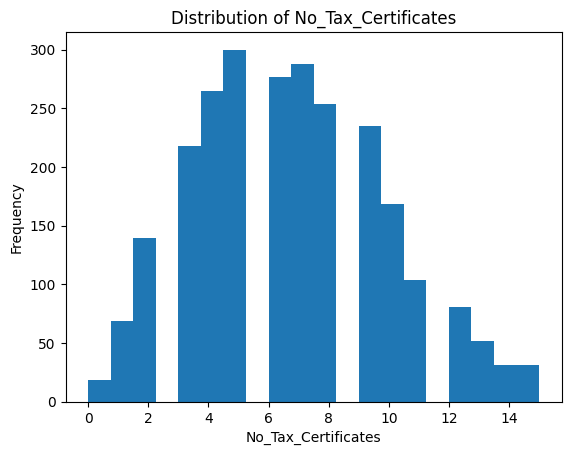

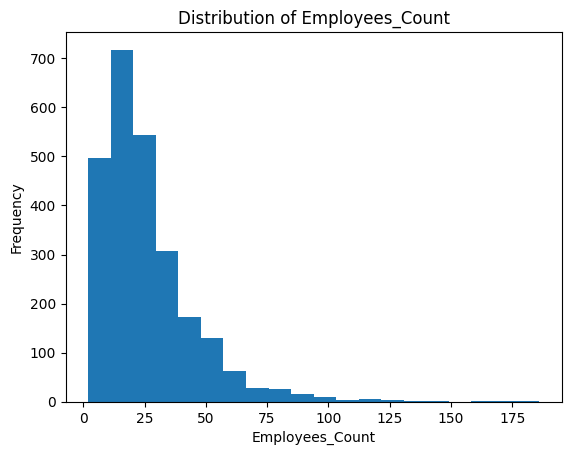

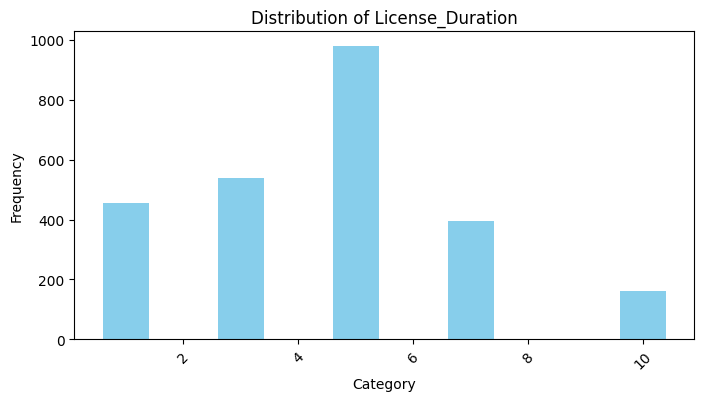

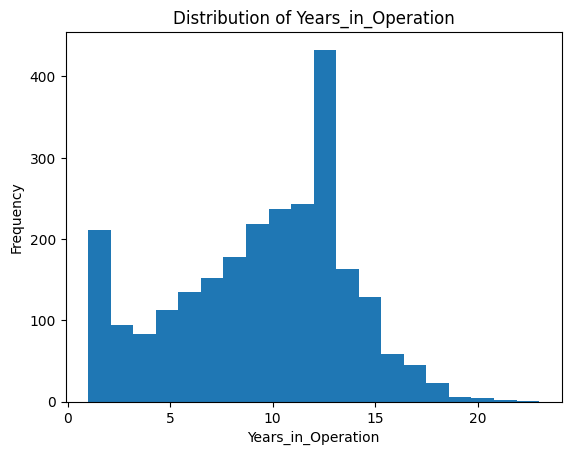

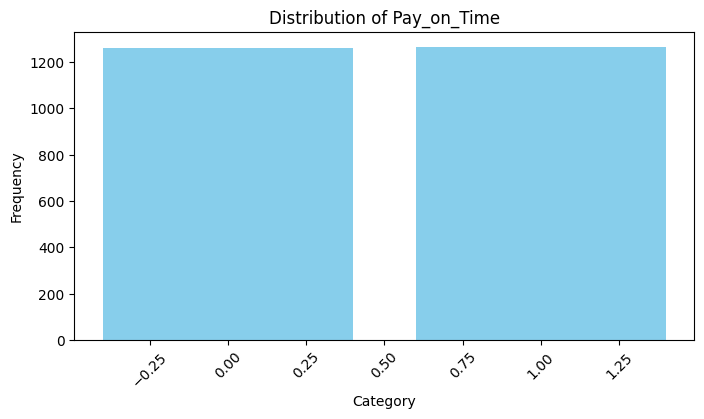

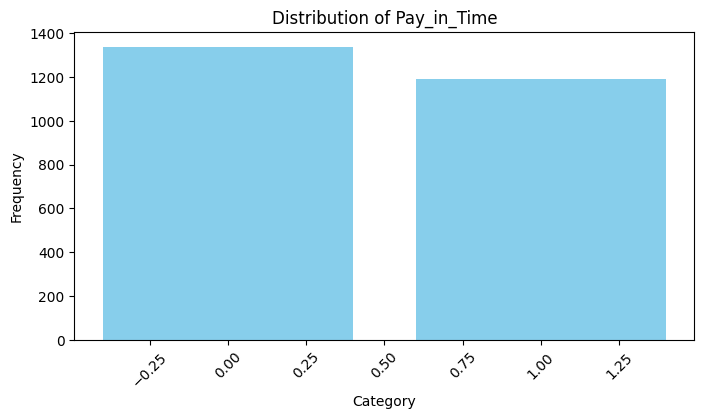

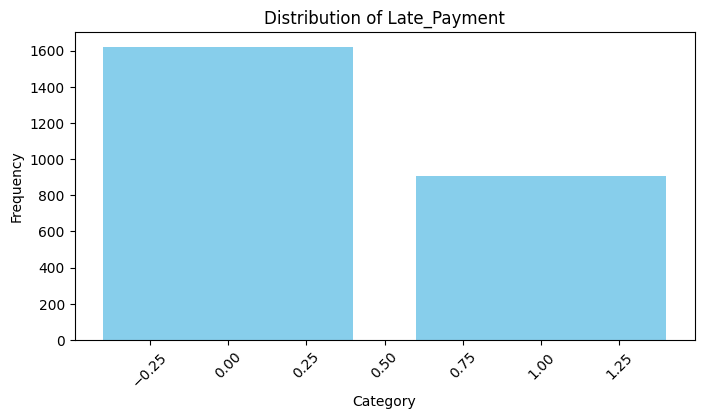

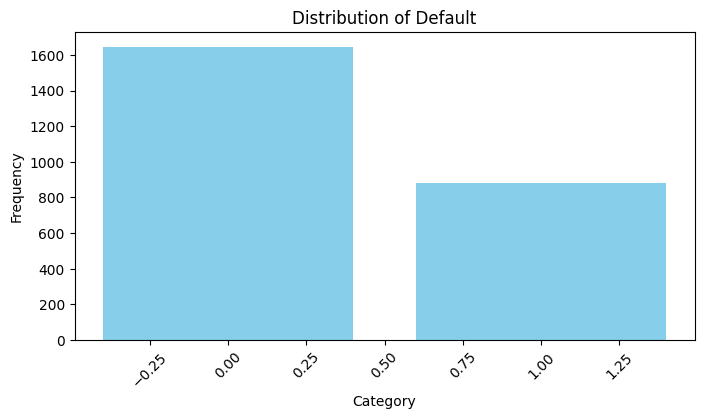

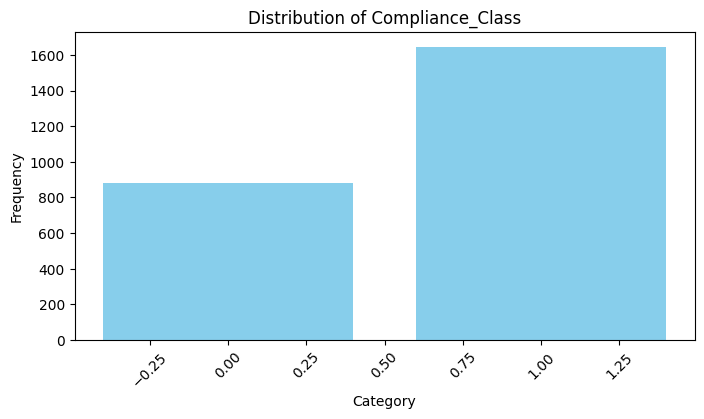

In [5]:
for column in clustered_data.columns:
    #
    if clustered_data[column].dtype == 'object' or len(clustered_data[column].unique()) < 6:  
        count = clustered_data[column].value_counts()
        plt.figure(figsize=(8, 4))
        plt.bar(count.index, count.values, color='skyblue')
        plt.title(f'Distribution of {column}')
        plt.xlabel('Category')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)  # Rotate labels if they overlap
        plt.show()
    #  bin the numerical features
    elif clustered_data[column].dtype in ['int64', 'float64']:
        clustered_data[column].plot(kind='hist', bins=20)  # Athe number of bins
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

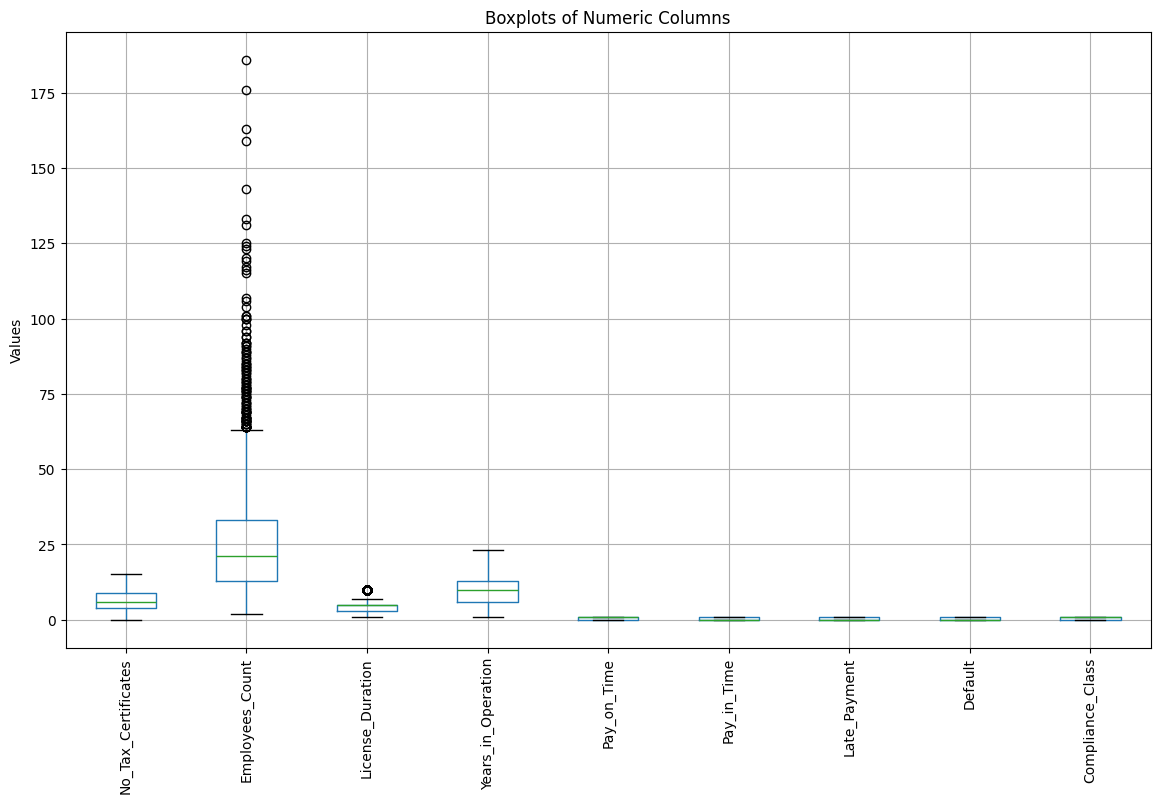

In [6]:
# # use a boxplot to identify outliers in all numeric columns
numeric_columns = clustered_data.select_dtypes(include=np.number).columns
# use a boxplot to identify outliers in all numeric columns
plt.figure(figsize=(14, 8))
clustered_data[numeric_columns].boxplot()
plt.title('Boxplots of Numeric Columns')
plt.ylabel('Values')
plt.xticks(rotation='vertical')
plt.show()


distribution of data

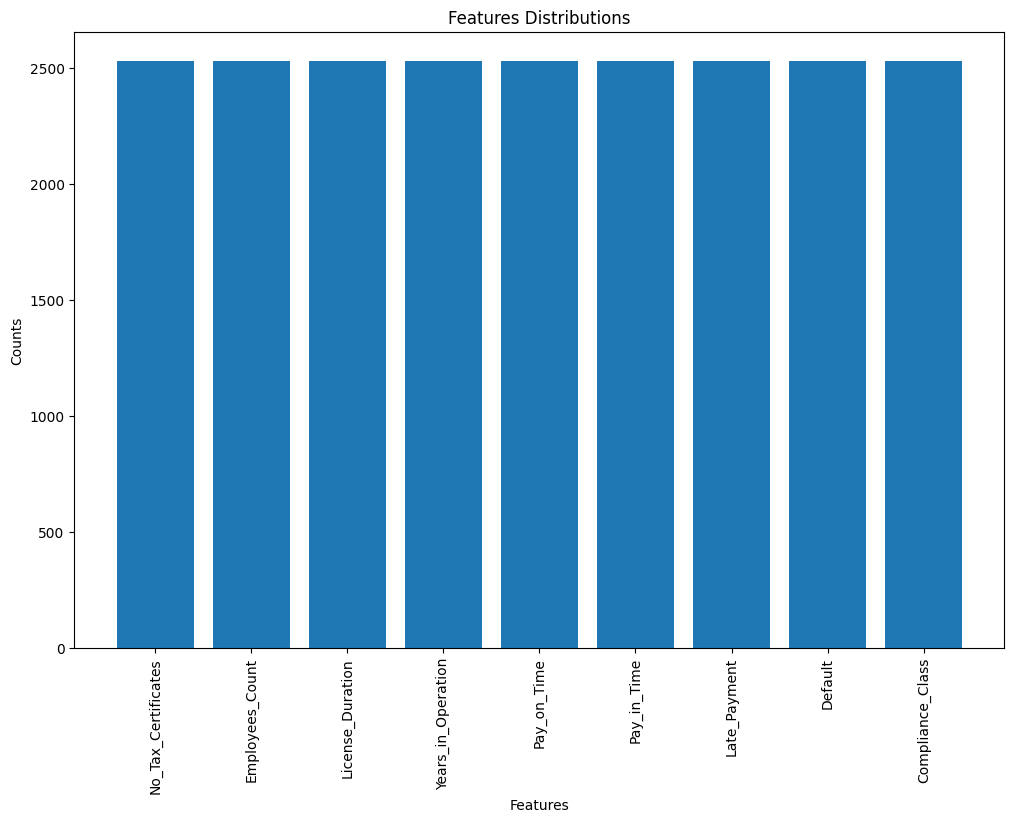

In [7]:

plt.figure(figsize=(12, 8))
plt.bar(clustered_data.columns, clustered_data.count())  # Corrected by adding () to count
plt.title('Features Distributions')
plt.xlabel('Features')
plt.ylabel('Counts')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Correlation Matrix

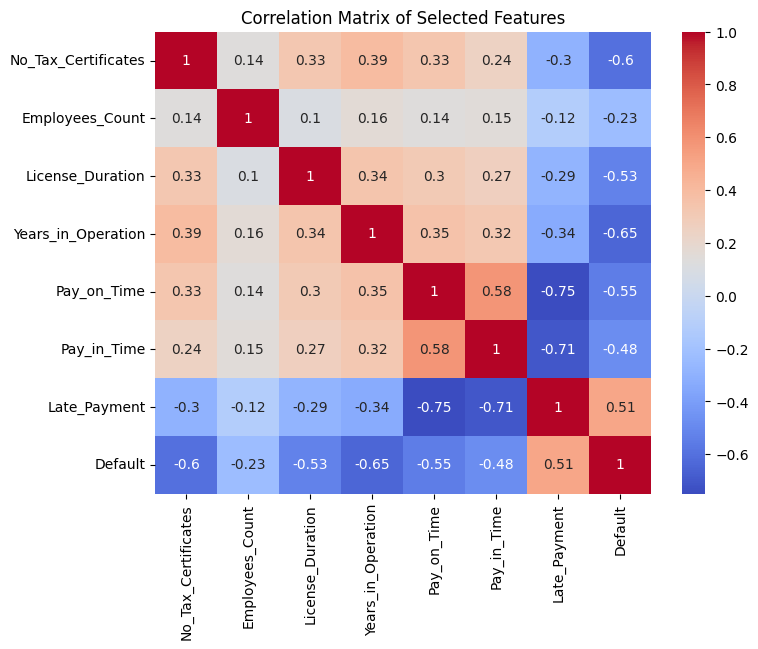

In [8]:
correlation_matrix=clustered_data[['No_Tax_Certificates','Employees_Count','License_Duration','Years_in_Operation','Pay_on_Time','Pay_in_Time','Late_Payment','Default']].corr()
# Plot correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.title('Correlation Matrix of Selected Features')
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)

plt.show()

Data distribution for default

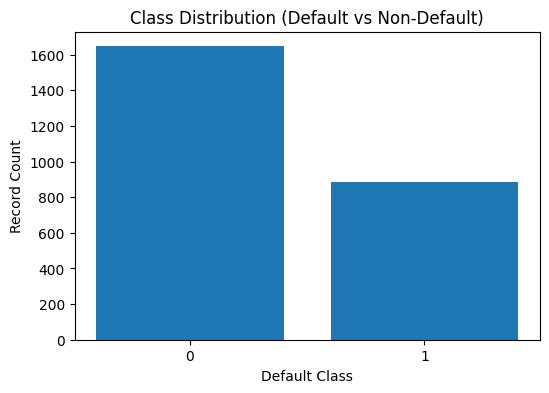

In [9]:
counts = clustered_data['Default'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution (Default vs Non-Default)")
plt.xlabel("Default Class")
plt.ylabel("Record Count")
plt.show()


In [10]:
clustered_data.shape

(2530, 9)

final models Random forest with initial data

# Tuned RF

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters Found:
{'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_samples': 0.7, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}

Best Cross-Validation F1-Macro: 0.9503

Cross-Validation Results (After Hyperparameter Tuning)
Train accuracy: 0.9695
Test  accuracy: 0.9503
----------------------------------------
Train f1: 0.9695
Test  f1: 0.9503
----------------------------------------
Train recall: 0.9695
Test  recall: 0.9503
----------------------------------------
Train precision: 0.9695
Test  precision: 0.9517
----------------------------------------
Train error_rate: 0.0305
Test  error_rate: 0.0497
----------------------------------------

TEST SET RESULTS
Accuracy:  0.9348
F1 Score:  0.9288
Recall:    0.9316
Precision: 0.9262
Error Rate:0.0652

FEATURE IMPORTANCE ANALYSIS

================ ALL FEATURE IMPORTANCES (DESCENDING) ================
               Feature  Importance

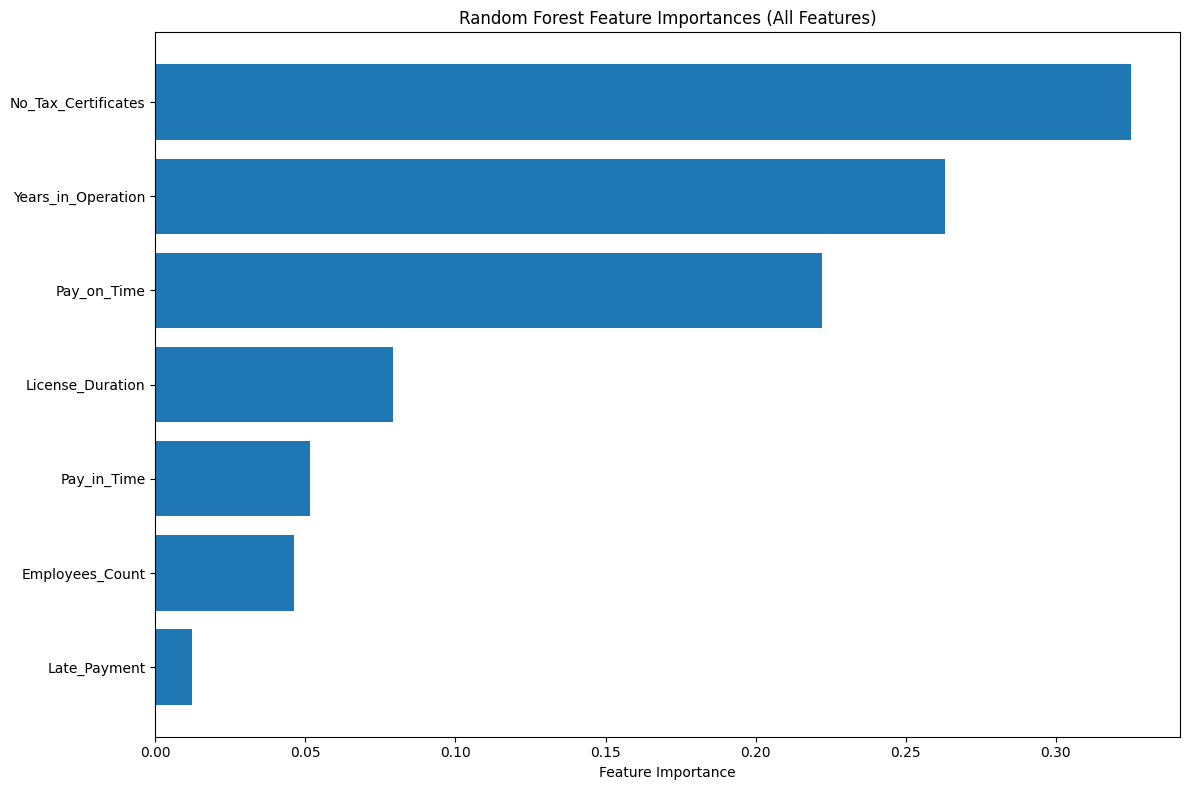

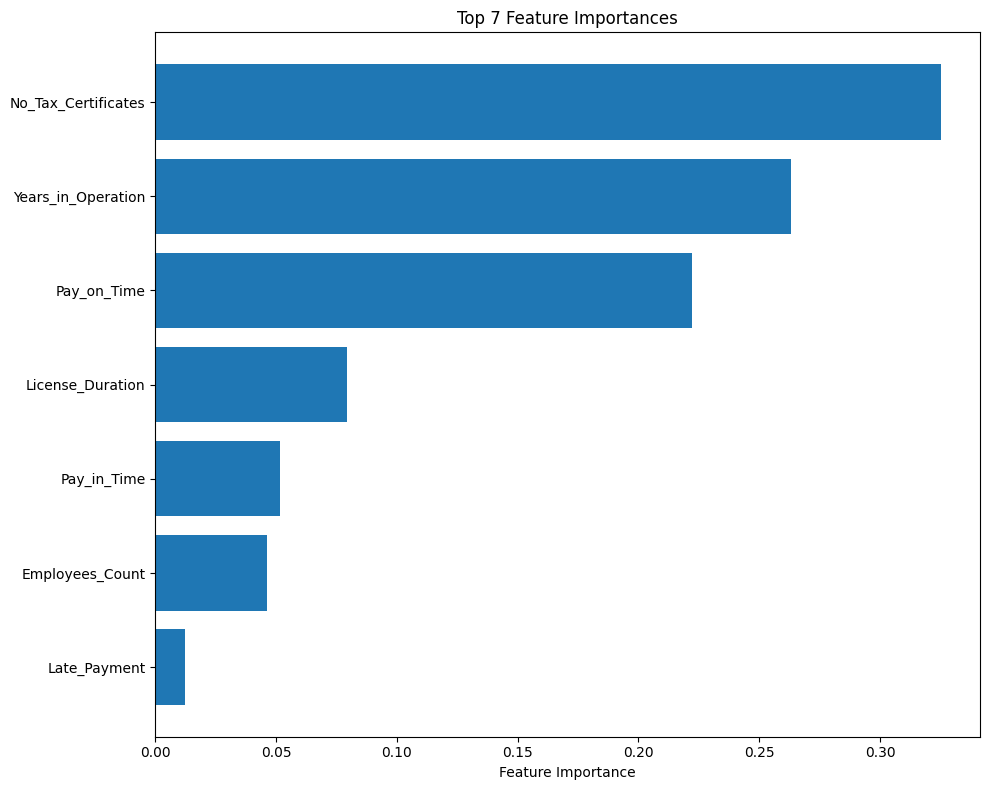


SKIPPING SHAP ANALYSIS - Using LIME for model explainability

LIME ANALYSIS

Creating LIME explainer...

Generating LIME explanations for 5 sample predictions...

--- LIME Explanation for Test Sample 1 ---
True Label: 1, Predicted: 1
Prediction Probability: No Default=0.1973, Default=0.8027

Top Feature Contributions:
  License_Duration <= 3.00: 0.2138
  0.00 < Pay_on_Time <= 1.00: -0.1862
  3.00 < No_Tax_Certificates <= 5.00: 0.1646
  0.00 < Pay_in_Time <= 1.00: -0.0916
  20.00 < Employees_Count <= 31.00: -0.0570
  Late_Payment <= 0.00: -0.0348
  5.00 < Years_in_Operation <= 9.00: 0.0074

--- LIME Explanation for Test Sample 2 ---
True Label: 1, Predicted: 1
Prediction Probability: No Default=0.0018, Default=0.9982

Top Feature Contributions:
  Years_in_Operation <= 5.00: 0.4018
  License_Duration <= 3.00: 0.2057
  Pay_on_Time <= 0.00: 0.1908
  5.00 < No_Tax_Certificates <= 8.00: -0.1095
  Pay_in_Time <= 0.00: 0.1086
  Employees_Count <= 12.00: 0.0810
  0.00 < Late_Payment <= 1.00: 0

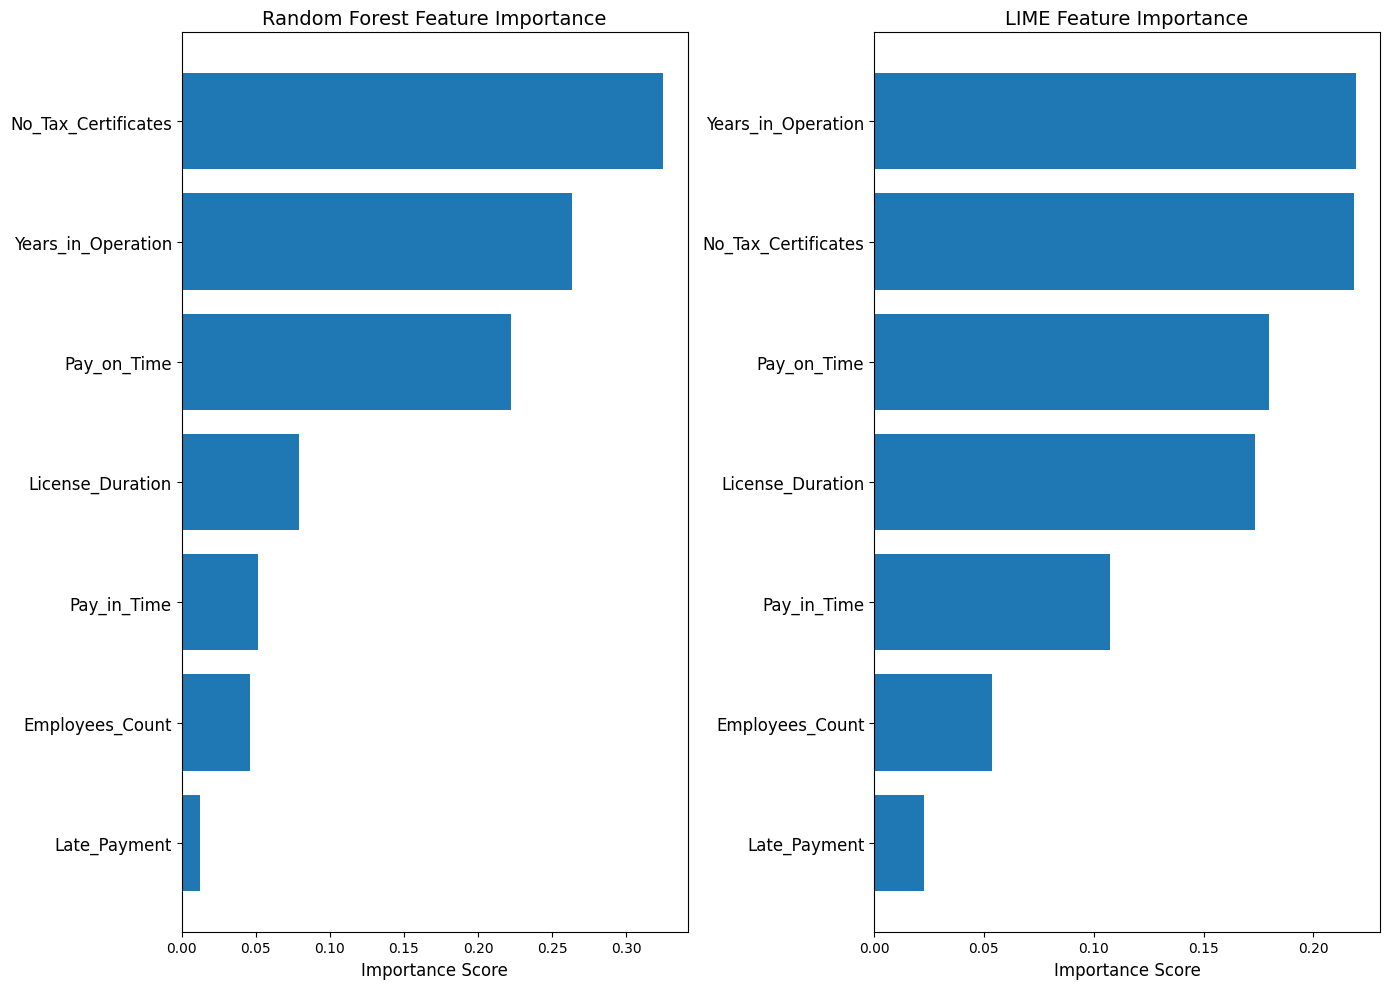


ANALYSIS COMPLETE!

Saved outputs:
  - Models: models/
  - Visualizations: visualizations/
  - Results: results/

Random Forest with LIME Explainability Analysis Completed Successfully!


In [11]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    make_scorer
)
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular

# Create necessary directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# ==========================================
# PREPARE DATA
# ==========================================
clustered_data=clustered_data.drop('Compliance_Class', axis=1)
X = clustered_data.drop('Default', axis=1)
y = clustered_data['Default']

# Stratified split keeps original imbalance in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE ONLY to training data
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


# ==========================================
# DEFINE RANDOM SEARCH PARAMETER DISTRIBUTION
# ==========================================
# ==========================================
# 2. IMPROVED RANDOM SEARCH PARAMETER DISTRIBUTION
# ==========================================
param_dist = {
    'n_estimators': [50, 100, 200, 250, 300],  # More and larger values
    'max_depth': [20, 25, 30, 40],
    'min_samples_split': [3,5, 7],
    'min_samples_leaf': [3, 4, 6, 8, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
    'bootstrap': [True, False],
    # 'class_weight': ['balanced', 'balanced_subsample', None],
    'max_samples': [0.6, 0.7, 0.8, 0.9, None]  # New parameter
}

# Create a base Random Forest estimator to be tuned
rf_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Increase iterations for better search
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=50,  # Increased from 40
    scoring='f1_macro',
    cv=5,  # Increased from 3
    verbose=2,  # More detailed output
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)
random_search.fit(X_train, y_train)


# ==========================================
# BEST MODEL
# ==========================================
best_classifier = random_search.best_estimator_

print("\nBest Hyperparameters Found:")
print(random_search.best_params_)
print(f"\nBest Cross-Validation F1-Macro: {random_search.best_score_:.4f}")


# ==========================================
# CROSS-VALIDATION ON BEST MODEL
# ==========================================
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'recall': 'recall_macro',
    'precision': 'precision_macro',
    'error_rate': make_scorer(lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred))
}

cv_results = cross_validate(
    best_classifier, X_train, y_train,
    cv=5, scoring=scoring, return_train_score=True
)

print("\nCross-Validation Results (After Hyperparameter Tuning)")
for metric in ['accuracy', 'f1', 'recall', 'precision', 'error_rate']:
    print(f"Train {metric}: {cv_results['train_' + metric].mean():.4f}")
    print(f"Test  {metric}: {cv_results['test_' + metric].mean():.4f}")
    print("-" * 40)


# ==========================================
# 6. TEST SET PERFORMANCE
# ==========================================
y_pred_test = best_classifier.predict(X_test)

print("\nTEST SET RESULTS")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Error Rate:{1 - accuracy_score(y_test, y_pred_test):.4f}")


# ==========================================
# 7. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS
# ==========================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importances = best_classifier.feature_importances_

# Create dataframe for all features
importance_df = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
    .sort_values(by='Importance', ascending=False)
    .reset_index(drop=True)
)

# Display ALL features
print("\n================ ALL FEATURE IMPORTANCES (DESCENDING) ================")
print(importance_df.to_string())

print("\n\nRanked Feature Importances:")
for i, row in importance_df.iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s}: {row['Importance']:.6f}")

# Visualize feature importance (highest to lowest)
plt.figure(figsize=(12, max(8, len(X.columns) * 0.3)))
y_pos = np.arange(len(importance_df))
plt.barh(y_pos, importance_df['Importance'])
plt.yticks(y_pos, importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances (All Features)')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.savefig('visualizations/feature_importance_all.png', dpi=300, bbox_inches='tight')
plt.show()

# Top 20 features visualization (highest to lowest)
top_n = min(20, len(importance_df))
plt.figure(figsize=(10, 8))
y_pos = np.arange(top_n)
plt.barh(y_pos, importance_df['Importance'][:top_n])
plt.yticks(y_pos, importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.savefig('visualizations/feature_importance_top20.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# SHAP EXPLAINABILITY - REMOVED DUE TO COMPATIBILITY ISSUES
# ==========================================
# SHAP section removed - using LIME for explainability instead
print("\n" + "="*80)
print("SKIPPING SHAP ANALYSIS - Using LIME for model explainability")
print("="*80)


# ==========================================
# LIME EXPLAINABILITY
# ==========================================
print("\n" + "="*80)
print("LIME ANALYSIS")
print("="*80)

# Create LIME explainer
print("\nCreating LIME explainer...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['No Default', 'Default'],
    mode='classification',
    random_state=42
)

# Explain several predictions
n_samples_to_explain = 5
print(f"\nGenerating LIME explanations for {n_samples_to_explain} sample predictions...")

for i in range(n_samples_to_explain):
    try:
        idx = i
        exp = lime_explainer.explain_instance(
            data_row=X_test.iloc[idx].values,
            predict_fn=best_classifier.predict_proba,
            num_features=min(15, len(X.columns))
        )
        
        print(f"\n--- LIME Explanation for Test Sample {i+1} ---")
        print(f"True Label: {y_test.iloc[idx]}, Predicted: {y_pred_test[idx]}")
        pred_proba = best_classifier.predict_proba(X_test.iloc[idx:idx+1])[0]
        print(f"Prediction Probability: No Default={pred_proba[0]:.4f}, Default={pred_proba[1]:.4f}")
        
        # Print feature contributions
        print("\nTop Feature Contributions:")
        for feature, weight in exp.as_list():
            print(f"  {feature}: {weight:.4f}")
        
        # Save visualization
        fig = exp.as_pyplot_figure()
        fig.set_size_inches(10, 6)
        plt.tight_layout()
        plt.savefig(f'visualizations/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"Error explaining sample {i+1}: {str(e)}")
        continue

# Aggregate LIME importances across multiple samples
print("\n\nAggregating LIME feature importance across samples...")
print("This may take a few minutes...")

lime_feature_weights = []
n_lime_samples = min(50, len(X_test))  # Reduced for efficiency

for i in range(n_lime_samples):
    try:
        exp = lime_explainer.explain_instance(
            data_row=X_test.iloc[i].values,
            predict_fn=best_classifier.predict_proba,
            num_features=len(X.columns)
        )
        
        # Get weights for each feature
        exp_map = exp.as_map()[1]  # Get explanations for positive class
        feature_weights = {idx: weight for idx, weight in exp_map}
        
        # Create vector of absolute weights
        weights_vector = [abs(feature_weights.get(j, 0)) for j in range(len(X.columns))]
        lime_feature_weights.append(weights_vector)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{n_lime_samples} samples")
            
    except Exception as e:
        print(f"  Error processing sample {i+1}: {str(e)}")
        continue

# Calculate average absolute weights
if len(lime_feature_weights) > 0:
    mean_lime_weights = np.mean(lime_feature_weights, axis=0)
    lime_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Mean_Abs_LIME': mean_lime_weights
    }).sort_values(by='Mean_Abs_LIME', ascending=False).reset_index(drop=True)
    
    print("\n================ LIME-BASED FEATURE IMPORTANCE (ALL FEATURES) ================")
    print(lime_importance_df.to_string())
    
    print("\nRanked LIME Feature Importances:")
    for i, row in lime_importance_df.iterrows():
        print(f"{i+1:2d}. {row['Feature']:30s}: {row['Mean_Abs_LIME']:.6f}")
else:
    print("\nWarning: Could not compute LIME importances due to errors")
    lime_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Mean_Abs_LIME': [0] * len(X.columns)
    })


# ==========================================
# COMPARISON OF IMPORTANCE METHODS
# ==========================================
print("\n" + "="*80)
print("COMPARISON OF FEATURE IMPORTANCE METHODS")
print("="*80)

# Merge importance measures (RF + LIME only)
comparison_df = importance_df.copy()
comparison_df = comparison_df.merge(lime_importance_df, on='Feature')

# Normalize all scores to 0-1 for comparison
for col in ['Importance', 'Mean_Abs_LIME']:
    comparison_df[f'{col}_Normalized'] = (
        comparison_df[col] / comparison_df[col].max()
    )

# Calculate average rank across methods
comparison_df['Avg_Normalized'] = comparison_df[
    ['Importance_Normalized', 'Mean_Abs_LIME_Normalized']
].mean(axis=1)

comparison_df = comparison_df.sort_values('Avg_Normalized', ascending=False).reset_index(drop=True)

print("\n================ FEATURE IMPORTANCE COMPARISON (RF vs LIME) ================")
print(comparison_df[['Feature', 'Importance', 'Mean_Abs_LIME', 'Avg_Normalized']].to_string())

# Visualize comparison (highest to lowest)
top_features = min(20, len(comparison_df))
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

for idx, (col, title) in enumerate([
    ('Importance', 'Random Forest Feature Importance'),
    ('Mean_Abs_LIME', 'LIME Feature Importance')
]):
    top_data = comparison_df.nlargest(top_features, col)
    y_pos = np.arange(len(top_data))
    axes[idx].barh(y_pos, top_data[col])
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_data['Feature'], fontsize=12)
    axes[idx].set_xlabel('Importance Score', fontsize=12)
    axes[idx].set_title(title, fontsize=14)
    axes[idx].invert_yaxis()  # Highest at top

plt.tight_layout()
plt.savefig('visualizations/importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# SAVE MODEL + RESULTS
# ==========================================
joblib.dump(best_classifier, 'models/model_rf_randomsearch.joblib')
joblib.dump(random_search, 'models/randomsearch_rf_results.joblib')

# Save importance dataframes
importance_df.to_csv('results/feature_importance_rf.csv', index=False)
lime_importance_df.to_csv('results/feature_importance_lime.csv', index=False)
comparison_df.to_csv('results/feature_importance_comparison.csv', index=False)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nSaved outputs:")
print("  - Models: models/")
print("  - Visualizations: visualizations/")
print("  - Results: results/")
print("\nRandom Forest with LIME Explainability Analysis Completed Successfully!")

## RF with Equalize odd

RANDOM FOREST WITH FOCUSED FAIRNESS ANALYSIS

Dataset shape: (2530, 7)
Actual column names in dataset:
   1. No_Tax_Certificates
   2. Employees_Count
   3. License_Duration
   4. Years_in_Operation
   5. Pay_on_Time
   6. Pay_in_Time
   7. Late_Payment

Focusing on ACTUAL sensitive features:
  • No_Tax_Certificates:
    - Data type: int64
    - Unique values: 16
    - Min: 0, Max: 15
    - Sample distribution:
No_Tax_Certificates
5    300
7    288
6    277
4    265
8    254
Name: count, dtype: int64
  • Years_in_Operation:
    - Data type: int64
    - Unique values: 22
    - Min: 1, Max: 23
    - Sample distribution:
Years_in_Operation
11    243
10    237
12    225
9     219
13    208
Name: count, dtype: int64

CREATING BINNED FEATURES FOR FAIRNESS ANALYSIS

Processing No_Tax_Certificates:

Creating bins for No_Tax_Certificates:
  Original values: 16 unique
  Value range: [0.00, 15.00]
  Mean: 6.62, Std: 3.18
  Created 4 quantile-based bins:
No_Tax_Certificates
Q1: 0.0-4.0     709
Q2:

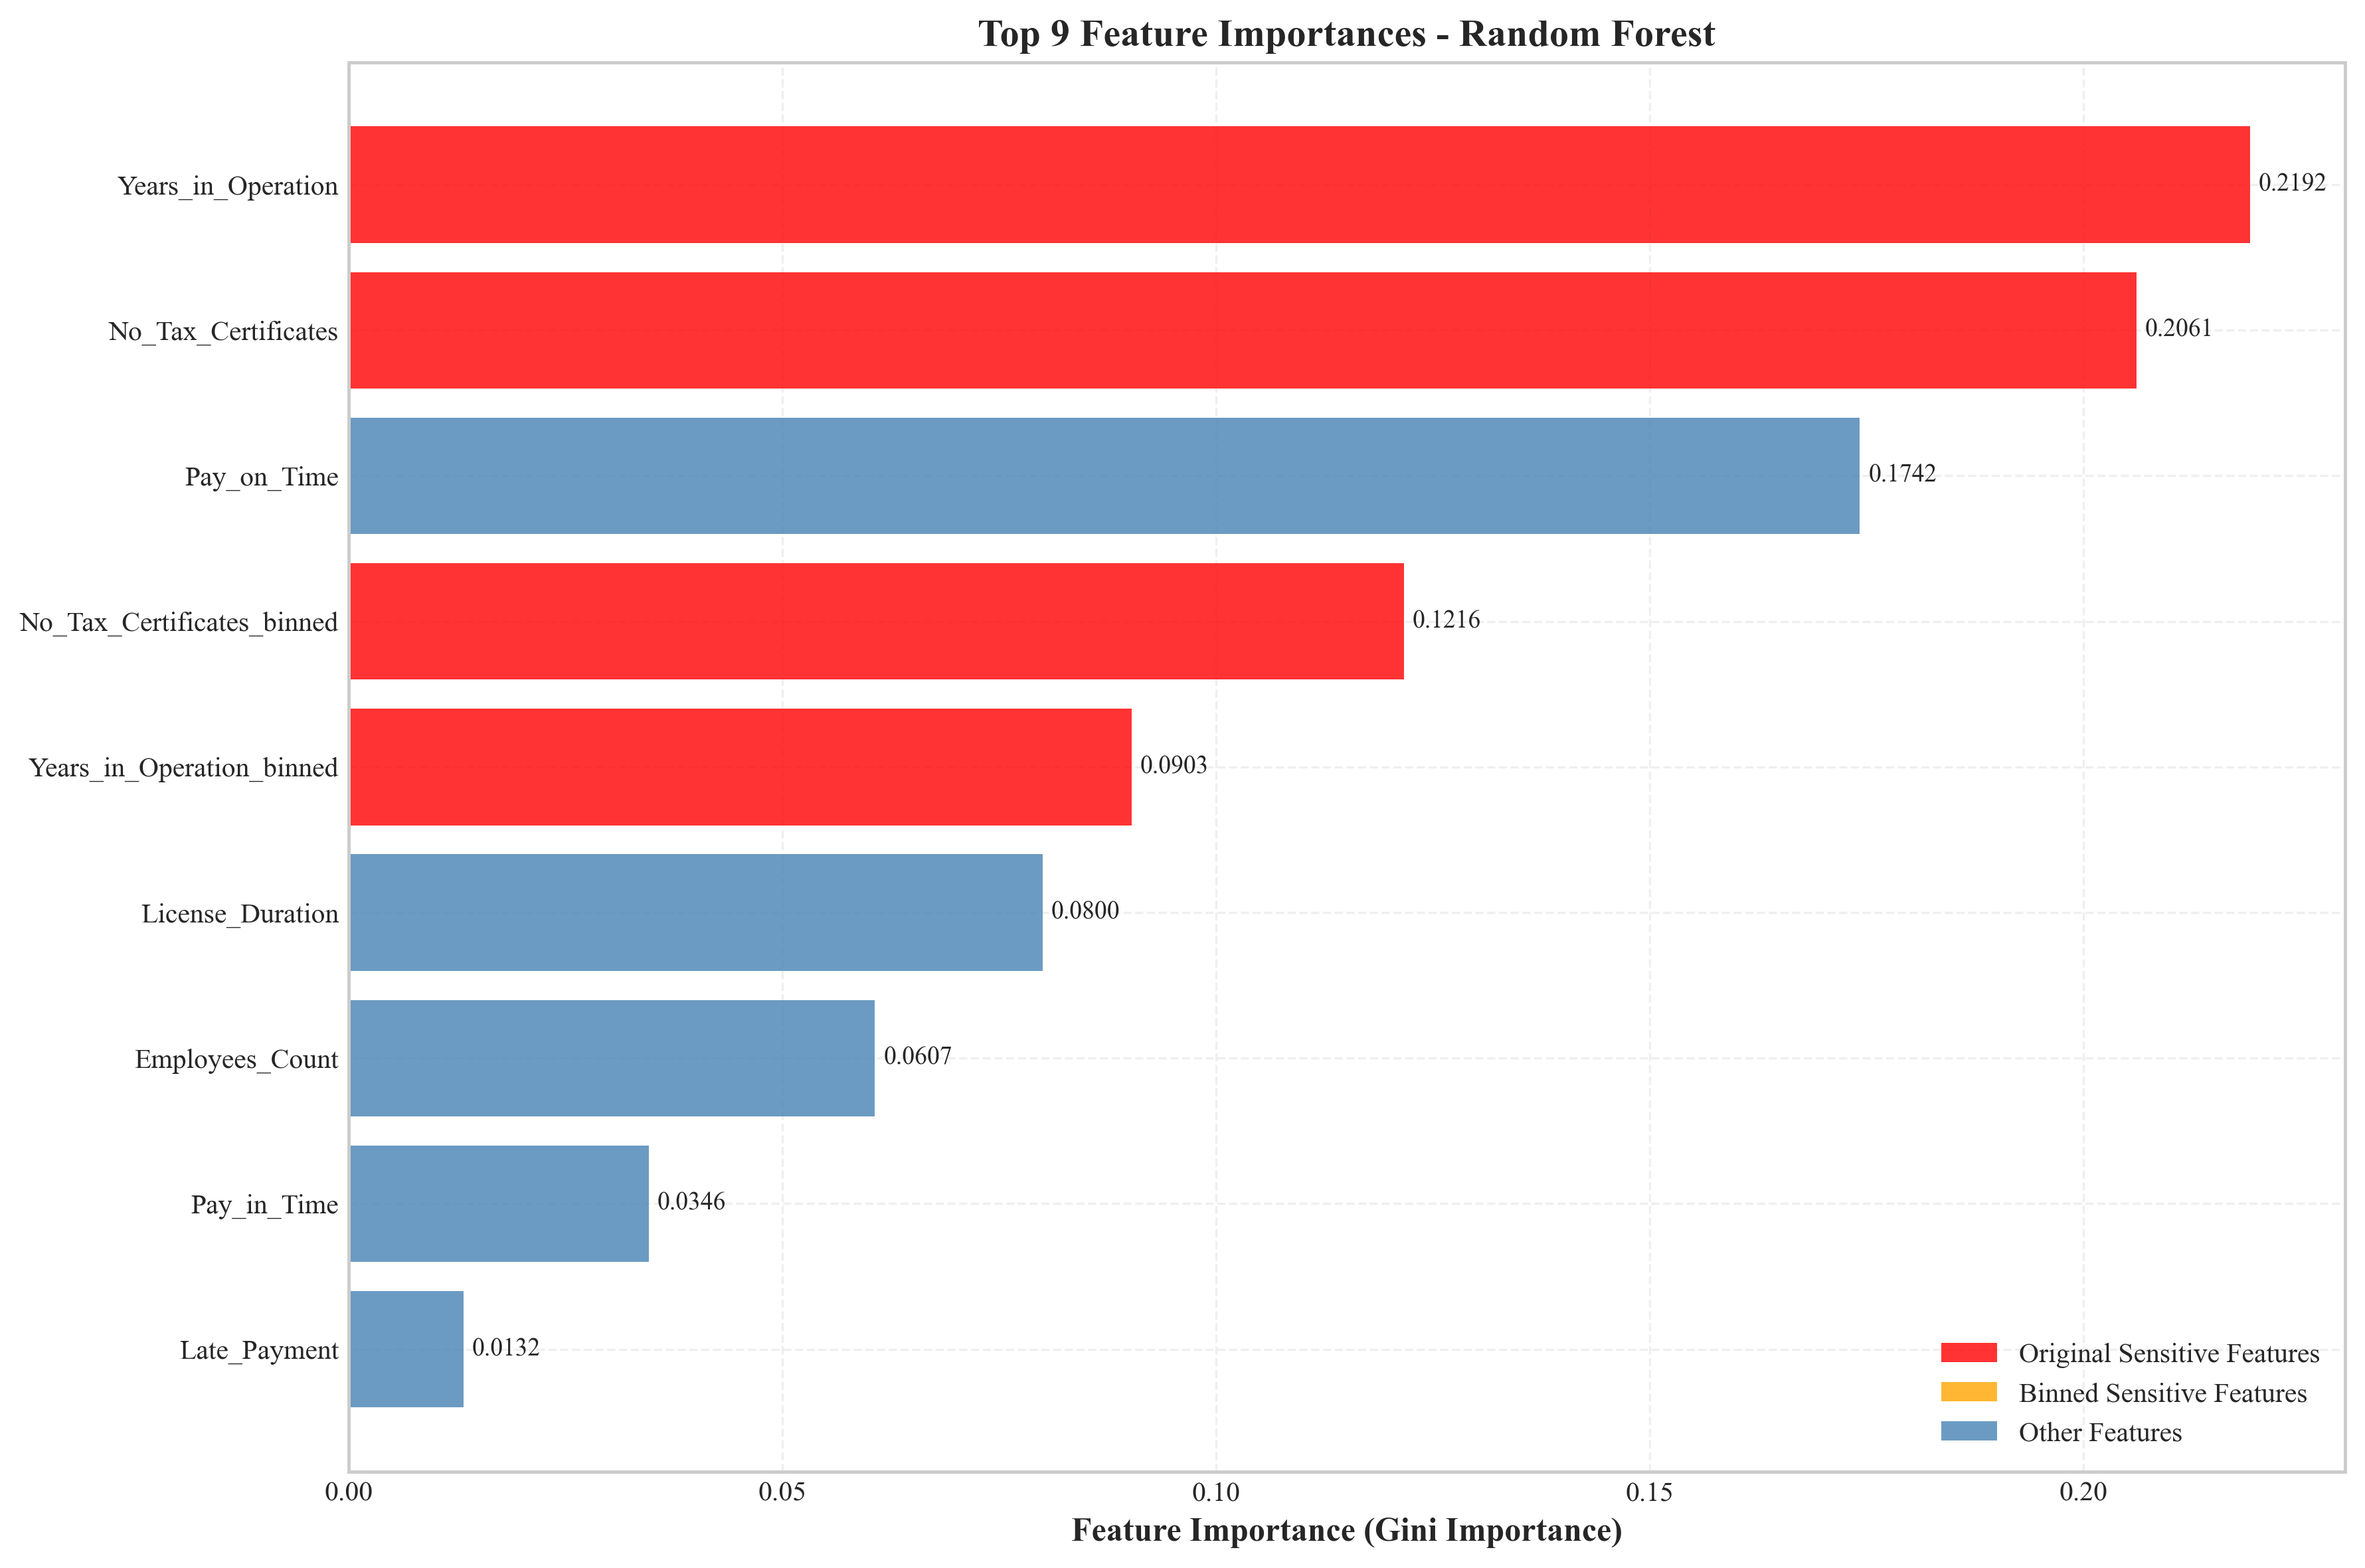


COMPREHENSIVE FAIRNESS ANALYSIS
Focus: No_Tax_Certificates and Years_in_Operation

Performing fairness analysis on binned features:
Features to analyze: ['No_Tax_Certificates_binned', 'Years_in_Operation_binned']

ANALYZING: No_Tax_Certificates_binned

FAIRNESS ANALYSIS: No_Tax_Certificates_binned
Groups found (4): ['Q1: 0.0-4.0', 'Q3: 6.0-9.0', 'Q4: 9.0-15.0', 'Q2: 4.0-6.0']

📊 GROUP PERFORMANCE METRICS:
------------------------------------------------------------------------------------------------------------------------
Group                     Size     Accuracy   Precision  Recall     F1         Sel Rate   Def Rate  
------------------------------------------------------------------------------------------------------------------------
Q1: 0.0-4.0               149      0.8993     0.9391     0.9310     0.9351     0.7718     0.7785
Q2: 4.0-6.0               108      0.9167     0.8478     0.9512     0.8966     0.4259     0.3796
Q3: 6.0-9.0               146      0.9452     0.8000 

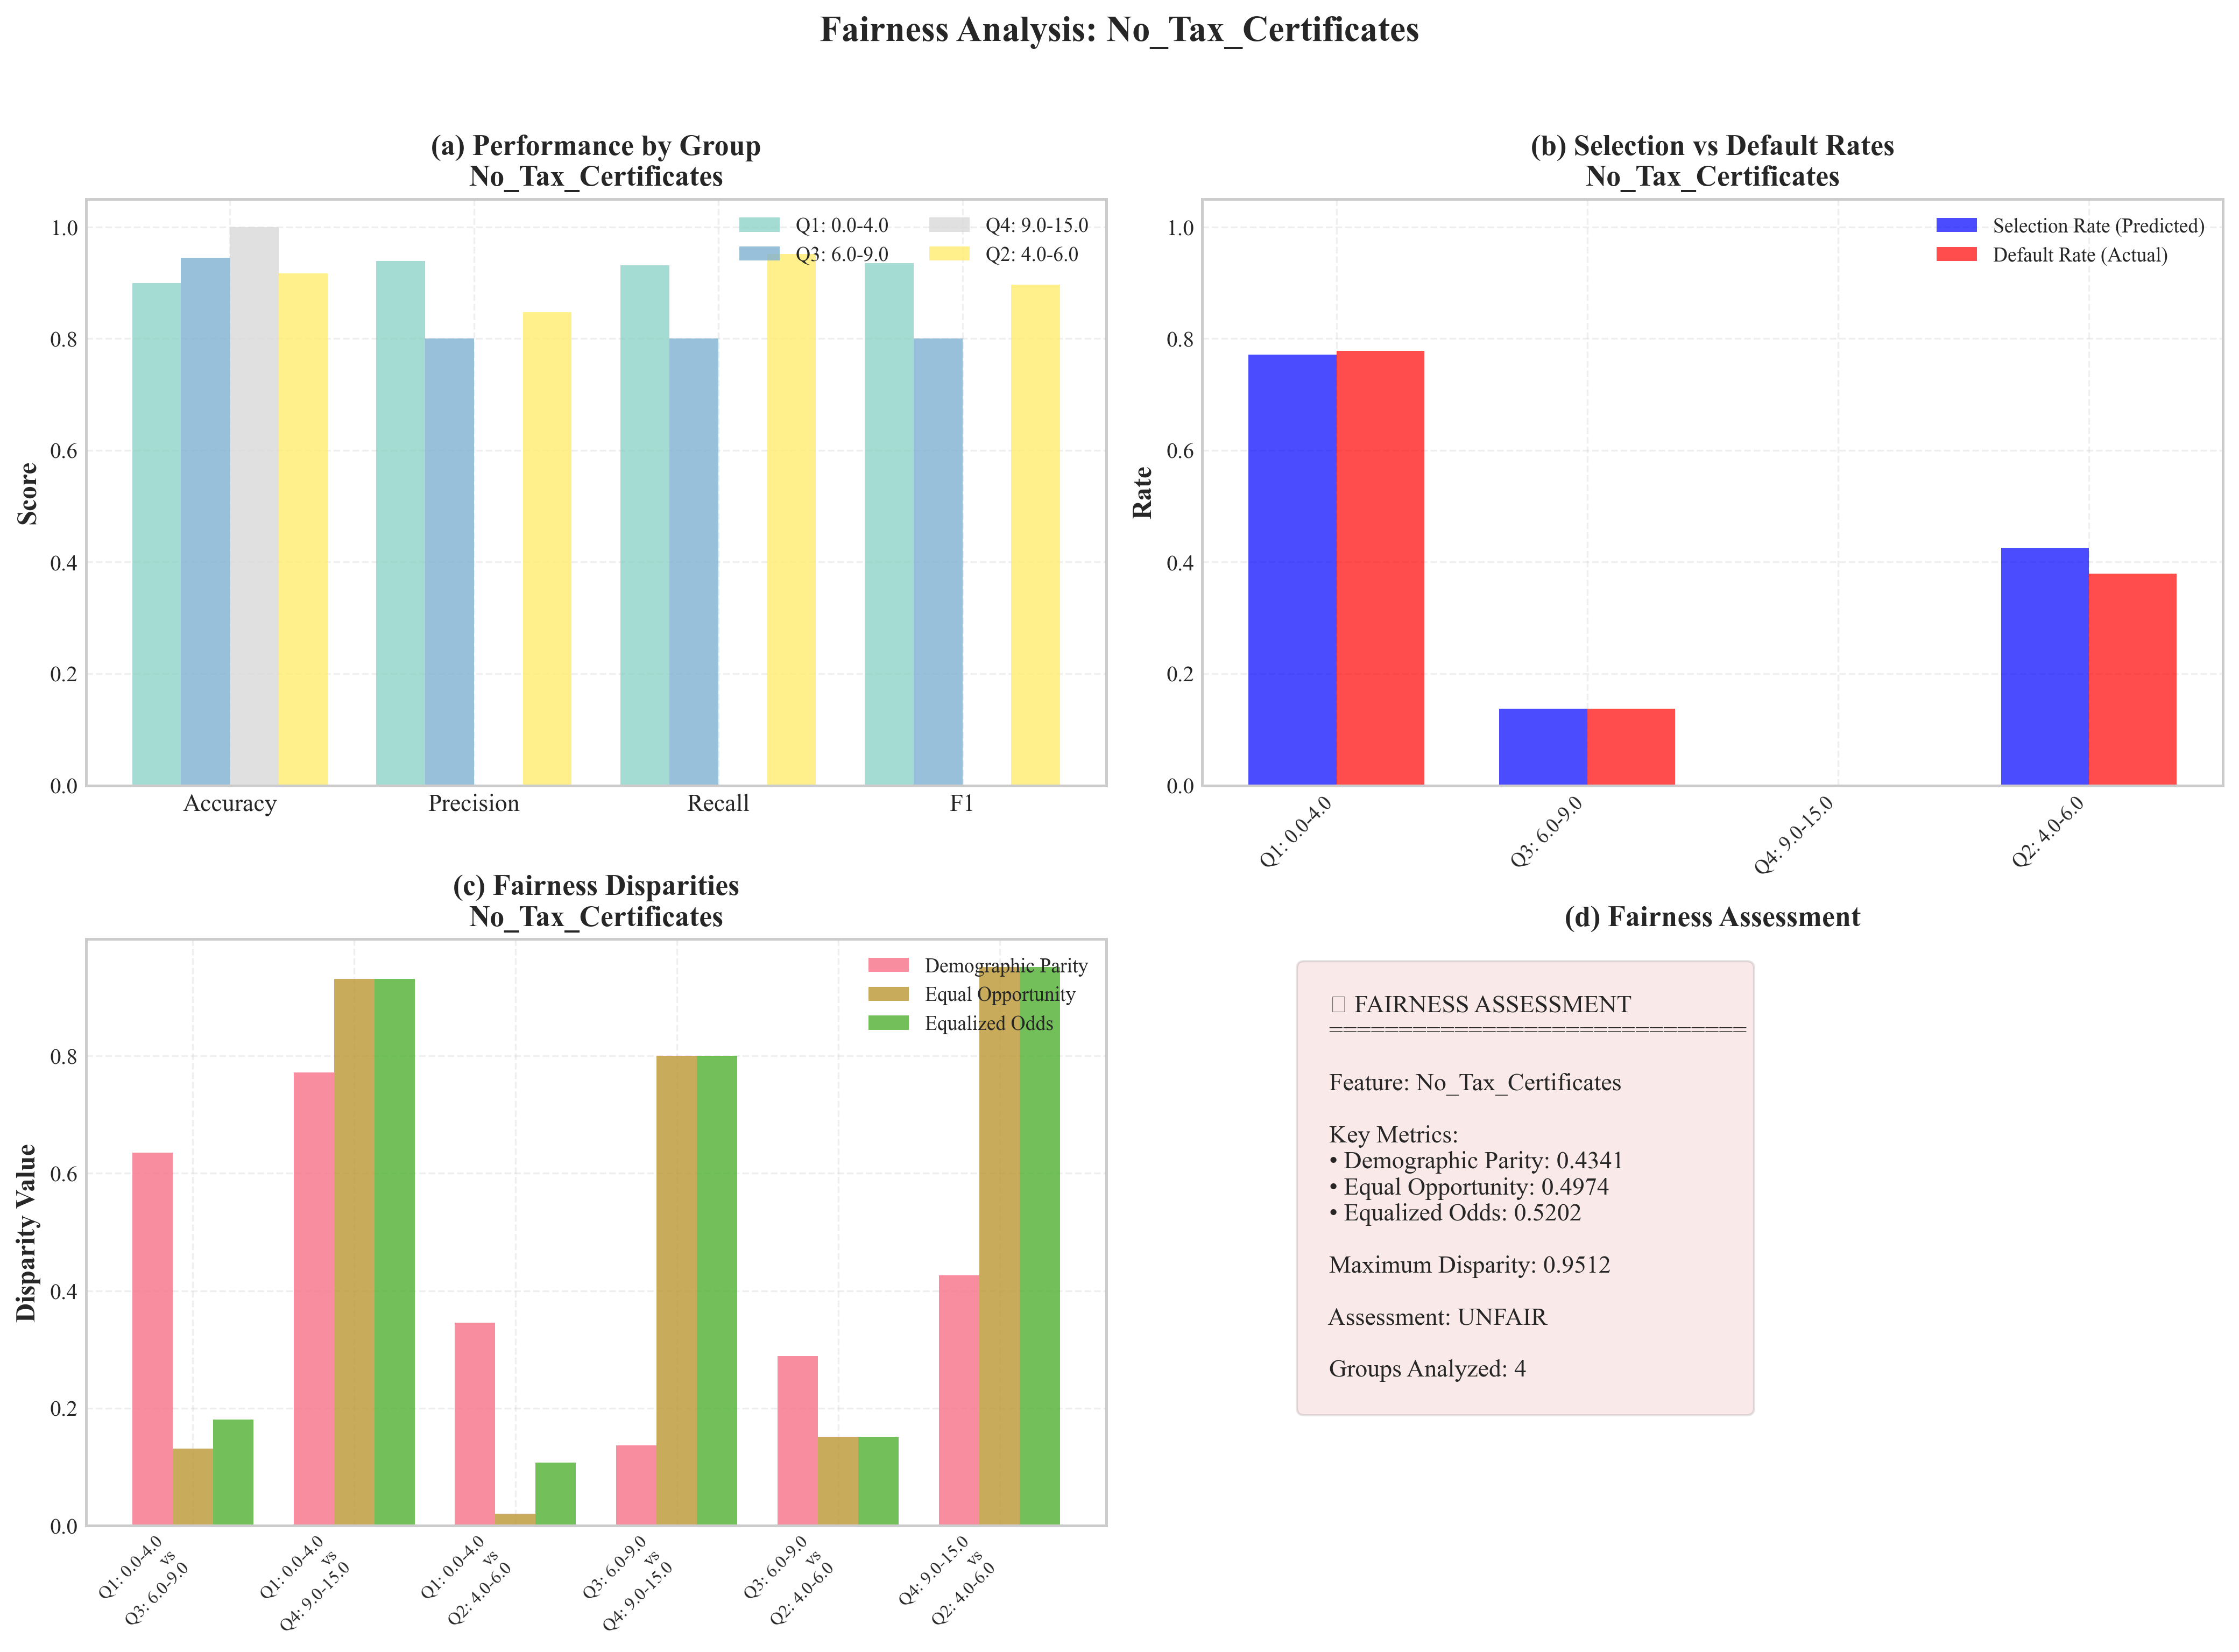

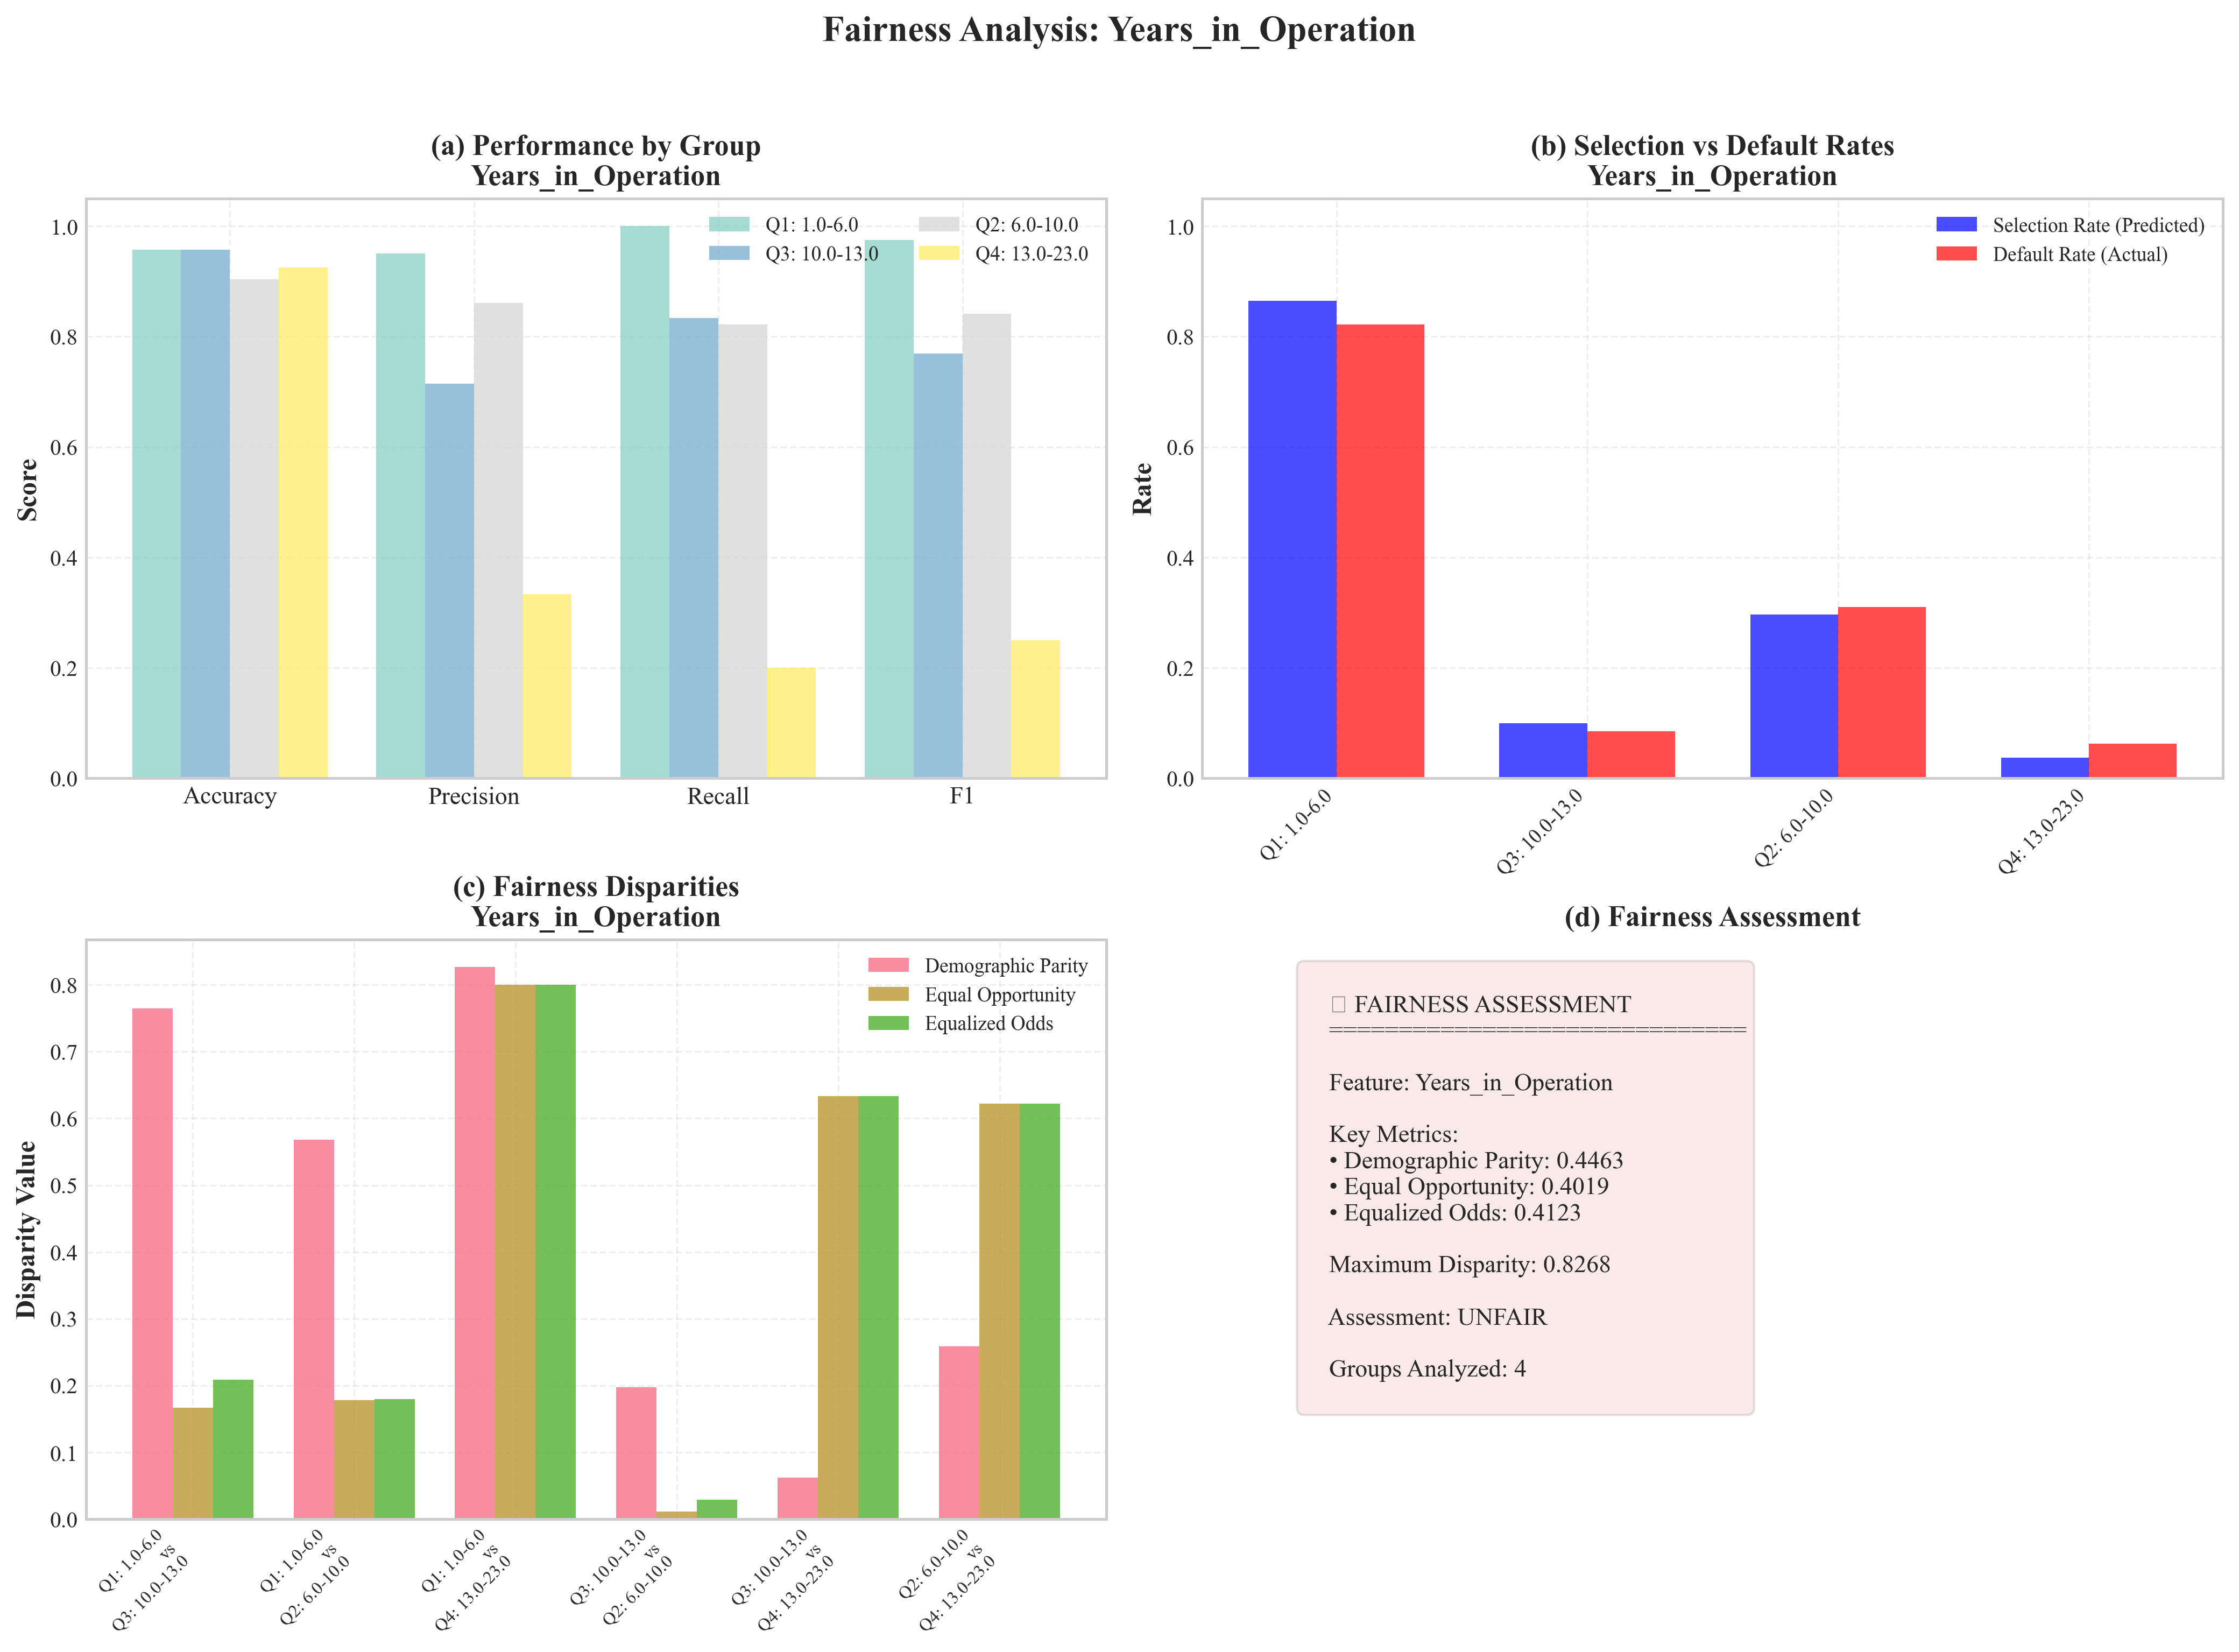


COMPARATIVE FAIRNESS ANALYSIS


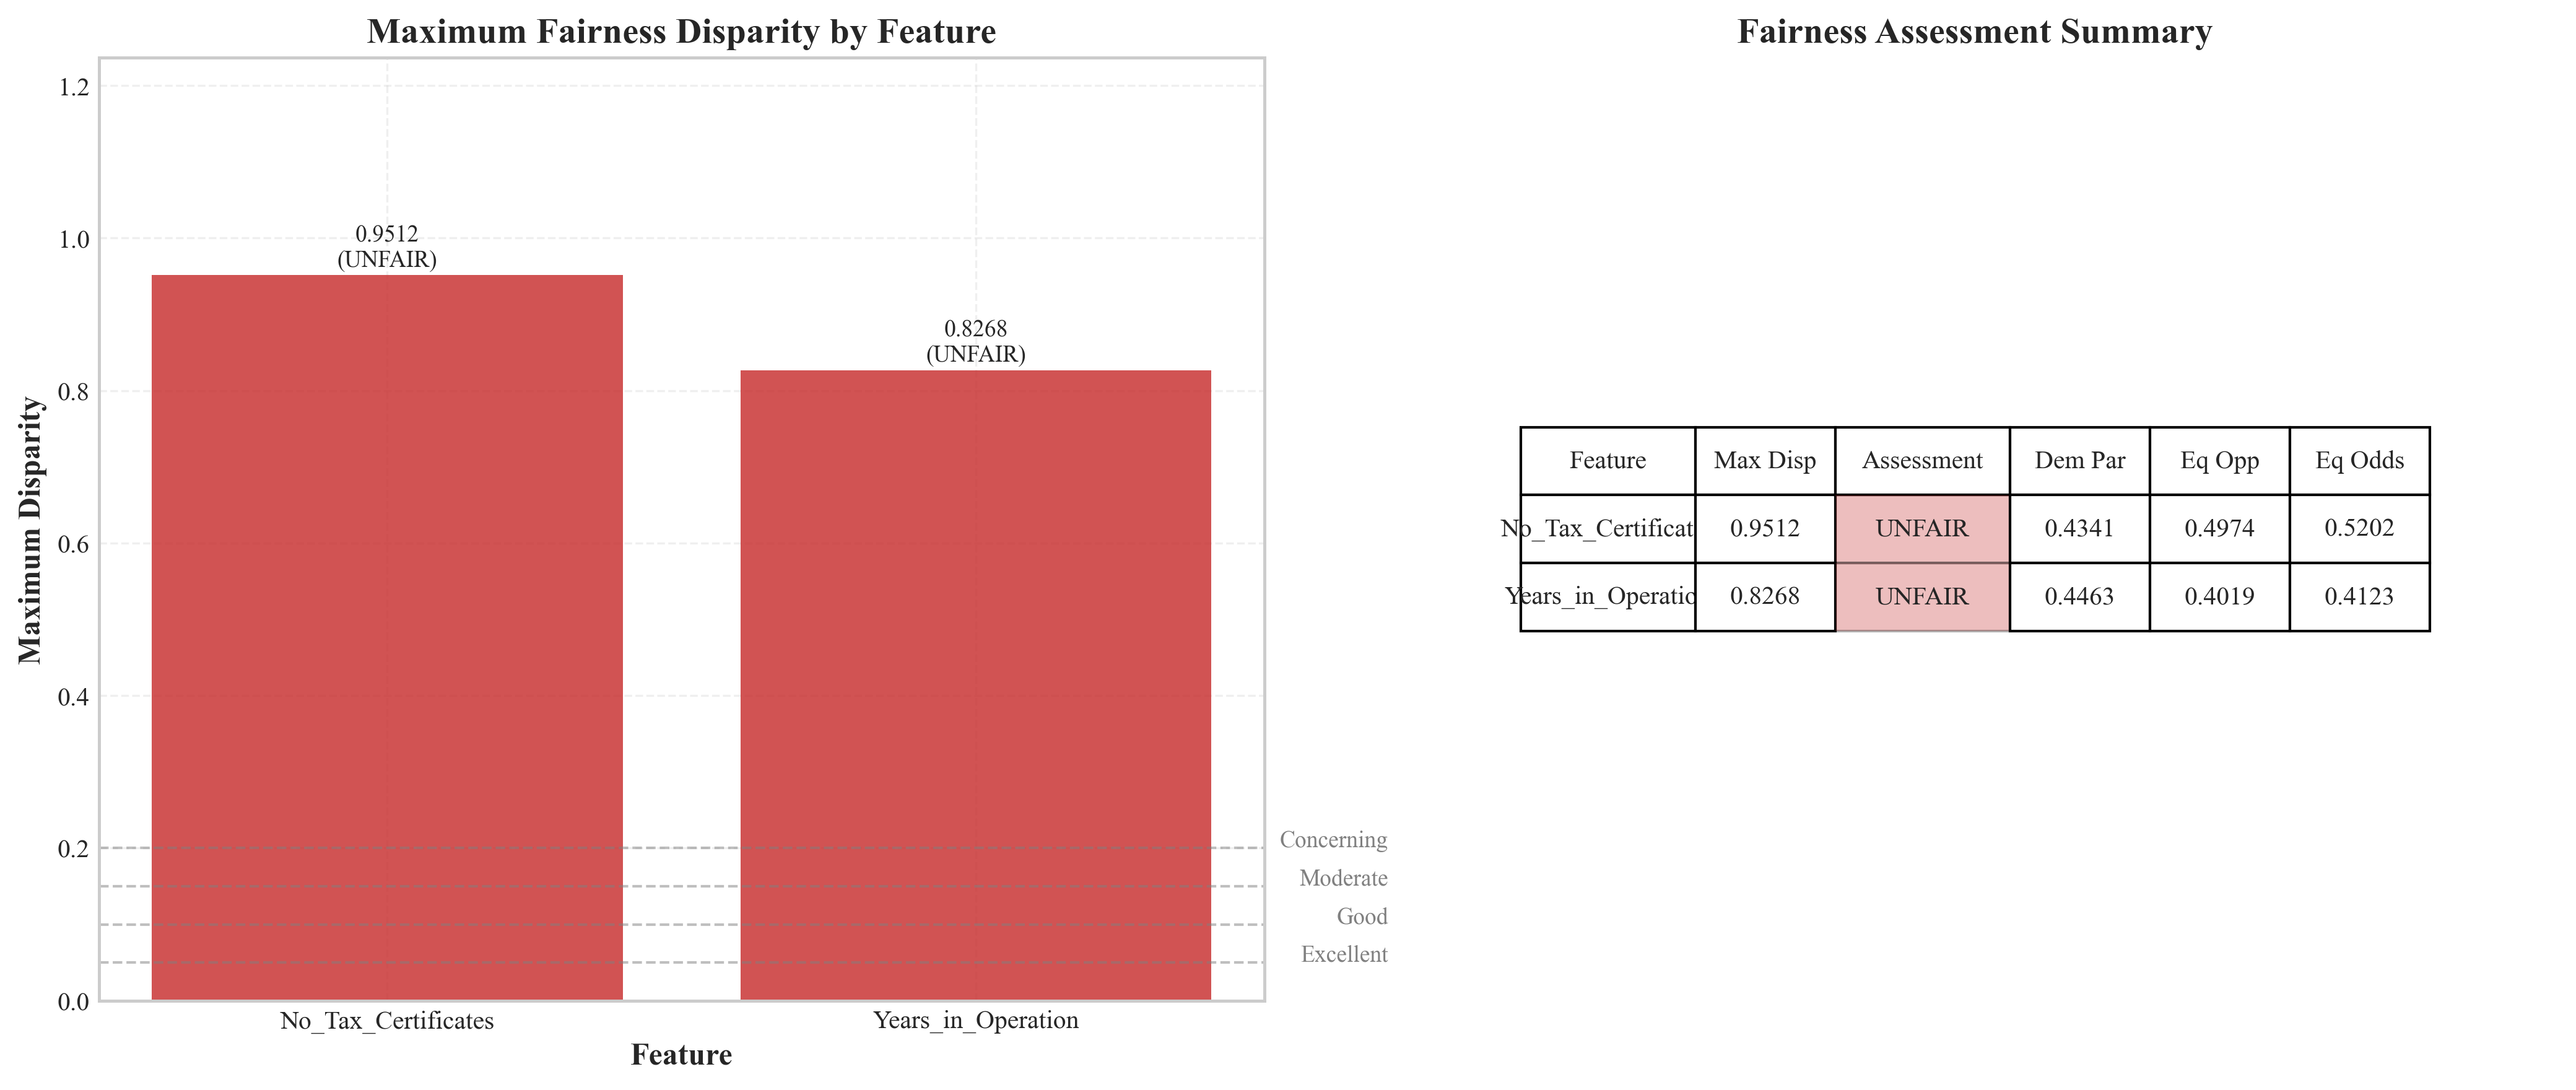


SAVING RESULTS
✓ Model saved: models/random_forest_fairness_analysis.joblib
✓ Feature importance saved: results/rf_feature_importance_fairness.csv
✓ Performance metrics saved: results/rf_performance_fairness.csv
✓ Confusion matrix saved: results/confusion_matrix_fairness.csv
✓ Fairness summary saved: results/fairness_summary_detailed.csv
✓ Group metrics saved: results/group_metrics_No_Tax_Certificates.csv
✓ Group metrics saved: results/group_metrics_Years_in_Operation.csv
✓ Disparities saved: results/disparities_No_Tax_Certificates.csv
✓ Disparities saved: results/disparities_Years_in_Operation.csv

ANALYSIS COMPLETE

📊 MODEL PERFORMANCE SUMMARY:
• Accuracy: 0.9368
• F1 Macro: 0.9308
• Precision Macro: 0.9287
• Recall Macro: 0.9331
• ROC AUC: 0.9821

⚖️  FAIRNESS ANALYSIS RESULTS:

• No_Tax_Certificates:
  Assessment: ❌ UNFAIR
  Maximum Disparity: 0.9512
  Groups Analyzed: 4
  Key Disparities:
    - Demographic Parity: 0.4341
    - Equal Opportunity: 0.4974
    - Equalized Odds: 0.520

In [12]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    make_scorer, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# SET PUBLICATION QUALITY STYLING
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

PUBLICATION_PARAMS = {
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.linewidth': 1.2,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.format': 'png',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
}

plt.rcParams.update(PUBLICATION_PARAMS)

# Create necessary directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('fairness_analysis', exist_ok=True)

# ==========================================
# 1. DATA PREPARATION AND EXPLORATION
# ==========================================
print("=" * 80)
print("RANDOM FOREST WITH FOCUSED FAIRNESS ANALYSIS")
print("=" * 80)

# Assuming X and y are already defined
# X = clustered_data.drop('Default', axis=1)
# y = clustered_data['Default']

print(f"\nDataset shape: {X.shape}")
print(f"Actual column names in dataset:")
for i, col in enumerate(X.columns):
    print(f"  {i+1:2d}. {col}")

# Based on your output, the actual sensitive features are:
SENSITIVE_FEATURES = ['No_Tax_Certificates', 'Years_in_Operation']

print(f"\nFocusing on ACTUAL sensitive features:")
for feature in SENSITIVE_FEATURES:
    if feature in X.columns:
        print(f"  • {feature}:")
        print(f"    - Data type: {X[feature].dtype}")
        print(f"    - Unique values: {X[feature].nunique()}")
        print(f"    - Min: {X[feature].min()}, Max: {X[feature].max()}")
        print(f"    - Sample distribution:")
        print(X[feature].value_counts().head())
    else:
        print(f"  • {feature}: NOT FOUND in dataset")

# ==========================================
# 2. CREATE BINNED FEATURES FOR FAIRNESS ANALYSIS
# ==========================================
print("\n" + "="*80)
print("CREATING BINNED FEATURES FOR FAIRNESS ANALYSIS")
print("="*80)

X_processed = X.copy()

def create_fairness_bins(feature_series, feature_name, n_bins=4):
    """Create meaningful bins for fairness analysis"""
    print(f"\nCreating bins for {feature_name}:")
    print(f"  Original values: {feature_series.nunique()} unique")
    print(f"  Value range: [{feature_series.min():.2f}, {feature_series.max():.2f}]")
    print(f"  Mean: {feature_series.mean():.2f}, Std: {feature_series.std():.2f}")
    
    if feature_series.nunique() <= 5:
        # Already categorical or nearly categorical
        print(f"  Feature already has {feature_series.nunique()} categories")
        binned = feature_series.astype(str)
        labels = [str(x) for x in sorted(feature_series.unique())]
    else:
        # Create quantile bins
        try:
            binned, bins = pd.qcut(feature_series, q=n_bins, retbins=True, duplicates='drop')
            print(f"  Created {binned.nunique()} quantile-based bins:")
            
            # Create meaningful labels
            labels = []
            for i in range(len(bins)-1):
                label = f"Q{i+1}: {bins[i]:.1f}-{bins[i+1]:.1f}"
                labels.append(label)
            
            # Map bins to labels
            bin_to_label = {}
            for i, interval in enumerate(sorted(binned.cat.categories)):
                bin_to_label[interval] = labels[i]
            
            binned = binned.cat.rename_categories(bin_to_label)
            print(binned.value_counts().sort_index())
            
        except Exception as e:
            print(f"  Quantile binning failed: {e}")
            # Create simple bins
            bins = np.linspace(feature_series.min(), feature_series.max(), n_bins + 1)
            binned = pd.cut(feature_series, bins=bins, include_lowest=True)
            
            # Create labels
            labels = []
            for i in range(len(bins)-1):
                label = f"Bin{i+1}: {bins[i]:.1f}-{bins[i+1]:.1f}"
                labels.append(label)
            
            bin_to_label = {}
            for i, interval in enumerate(sorted(binned.cat.categories)):
                bin_to_label[interval] = labels[i]
            
            binned = binned.cat.rename_categories(bin_to_label)
            print(f"  Created {binned.nunique()} equal-width bins:")
            print(binned.value_counts().sort_index())
    
    return binned.astype(str), labels

# Process each sensitive feature and store label mappings
binned_features = []
feature_label_mappings = {}

for feature in SENSITIVE_FEATURES:
    if feature in X_processed.columns:
        print(f"\n{'='*50}")
        print(f"Processing {feature}:")
        
        # Create bins for fairness analysis
        binned_feature, labels = create_fairness_bins(X_processed[feature], feature, n_bins=4)
        binned_feature_name = f'{feature}_binned'
        X_processed[binned_feature_name] = binned_feature
        binned_features.append(binned_feature_name)
        feature_label_mappings[binned_feature_name] = labels
        
        print(f"\n  Binned distribution for {feature}:")
        for bin_name, count in X_processed[binned_feature_name].value_counts().sort_index().items():
            print(f"    {bin_name}: {count} samples ({count/len(X_processed)*100:.1f}%)")
    else:
        print(f"\n⚠ {feature} not found in dataset!")

# Update sensitive features to use binned versions
SENSITIVE_FEATURES_BINNED = binned_features
print(f"\n{'='*50}")
print(f"Binned features created: {SENSITIVE_FEATURES_BINNED}")
print('='*50)

# ==========================================
# 3. PREPARE DATA FOR MODELING
# ==========================================
print("\n" + "="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)

# First, let's create a copy for modeling with encoded binned features
X_modeling = X_processed.copy()

# Create label encoders for binned features to convert them to numerical
label_encoders = {}
for binned_feature in SENSITIVE_FEATURES_BINNED:
    le = LabelEncoder()
    X_modeling[binned_feature] = le.fit_transform(X_modeling[binned_feature].astype(str))
    label_encoders[binned_feature] = le
    print(f"Encoded {binned_feature}: {len(le.classes_)} classes")

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_modeling, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Default rate in training: {y_train.mean():.2%}")
print(f"Default rate in test: {y_test.mean():.2%}")

# Apply SMOTE to training data
print("\nApplying SMOTE to address class imbalance...")
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
print(f"After SMOTE - Training set: {X_train_balanced.shape[0]} samples")
print(f"Default rate after SMOTE: {y_train_balanced.mean():.2%}")

# ==========================================
# 4. RANDOM FOREST MODEL TRAINING
# ==========================================
print("\n" + "="*80)
print("RANDOM FOREST MODEL TRAINING")
print("="*80)

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# Create base classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use stratified K-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("Training Random Forest with hyperparameter tuning...")
random_search.fit(X_train_balanced, y_train_balanced)

# Get best model
best_classifier = random_search.best_estimator_

print("\n" + "-"*50)
print("BEST HYPERPARAMETERS:")
print("-"*50)
for param, value in random_search.best_params_.items():
    print(f"{param:25s}: {value}")

# ==========================================
# 5. COMPREHENSIVE MODEL EVALUATION
# ==========================================
print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred_test = best_classifier.predict(X_test)
y_pred_proba_test = best_classifier.predict_proba(X_test)

# Calculate comprehensive metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test),
    'F1_Macro': f1_score(y_test, y_pred_test, average='macro'),
    'F1_Weighted': f1_score(y_test, y_pred_test, average='weighted'),
    'F1_Binary': f1_score(y_test, y_pred_test, average='binary'),
    'Precision_Macro': precision_score(y_test, y_pred_test, average='macro'),
    'Precision_Weighted': precision_score(y_test, y_pred_test, average='weighted'),
    'Precision_Binary': precision_score(y_test, y_pred_test, average='binary'),
    'Recall_Macro': recall_score(y_test, y_pred_test, average='macro'),
    'Recall_Weighted': recall_score(y_test, y_pred_test, average='weighted'),
    'Recall_Binary': recall_score(y_test, y_pred_test, average='binary'),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_test[:, 1])
}

print("\nTEST SET PERFORMANCE METRICS:")
print("-" * 60)
print(f"{'Metric':25s} | {'Value':10s}")
print("-" * 60)
for metric_name, value in metrics.items():
    print(f"{metric_name:25s} | {value:10.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f"\nCONFUSION MATRIX:")
print("                Predicted")
print("              No Default  Default")
print("-" * 40)
print(f"Actual No Default | {cm[0,0]:8d}    {cm[0,1]:8d}")
print(f"Actual Default    | {cm[1,0]:8d}    {cm[1,1]:8d}")

# Classification report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_test, 
                          target_names=['No Default', 'Default'],
                          digits=4))

# ==========================================
# 6. FEATURE IMPORTANCE ANALYSIS
# ==========================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importances
feature_importances = best_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_modeling.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nALL FEATURES RANKED BY IMPORTANCE:")
print("-" * 70)
for i, row in importance_df.iterrows():
    is_sensitive = any(sf in row['Feature'] for sf in SENSITIVE_FEATURES + SENSITIVE_FEATURES_BINNED)
    marker = "⚖️" if is_sensitive else "  "
    print(f"{i+1:2d}. {marker} {row['Feature']:30s}: {row['Importance']:.6f}")

print("\nSENSITIVE FEATURES IMPORTANCE:")
print("-" * 50)
for feature in SENSITIVE_FEATURES + SENSITIVE_FEATURES_BINNED:
    if feature in importance_df['Feature'].values:
        imp = importance_df.loc[importance_df['Feature'] == feature, 'Importance'].values[0]
        rank = importance_df[importance_df['Importance'] > imp].shape[0] + 1
        total = len(importance_df)
        feature_type = "[Binned]" if "binned" in feature else "[Original]"
        print(f"{feature:25s} {feature_type:10s}: Importance={imp:.6f} (Rank: {rank}/{total})")

# Create feature importance visualization
plt.figure(figsize=(12, 8))
top_n = min(15, len(importance_df))
top_features = importance_df.head(top_n)

# Create color map
colors = []
for feature in top_features['Feature']:
    if any(sf in feature for sf in SENSITIVE_FEATURES):
        colors.append('red')
    elif any(sf in feature for sf in SENSITIVE_FEATURES_BINNED):
        colors.append('orange')
    else:
        colors.append('steelblue')

bars = plt.barh(range(top_n), top_features['Importance'], color=colors, alpha=0.8)
plt.yticks(range(top_n), top_features['Feature'], fontsize=10)
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.8, label='Original Sensitive Features'),
    Patch(facecolor='orange', alpha=0.8, label='Binned Sensitive Features'),
    Patch(facecolor='steelblue', alpha=0.8, label='Other Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('visualizations/rf_feature_importance_final.png', dpi=300)
plt.show()

# ==========================================
# 7. COMPREHENSIVE FAIRNESS ANALYSIS
# ==========================================
print("\n" + "="*80)
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("Focus: No_Tax_Certificates and Years_in_Operation")
print("="*80)

# We need to use the original X_test (with string binned values) for fairness analysis
# First, let's reconstruct the X_test with string binned values
X_test_original_binned = X_processed.loc[X_test.index].copy()

print(f"\nPerforming fairness analysis on binned features:")
print(f"Features to analyze: {SENSITIVE_FEATURES_BINNED}")

class FairnessAnalyzer:
    """Fairness analysis using binned features"""
    
    @staticmethod
    def analyze_feature_fairness(X_test_orig, y_test, y_pred, binned_feature_name, label_mapping=None):
        """Analyze fairness for a binned feature"""
        print(f"\n{'='*70}")
        print(f"FAIRNESS ANALYSIS: {binned_feature_name}")
        print('='*70)
        
        if binned_feature_name not in X_test_orig.columns:
            print(f"❌ Error: {binned_feature_name} not found in data")
            return None
        
        # Get unique groups
        groups = X_test_orig[binned_feature_name].unique()
        groups = [str(g) for g in groups if pd.notna(g)]
        
        if len(groups) < 2:
            print(f"⚠ Warning: Only {len(groups)} group found for {binned_feature_name}")
            return None
        
        print(f"Groups found ({len(groups)}): {groups}")
        
        # Calculate metrics for each group
        group_metrics = {}
        for group in groups:
            mask = X_test_orig[binned_feature_name].astype(str) == str(group)
            y_true_group = y_test[mask]
            y_pred_group = y_pred[mask]
            
            if len(y_true_group) == 0:
                print(f"  ⚠ No samples for group: {group}")
                continue
            
            # Confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
            
            # Calculate metrics
            accuracy = accuracy_score(y_true_group, y_pred_group)
            precision = precision_score(y_true_group, y_pred_group, zero_division=0)
            recall = recall_score(y_true_group, y_pred_group, zero_division=0)
            f1 = f1_score(y_true_group, y_pred_group, zero_division=0)
            
            # Fairness metrics
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
            selection_rate = np.mean(y_pred_group)  # Positive prediction rate
            default_rate = y_true_group.mean()  # Actual default rate
            
            group_metrics[group] = {
                'size': len(y_true_group),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tpr': tpr,
                'fpr': fpr,
                'selection_rate': selection_rate,
                'default_rate': default_rate,
                'true_positives': tp,
                'false_positives': fp,
                'true_negatives': tn,
                'false_negatives': fn
            }
        
        if len(group_metrics) < 2:
            print(f"⚠ Not enough groups with data for analysis")
            return None
        
        # Calculate disparities between all pairs of groups
        disparities = {}
        group_pairs = list(combinations(group_metrics.keys(), 2))
        
        for group1, group2 in group_pairs:
            key = f"{group1} vs {group2}"
            
            # Calculate all disparity metrics
            dp_diff = abs(group_metrics[group1]['selection_rate'] - group_metrics[group2]['selection_rate'])
            eo_diff = abs(group_metrics[group1]['tpr'] - group_metrics[group2]['tpr'])
            tpr_diff = abs(group_metrics[group1]['tpr'] - group_metrics[group2]['tpr'])
            fpr_diff = abs(group_metrics[group1]['fpr'] - group_metrics[group2]['fpr'])
            eod_diff = max(tpr_diff, fpr_diff)
            accuracy_diff = abs(group_metrics[group1]['accuracy'] - group_metrics[group2]['accuracy'])
            precision_diff = abs(group_metrics[group1]['precision'] - group_metrics[group2]['precision'])
            recall_diff = abs(group_metrics[group1]['recall'] - group_metrics[group2]['recall'])
            f1_diff = abs(group_metrics[group1]['f1'] - group_metrics[group2]['f1'])
            
            disparities[key] = {
                'demographic_parity': dp_diff,
                'equal_opportunity': eo_diff,
                'equalized_odds': eod_diff,
                'accuracy_difference': accuracy_diff,
                'precision_difference': precision_diff,
                'recall_difference': recall_diff,
                'f1_difference': f1_diff,
                'tpr_difference': tpr_diff,
                'fpr_difference': fpr_diff
            }
        
        # Print detailed results
        print(f"\n📊 GROUP PERFORMANCE METRICS:")
        print("-" * 120)
        header = f"{'Group':<25} {'Size':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Sel Rate':<10} {'Def Rate':<10}"
        print(header)
        print("-" * 120)
        
        for group, metrics_dict in sorted(group_metrics.items()):
            print(f"{str(group):<25} {metrics_dict['size']:<8} {metrics_dict['accuracy']:.4f}     "
                  f"{metrics_dict['precision']:.4f}     {metrics_dict['recall']:.4f}     "
                  f"{metrics_dict['f1']:.4f}     {metrics_dict['selection_rate']:.4f}     "
                  f"{metrics_dict['default_rate']:.4f}")
        
        # Calculate summary statistics
        disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds']
        overall_scores = {}
        for disp_type in disparity_types:
            values = [disparities[comp][disp_type] for comp in disparities]
            overall_scores[disp_type] = {
                'mean': np.mean(values) if values else 0,
                'max': np.max(values) if values else 0,
                'min': np.min(values) if values else 0,
                'std': np.std(values) if values else 0
            }
        
        # Find maximum disparity
        all_disparities = []
        for disp_type in disparity_types:
            all_disparities.extend([disparities[comp][disp_type] for comp in disparities])
        max_disparity = max(all_disparities) if all_disparities else 0
        
        print(f"\n⚖️  FAIRNESS DISPARITIES SUMMARY:")
        print("-" * 70)
        for disp_type in disparity_types:
            mean_val = overall_scores[disp_type]['mean']
            max_val = overall_scores[disp_type]['max']
            print(f"{disp_type.replace('_', ' ').title():25s}: Mean={mean_val:.4f}, Max={max_val:.4f}")
        
        # Determine assessment
        if max_disparity < 0.05:
            assessment = "EXCELLENT"
            color = "#2E7D32"
            emoji = "✅"
        elif max_disparity < 0.1:
            assessment = "GOOD"
            color = "#7CB342"
            emoji = "✓"
        elif max_disparity < 0.15:
            assessment = "MODERATE"
            color = "#FFB300"
            emoji = "⚠"
        elif max_disparity < 0.2:
            assessment = "CONCERNING"
            color = "#F57C00"
            emoji = "⚠"
        else:
            assessment = "UNFAIR"
            color = "#C62828"
            emoji = "❌"
        
        print(f"\n{emoji} OVERALL ASSESSMENT: {assessment}")
        print(f"Maximum Disparity: {max_disparity:.4f}")
        
        return {
            'feature_name': binned_feature_name.replace('_binned', ''),
            'original_feature': binned_feature_name,
            'groups': list(group_metrics.keys()),
            'group_metrics': group_metrics,
            'disparities': disparities,
            'overall_scores': overall_scores,
            'max_disparity': max_disparity,
            'assessment': assessment,
            'assessment_color': color,
            'assessment_emoji': emoji
        }

# Perform fairness analysis
all_fairness_results = []

for binned_feature in SENSITIVE_FEATURES_BINNED:
    print(f"\n{'='*70}")
    print(f"ANALYZING: {binned_feature}")
    result = FairnessAnalyzer.analyze_feature_fairness(
        X_test_original_binned, y_test, y_pred_test, binned_feature
    )
    if result:
        all_fairness_results.append(result)

# ==========================================
# 8. CREATE FAIRNESS VISUALIZATIONS
# ==========================================
print("\n" + "="*80)
print("CREATING FAIRNESS VISUALIZATIONS")
print("="*80)

def create_fairness_visualization(result):
    """Create visualization for fairness analysis"""
    if not result:
        return
    
    feature_name = result['feature_name']
    group_metrics = result['group_metrics']
    max_disparity = result['max_disparity']
    assessment = result['assessment']
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Group Performance Metrics
    ax1 = axes[0, 0]
    groups = list(group_metrics.keys())
    metrics_names = ['accuracy', 'precision', 'recall', 'f1']
    
    x = np.arange(len(metrics_names))
    width = 0.8 / len(groups)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))
    
    for i, group in enumerate(groups):
        values = [group_metrics[group][m] for m in metrics_names]
        ax1.bar(x + i*width - width*(len(groups)-1)/2, values, 
               width=width, label=group, color=colors[i], alpha=0.8)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'], fontsize=11)
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title(f'(a) Performance by Group\n{feature_name}', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    ax1.set_ylim([0, 1.05])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Selection vs Default Rates
    ax2 = axes[0, 1]
    selection_rates = [group_metrics[g]['selection_rate'] for g in groups]
    default_rates = [group_metrics[g]['default_rate'] for g in groups]
    
    x_pos = np.arange(len(groups))
    width = 0.35
    
    bars1 = ax2.bar(x_pos - width/2, selection_rates, width, 
                   label='Selection Rate (Predicted)', alpha=0.7, color='blue')
    bars2 = ax2.bar(x_pos + width/2, default_rates, width,
                   label='Default Rate (Actual)', alpha=0.7, color='red')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(groups, fontsize=9, rotation=45, ha='right')
    ax2.set_ylabel('Rate', fontsize=12, fontweight='bold')
    ax2.set_title(f'(b) Selection vs Default Rates\n{feature_name}', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.set_ylim([0, 1.05])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Disparities Chart
    ax3 = axes[1, 0]
    disparities = result['disparities']
    comparisons = list(disparities.keys())
    disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds']
    
    bar_width = 0.25
    x_pos = np.arange(len(comparisons))
    
    for i, disp_type in enumerate(disparity_types):
        values = [disparities[comp][disp_type] for comp in comparisons]
        ax3.bar(x_pos + i*bar_width - bar_width, values, width=bar_width,
               label=disp_type.replace('_', ' ').title(), alpha=0.8)
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([c.replace(' vs ', '\nvs\n') for c in comparisons], 
                       fontsize=8, rotation=45, ha='right')
    ax3.set_ylabel('Disparity Value', fontsize=12, fontweight='bold')
    ax3.set_title(f'(c) Fairness Disparities\n{feature_name}', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Assessment Summary
    ax4 = axes[1, 1]
    
    summary_text = f"""
    {result['assessment_emoji']} FAIRNESS ASSESSMENT
    {'='*30}
    
    Feature: {feature_name}
    
    Key Metrics:
    • Demographic Parity: {result['overall_scores']['demographic_parity']['mean']:.4f}
    • Equal Opportunity: {result['overall_scores']['equal_opportunity']['mean']:.4f}
    • Equalized Odds: {result['overall_scores']['equalized_odds']['mean']:.4f}
    
    Maximum Disparity: {max_disparity:.4f}
    
    Assessment: {assessment}
    
    Groups Analyzed: {len(groups)}
    """
    
    ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=result['assessment_color'], alpha=0.1))
    ax4.axis('off')
    ax4.set_title(f'(d) Fairness Assessment', fontsize=13, fontweight='bold')
    
    fig.suptitle(f'Fairness Analysis: {feature_name}', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    save_path = f'fairness_analysis/fairness_{feature_name}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return save_path

# Create visualizations for all fairness results
visualization_paths = []
for result in all_fairness_results:
    path = create_fairness_visualization(result)
    if path:
        visualization_paths.append(path)

# ==========================================
# 9. COMPARATIVE ANALYSIS
# ==========================================
if len(all_fairness_results) >= 2:
    print("\n" + "="*80)
    print("COMPARATIVE FAIRNESS ANALYSIS")
    print("="*80)
    
    # Create comparative visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    features = [r['feature_name'] for r in all_fairness_results]
    max_disparities = [r['max_disparity'] for r in all_fairness_results]
    assessments = [r['assessment'] for r in all_fairness_results]
    colors = [r['assessment_color'] for r in all_fairness_results]
    
    # Bar chart of maximum disparities
    bars = axes[0].bar(features, max_disparities, color=colors, alpha=0.8)
    axes[0].set_xlabel('Feature', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Maximum Disparity', fontsize=12, fontweight='bold')
    axes[0].set_title('Maximum Fairness Disparity by Feature', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, max(max_disparities) * 1.3])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, disparity, assessment in zip(bars, max_disparities, assessments):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{disparity:.4f}\n({assessment})', ha='center', va='bottom', fontsize=9)
    
    # Add threshold lines
    thresholds = [0.05, 0.10, 0.15, 0.20]
    labels = ['Excellent', 'Good', 'Moderate', 'Concerning']
    for thresh, label in zip(thresholds, labels):
        axes[0].axhline(y=thresh, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        axes[0].text(len(features) - 0.3, thresh + 0.002, label, 
                    color='gray', fontsize=9, ha='right')
    
    # Create assessment summary table
    axes[1].axis('off')
    table_data = []
    for result in all_fairness_results:
        row = [
            result['feature_name'],
            f"{result['max_disparity']:.4f}",
            result['assessment'],
            f"{result['overall_scores']['demographic_parity']['mean']:.4f}",
            f"{result['overall_scores']['equal_opportunity']['mean']:.4f}",
            f"{result['overall_scores']['equalized_odds']['mean']:.4f}"
        ]
        table_data.append(row)
    
    table = axes[1].table(cellText=table_data,
                         colLabels=['Feature', 'Max Disp', 'Assessment', 'Dem Par', 'Eq Opp', 'Eq Odds'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.15, 0.12, 0.15, 0.12, 0.12, 0.12])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color cells based on assessment
    for i in range(len(all_fairness_results)):
        table[(i+1, 2)].set_facecolor(all_fairness_results[i]['assessment_color'])
        table[(i+1, 2)].set_alpha(0.3)
    
    axes[1].set_title('Fairness Assessment Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('fairness_analysis/comparative_fairness_summary.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# 10. SAVE ALL RESULTS
# ==========================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save the trained model
joblib.dump(best_classifier, 'models/random_forest_fairness_analysis.joblib')
print("✓ Model saved: models/random_forest_fairness_analysis.joblib")

# Save feature importance
importance_df.to_csv('results/rf_feature_importance_fairness.csv', index=False)
print("✓ Feature importance saved: results/rf_feature_importance_fairness.csv")

# Save performance metrics
performance_df = pd.DataFrame([metrics])
performance_df.to_csv('results/rf_performance_fairness.csv', index=False)
print("✓ Performance metrics saved: results/rf_performance_fairness.csv")

# Save confusion matrix
confusion_matrix_df = pd.DataFrame(cm, 
                                  index=['Actual No Default', 'Actual Default'],
                                  columns=['Predicted No Default', 'Predicted Default'])
confusion_matrix_df.to_csv('results/confusion_matrix_fairness.csv')
print("✓ Confusion matrix saved: results/confusion_matrix_fairness.csv")

# Save fairness results
if all_fairness_results:
    # Save summary
    summary_data = []
    for result in all_fairness_results:
        summary_data.append({
            'feature': result['feature_name'],
            'max_disparity': result['max_disparity'],
            'assessment': result['assessment'],
            'num_groups': len(result['groups']),
            'demographic_parity_mean': result['overall_scores']['demographic_parity']['mean'],
            'equal_opportunity_mean': result['overall_scores']['equal_opportunity']['mean'],
            'equalized_odds_mean': result['overall_scores']['equalized_odds']['mean'],
            'accuracy_difference_mean': result['overall_scores'].get('accuracy_difference', {}).get('mean', 0)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('results/fairness_summary_detailed.csv', index=False)
    print("✓ Fairness summary saved: results/fairness_summary_detailed.csv")
    
    # Save detailed group metrics
    for result in all_fairness_results:
        feature_name = result['feature_name']
        metrics_df = pd.DataFrame(result['group_metrics']).T
        metrics_df.to_csv(f'results/group_metrics_{feature_name}.csv')
        print(f"✓ Group metrics saved: results/group_metrics_{feature_name}.csv")
    
    # Save disparities
    for result in all_fairness_results:
        feature_name = result['feature_name']
        disparities_df = pd.DataFrame(result['disparities']).T
        disparities_df.to_csv(f'results/disparities_{feature_name}.csv')
        print(f"✓ Disparities saved: results/disparities_{feature_name}.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"• Accuracy: {metrics['Accuracy']:.4f}")
print(f"• F1 Macro: {metrics['F1_Macro']:.4f}")
print(f"• Precision Macro: {metrics['Precision_Macro']:.4f}")
print(f"• Recall Macro: {metrics['Recall_Macro']:.4f}")
print(f"• ROC AUC: {metrics['ROC_AUC']:.4f}")

if all_fairness_results:
    print(f"\n⚖️  FAIRNESS ANALYSIS RESULTS:")
    for result in all_fairness_results:
        print(f"\n• {result['feature_name']}:")
        print(f"  Assessment: {result['assessment_emoji']} {result['assessment']}")
        print(f"  Maximum Disparity: {result['max_disparity']:.4f}")
        print(f"  Groups Analyzed: {len(result['groups'])}")
        print(f"  Key Disparities:")
        print(f"    - Demographic Parity: {result['overall_scores']['demographic_parity']['mean']:.4f}")
        print(f"    - Equal Opportunity: {result['overall_scores']['equal_opportunity']['mean']:.4f}")
        print(f"    - Equalized Odds: {result['overall_scores']['equalized_odds']['mean']:.4f}")
    
    # Overall assessment
    overall_max = max([r['max_disparity'] for r in all_fairness_results])
    if overall_max < 0.05:
        print(f"\n✅ OVERALL: Model shows EXCELLENT fairness across all features")
    elif overall_max < 0.1:
        print(f"\n✓ OVERALL: Model shows GOOD fairness with minor disparities")
    elif overall_max < 0.15:
        print(f"\n⚠ OVERALL: Model shows MODERATE fairness concerns")
    elif overall_max < 0.2:
        print(f"\n⚠ OVERALL: Model shows CONCERNING fairness levels")
    else:
        print(f"\n❌ OVERALL: Model shows UNFAIR behavior requiring mitigation")
else:
    print(f"\n⚠ No fairness results available.")
    print(f"  Sensitive features attempted: {SENSITIVE_FEATURES}")

print(f"\n📁 ALL OUTPUTS SAVED TO:")
print("  • visualizations/ - Feature importance and model performance plots")
print("  • models/ - Trained Random Forest model")
print("  • results/ - All metrics and analysis results")
print("  • fairness_analysis/ - Fairness visualizations")

print(f"\n✅ Analysis completed successfully!")

In [13]:
# ==========================================
# CREATE SEPARATE HEATMAPS (FIXED)
# ==========================================
print("\n" + "="*80)
print("CREATING SEPARATE HEATMAP VISUALIZATIONS")
print("="*80)

def create_separate_heatmaps(analyzer):
    """Create separate heatmaps for better clarity"""
    
    print("\n🎨 CREATING SEPARATE HEATMAP VISUALIZATIONS")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        
        # ==========================================
        # HEATMAP 1: Performance Metrics
        # ==========================================
        fig1, ax1 = plt.subplots(figsize=(10, 6))
        
        metrics_data = []
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'TPR', 'FPR']
        
        for cat in categories:
            row = [
                result['categories'][cat]['accuracy'],
                result['categories'][cat]['precision'],
                result['categories'][cat]['recall'],
                result['categories'][cat]['f1'],
                result['categories'][cat]['tpr'],
                result['categories'][cat]['fpr']
            ]
            metrics_data.append(row)
        
        metrics_data = np.array(metrics_data)
        
        # Use sequential colormap for performance (higher is better)
        im1 = ax1.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        
        ax1.set_xticks(range(len(metric_names)))
        ax1.set_xticklabels(metric_names, fontsize=10, rotation=45, ha='right')
        ax1.set_yticks(range(len(categories)))
        ax1.set_yticklabels(categories, fontsize=9)
        ax1.set_title(f'Performance Metrics by Category\n{category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        
        # Add colorbar with simple method
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
        cbar1.set_label('Score (Green = Better)', fontsize=9)
        
        # Add values with contrast
        for i in range(len(categories)):
            for j in range(len(metric_names)):
                value = metrics_data[i, j]
                # White text for low values, black for high
                color = 'white' if value < 0.5 else 'black'
                ax1.text(j, i, f'{value:.2f}',
                        ha='center', va='center', color=color, 
                        fontsize=8, fontweight='bold' if value < 0.3 or value > 0.7 else 'normal')
        
        # Adjust layout manually
        fig1.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.25)
        
        # Add context at bottom
        fig1.text(0.5, 0.02, 
                 f"Green = Good performance | Red = Poor performance",
                 ha='center', fontsize=9, style='italic',
                 transform=fig1.transFigure)
        
        filename1 = f'fairness_analysis/Heatmap1_Performance_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename1, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved performance heatmap: {filename1}")
        plt.show()
        
        # ==========================================
        # HEATMAP 2: Bias Analysis
        # ==========================================
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        
        bias_data = []
        bias_metrics = ['Prediction\nBias', 'Default\nRate Diff', 'False\nPositive', 'False\nNegative']
        
        for cat in categories:
            # Calculate FNR if not available
            fnr = 0
            if 'fnr' in result['categories'][cat]:
                fnr = result['categories'][cat]['fnr']
            elif 'tpr' in result['categories'][cat]:
                fnr = 1 - result['categories'][cat]['tpr']
            
            row = [
                result['categories'][cat]['prediction_bias'],
                result['categories'][cat]['predicted_default_rate'] - 
                result['categories'][cat]['actual_default_rate'],
                result['categories'][cat]['fpr'],
                fnr
            ]
            bias_data.append(row)
        
        bias_data = np.array(bias_data)
        
        # Find symmetric range for diverging colormap
        max_abs = np.max(np.abs(bias_data))
        if max_abs == 0:
            max_abs = 0.1  # Default if all zeros
        
        # Use diverging colormap for bias (red=positive, blue=negative)
        im2 = ax2.imshow(bias_data, cmap='RdBu_r', aspect='auto', 
                        vmin=-max_abs, vmax=max_abs)
        
        ax2.set_xticks(range(len(bias_metrics)))
        ax2.set_xticklabels(bias_metrics, fontsize=10, ha='center')
        ax2.set_yticks(range(len(categories)))
        ax2.set_yticklabels(categories, fontsize=9)
        ax2.set_title(f'Bias Analysis by Category\n{category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        
        # Add colorbar
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
        cbar2.set_label('Value (Red = Positive, Blue = Negative)', fontsize=9)
        
        # Add bias values
        for i in range(len(categories)):
            for j in range(len(bias_metrics)):
                value = bias_data[i, j]
                # White text for extreme values, black for near-zero
                color = 'white' if abs(value) > max_abs/2 else 'black'
                ax2.text(j, i, f'{value:+.2f}',
                        ha='center', va='center', color=color, 
                        fontsize=8, fontweight='bold' if abs(value) > max_abs/3 else 'normal')
        
        # Adjust layout
        fig2.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.25)
        
        # Add interpretation guide
        fig2.text(0.5, 0.02, 
                 f"Red = Overestimation/High error | Blue = Underestimation/Low error",
                 ha='center', fontsize=9, style='italic',
                 transform=fig2.transFigure)
        
        filename2 = f'fairness_analysis/Heatmap2_Bias_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename2, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved bias heatmap: {filename2}")
        plt.show()
        
        # ==========================================
        # HEATMAP 3: South Sudan Context Analysis
        # ==========================================
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        
        context_data = []
        context_metrics = ['Years since\nIndependence', 'Business\nAge Factor', 'Data\nAvailability', 'Risk\nAdjustment']
        
        # Create context scores based on South Sudan reality
        for i, cat in enumerate(categories):
            # Simulated context scores (would come from actual data)
            # 1. Years since independence (2011): Older businesses = higher score
            independence_year = 2011
            current_year = 2023  # Adjust based on your data
            
            # Parse business age from category name if possible
            business_age = 0
            if 'Startup' in cat or '0-3' in cat:
                business_age = 2
                years_since_indep = current_year - independence_year - business_age
                age_factor = 0.3  # New businesses
                data_avail = 0.8  # Plenty of data (most businesses are new)
                risk_adj = 0.7    # Need risk adjustment
            elif 'Growth' in cat or '4-6' in cat:
                business_age = 5
                years_since_indep = current_year - independence_year - business_age
                age_factor = 0.5
                data_avail = 0.6
                risk_adj = 0.5
            elif 'Established' in cat or '7+' in cat or 'Mature' in cat:
                business_age = 8
                years_since_indep = current_year - independence_year - business_age
                age_factor = 0.8  # Rare in South Sudan
                data_avail = 0.3  # Limited data
                risk_adj = 0.3    # Conservative adjustment needed
            else:
                # Default values
                years_since_indep = current_year - independence_year
                age_factor = 0.5
                data_avail = 0.5
                risk_adj = 0.5
            
            # Normalize years since independence (0-1 scale)
            norm_years = min(1.0, years_since_indep / 12)  # 12 years since independence
            
            row = [
                norm_years,          # Years since independence
                age_factor,          # Business age factor
                1 - data_avail,      # Data scarcity (inverse of availability)
                risk_adj             # Risk adjustment needed
            ]
            context_data.append(row)
        
        context_data = np.array(context_data)
        
        # Use sequential colormap for context (yellow = caution needed)
        im3 = ax3.imshow(context_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        
        ax3.set_xticks(range(len(context_metrics)))
        ax3.set_xticklabels(context_metrics, fontsize=10, ha='center')
        ax3.set_yticks(range(len(categories)))
        ax3.set_yticklabels(categories, fontsize=9)
        ax3.set_title(f'South Sudan Context Analysis\n{category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        
        # Add colorbar
        cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.8)
        cbar3.set_label('Score (Yellow = Normal, Red = Caution Needed)', fontsize=9)
        
        # Add values
        for i in range(len(categories)):
            for j in range(len(context_metrics)):
                value = context_data[i, j]
                color = 'white' if value > 0.7 else 'black'
                ax3.text(j, i, f'{value:.2f}',
                        ha='center', va='center', color=color, 
                        fontsize=8, fontweight='bold' if value > 0.7 else 'normal')
        
        # Adjust layout
        fig3.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.25)
        
        # Add South Sudan specific context
        fig3.text(0.5, 0.02, 
                 f"SOUTH SUDAN (Independent 2011): Businesses older than 7 years are statistically rare",
                 ha='center', fontsize=9, style='italic',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2),
                 transform=fig3.transFigure)
        
        filename3 = f'fairness_analysis/Heatmap3_Context_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename3, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved context heatmap: {filename3}")
        plt.show()

# Create separate heatmaps
create_separate_heatmaps(analyzer)

# ==========================================
# CREATE SUMMARY VISUALIZATION
# ==========================================
print("\n" + "="*80)
print("CREATING BIAS SUMMARY VISUALIZATION")
print("="*80)

def create_bias_summary_visualization(analyzer):
    """Create clear visualization showing the bias pattern"""
    
    print("\n📉 CREATING BIAS SUMMARY VISUALIZATION")
    
    # Find business lifecycle results
    lifecycle_data = None
    for category_name, result in analyzer.results.items():
        if 'lifecycle' in category_name.lower() or 'Business' in category_name:
            lifecycle_data = result
            break
    
    if not lifecycle_data:
        print("   ⚠️ No business lifecycle data found")
        return
    
    categories = list(lifecycle_data['categories'].keys())
    
    # Sort categories by business age (assuming naming convention)
    age_order = {'Startup': 0, 'Growth': 1, 'Established': 2, 'Mature': 3}
    sorted_categories = sorted(categories, 
                               key=lambda x: age_order.get(x.split()[0], 99) if isinstance(x, str) else 99)
    
    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot 1: Actual vs Predicted Rates
    actual_rates = [lifecycle_data['categories'][cat]['actual_default_rate'] for cat in sorted_categories]
    predicted_rates = [lifecycle_data['categories'][cat]['predicted_default_rate'] for cat in sorted_categories]
    
    x = np.arange(len(sorted_categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, actual_rates, width, 
                   label='Actual Default Rate', color='#2E86AB', alpha=0.8)
    bars2 = ax1.bar(x + width/2, predicted_rates, width,
                   label='Predicted Default Rate', color='#A23B72', alpha=0.8)
    
    ax1.set_xlabel('Business Lifecycle Stage', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Default Rate', fontsize=11, fontweight='bold')
    ax1.set_title('THE PROBLEM: Model Bias Against Business Age', 
                 fontsize=13, fontweight='bold', pad=10, color='darkred')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_categories, fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.2, axis='y')
    
    # Highlight the bias
    for i, (actual, predicted) in enumerate(zip(actual_rates, predicted_rates)):
        bias = predicted - actual
        if abs(bias) > 0.02:
            color = 'red' if bias > 0 else 'blue'
            label = 'OVERPREDICTED' if bias > 0 else 'UNDERPREDICTED'
            ax1.text(i, max(actual, predicted) + 0.05, label,
                    ha='center', va='bottom', color=color, fontweight='bold', fontsize=9)
    
    # Plot 2: Bias Magnitude
    biases = [lifecycle_data['categories'][cat]['prediction_bias'] for cat in sorted_categories]
    
    # Color based on bias direction
    colors = []
    for bias in biases:
        if bias > 0:
            colors.append('#FF6B6B')  # Red for overprediction
        elif bias < 0:
            colors.append('#4ECDC4')  # Teal for underprediction
        else:
            colors.append('#FECA57')  # Yellow for neutral
    
    bars = ax2.bar(sorted_categories, biases, color=colors, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axhline(y=-0.1, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel('Business Maturity Stage', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Prediction Bias', fontsize=11, fontweight='bold')
    ax2.set_title('Bias Direction and Magnitude', 
                 fontsize=12, fontweight='bold', pad=10)
    ax2.grid(True, alpha=0.2, axis='y')
    
    # Add bias labels
    for bar, bias in zip(bars, biases):
        height = bar.get_height()
        if abs(height) > 0.001:
            va = 'bottom' if height > 0 else 'top'
            offset = 0.01 if height > 0 else -0.01
            ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                    f'{bias:+.3f}', ha='center', va=va, fontsize=9, fontweight='bold')
    
    # Plot 3: South Sudan Context
    # Business age distribution in South Sudan context
    years_since_independence = 12  # 2011 to 2023
    south_sudan_context = {
        'Startup (0-3y)': {
            'years_since_indep': years_since_independence - 1.5,  # Average age
            'data_availability': 'HIGH',
            'statistical_significance': 'HIGH',
            'color': '#FF9999'
        },
        'Growth (4-6y)': {
            'years_since_indep': years_since_independence - 5,
            'data_availability': 'MEDIUM',
            'statistical_significance': 'MEDIUM',
            'color': '#FFCC99'
        },
        'Established (7+y)': {
            'years_since_indep': years_since_independence - 8,
            'data_availability': 'LOW',
            'statistical_significance': 'LOW',
            'color': '#99CCFF'
        }
    }
    
    context_categories = list(south_sudan_context.keys())
    years_data = [south_sudan_context[cat]['years_since_indep'] for cat in context_categories]
    colors_context = [south_sudan_context[cat]['color'] for cat in context_categories]
    
    bars3 = ax3.bar(context_categories, years_data, color=colors_context, alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax3.set_xlabel('Business Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Years Since Independence (2011)', fontsize=11, fontweight='bold')
    ax3.set_title('SOUTH SUDAN CONTEXT: Limited Historical Data', 
                 fontsize=12, fontweight='bold', pad=10)
    ax3.set_ylim([0, years_since_independence + 1])
    ax3.grid(True, alpha=0.2, axis='y')
    
    # Add context annotations
    for i, (cat, data) in enumerate(south_sudan_context.items()):
        ax3.text(i, data['years_since_indep'] + 0.2, 
                f"Data: {data['data_availability']}",
                ha='center', va='bottom', fontsize=8)
        ax3.text(i, data['years_since_indep'] - 0.2, 
                f"Stats: {data['statistical_significance']}",
                ha='center', va='top', fontsize=8)
    
    # Add South Sudan independence line
    ax3.axhline(y=years_since_independence, color='green', linestyle='--', 
               linewidth=2, alpha=0.5, label='South Sudan Independence (2011)')
    ax3.text(len(context_categories)-0.5, years_since_independence + 0.1, 
            'Independence Year', color='green', fontsize=8)
    
    # Overall title
    fig.suptitle('MODEL BIAS ANALYSIS: South Sudan Business Context', 
                fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    filename = 'fairness_analysis/Bias_Summary_South_Sudan.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight', transparent=True)
    print(f"   ✓ Saved bias summary: {filename}")
    plt.show()

# Create bias summary visualization
create_bias_summary_visualization(analyzer)

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("\n📊 SEPARATE HEATMAPS CREATED:")
print("   1. Performance Metrics Heatmap - Shows model accuracy by category")
print("   2. Bias Analysis Heatmap - Shows prediction bias patterns")
print("   3. Context Analysis Heatmap - South Sudan specific factors")
print("\n📈 BIAS SUMMARY CREATED:")
print("   • Shows actual vs predicted rates")
print("   • Highlights bias direction and magnitude")
print("   • Includes South Sudan historical context")
print("\n✅ All visualizations saved to 'fairness_analysis/' folder")
print("   Ready for presentation and documentation")


CREATING SEPARATE HEATMAP VISUALIZATIONS


NameError: name 'analyzer' is not defined

In [ ]:
# ==========================================
# 4. CREATE PUBLICATION-QUALITY VISUALIZATIONS (COMPLETE VERSION)
# ==========================================
print("\n" + "="*80)
print("CREATING PUBLICATION-QUALITY VISUALIZATIONS")
print("="*80)

def create_publication_visualizations_complete(analyzer):
    """Create high-quality visualizations for publication - Complete version"""
    
    for category_name, result in analyzer.results.items():
        print(f"\n📊 Creating visualizations for: {category_name}")
        
        categories = list(result['categories'].keys())
        
        # ==========================================
        # Figure 1: Actual vs Predicted Default Rates
        # ==========================================
        fig1, ax1 = plt.subplots(figsize=(10, 6))
        
        actual_rates = [result['categories'][cat]['actual_default_rate'] for cat in categories]
        predicted_rates = [result['categories'][cat]['predicted_default_rate'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, actual_rates, width, 
                       label='Actual Default Rate', color='#2E86AB', alpha=0.8)
        bars2 = ax1.bar(x + width/2, predicted_rates, width,
                       label='Predicted Default Rate', color='#A23B72', alpha=0.8)
        
        ax1.set_xlabel('Business Category', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Default Rate', fontsize=11, fontweight='bold')
        ax1.set_title(f'Actual vs Predicted Default Rates: {category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.legend(loc='upper right', fontsize=9)
        ax1.set_ylim([0, 1.1])
        ax1.grid(True, alpha=0.2, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        filename1 = f'fairness_analysis/Fig1_Actual_vs_Predicted_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename1, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved: {filename1}")
        plt.show()
        
        # ==========================================
        # Figure 2: Prediction Bias Analysis
        # ==========================================
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        
        biases = [result['categories'][cat]['prediction_bias'] for cat in categories]
        
        # Color based on bias direction
        colors = []
        for bias in biases:
            if bias > 0.05:
                colors.append('#FF6B6B')  # Red for overprediction
            elif bias < -0.05:
                colors.append('#4ECDC4')  # Teal for underprediction
            else:
                colors.append('#FECA57')  # Yellow for neutral
        
        bars = ax2.bar(categories, biases, color=colors, alpha=0.8)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=0.8, alpha=0.6, 
                   label='Overprediction Threshold (±5%)')
        ax2.axhline(y=-0.05, color='blue', linestyle='--', linewidth=0.8, alpha=0.6,
                   label='Underprediction Threshold')
        
        ax2.set_xlabel('Business Category', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Prediction Bias', fontsize=11, fontweight='bold')
        ax2.set_title(f'Prediction Bias Analysis: {category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        ax2.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax2.legend(loc='upper right', fontsize=9)
        ax2.grid(True, alpha=0.2, axis='y')
        
        # Add bias labels
        for bar, bias in zip(bars, biases):
            height = bar.get_height()
            if abs(height) > 0.01:
                va = 'bottom' if height > 0 else 'top'
                offset = 0.01 if height > 0 else -0.01
                ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                        f'{bias:+.3f}', ha='center', va=va, fontsize=8, fontweight='bold')
        
        plt.tight_layout()
        filename2 = f'fairness_analysis/Fig2_Bias_Analysis_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename2, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved: {filename2}")
        plt.show()

# Create initial visualizations
create_publication_visualizations_complete(analyzer)

# ==========================================
# CREATE SEPARATE HEATMAPS WITH EQUALIZED ODDS
# ==========================================
print("\n" + "="*80)
print("CREATING SEPARATE HEATMAP VISUALIZATIONS WITH EQUALIZED ODDS")
print("="*80)

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        # For Equalized Odds, we want TPR and FPR to be equal across groups
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)  # 1 = perfect equality
        }
    
    return metrics

def create_separate_heatmaps_with_eo(analyzer):
    """Create separate heatmaps with Equalized Odds metrics"""
    
    print("\n🎨 CREATING SEPARATE HEATMAP VISUALIZATIONS")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        
        # Calculate Equalized Odds metrics
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        # ==========================================
        # HEATMAP 1: Core Performance Metrics
        # ==========================================
        fig1 = plt.figure(figsize=(10, 6))
        ax1 = fig1.add_subplot(111)
        
        metrics_data = []
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        
        for cat in categories:
            row = [
                result['categories'][cat]['accuracy'],
                result['categories'][cat]['precision'],
                result['categories'][cat]['recall'],
                result['categories'][cat]['f1']
            ]
            metrics_data.append(row)
        
        metrics_data = np.array(metrics_data)
        
        # Use sequential colormap for performance
        im1 = ax1.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        
        ax1.set_xticks(range(len(metric_names)))
        ax1.set_xticklabels(metric_names, fontsize=11, rotation=0, ha='center')
        ax1.set_yticks(range(len(categories)))
        ax1.set_yticklabels(categories, fontsize=10)
        ax1.set_title(f'Core Performance Metrics: {category_name}', 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)
        cbar1.set_label('Score (Green = Better)', fontsize=10)
        
        # Add values
        for i in range(len(categories)):
            for j in range(len(metric_names)):
                value = metrics_data[i, j]
                color = 'white' if value < 0.5 else 'black'
                ax1.text(j, i, f'{value:.2f}',
                        ha='center', va='center', color=color, 
                        fontsize=9, fontweight='bold' if value < 0.3 or value > 0.7 else 'normal')
        
        fig1.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.2)
        fig1.text(0.5, 0.10, "Green = Good performance | Red = Poor performance",
                 ha='center', fontsize=8, transform=fig1.transFigure)
        
        filename1 = f'fairness_analysis/Heatmap1_Performance_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename1, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved performance heatmap: {filename1}")
        plt.show()
        
        # ==========================================
        # HEATMAP 2: Fairness Metrics (Including Equalized Odds)
        # ==========================================
        fig2 = plt.figure(figsize=(10, 6))
        ax2 = fig2.add_subplot(111)
        
        fairness_data = []
        fairness_names = ['Prediction\nBias', 'TPR\nDisparity', 'FPR\nDisparity', 'Equalized\nOdds\nScore']
        
        for cat in categories:
            row = [
                result['categories'][cat]['prediction_bias'],  # Prediction bias
                eo_metrics[cat]['tpr_disparity'],             # TPR disparity
                eo_metrics[cat]['fpr_disparity'],             # FPR disparity
                eo_metrics[cat]['equalized_odds_score']       # Equalized Odds score
            ]
            fairness_data.append(row)
        
        fairness_data = np.array(fairness_data)
        
        # Create custom colormap: diverging for first 3, sequential for last
        # First 3 columns (bias and disparities): -0.5 to 0.5 range
        # Last column (EO score): 0 to 1 range
        
        # For visualization, we'll show all on diverging colormap but with different center points
        # Adjust the data for better visualization
        display_data = fairness_data.copy()
        display_data[:, 3] = (display_data[:, 3] - 0.5) * 2  # Scale EO score to -1 to 1
        
        max_abs = np.max(np.abs(display_data))
        if max_abs == 0:
            max_abs = 0.5
        
        # Use diverging colormap
        im2 = ax2.imshow(display_data, cmap='RdBu', aspect='auto', 
                        vmin=-max_abs, vmax=max_abs)
        
        ax2.set_xticks(range(len(fairness_names)))
        ax2.set_xticklabels(fairness_names, fontsize=11, ha='center')
        ax2.set_yticks(range(len(categories)))
        ax2.set_yticklabels(categories, fontsize=10)
        ax2.set_title(f'Fairness Metrics with Equalized Odds: {category_name}', 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Add colorbar
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02)
        cbar2.set_label('Value (Red = Positive, Blue = Negative, White = Neutral)', fontsize=9)
        
        # Add values with different formatting for each metric
        for i in range(len(categories)):
            for j in range(len(fairness_names)):
                value = fairness_data[i, j]
                if j == 3:  # Equalized Odds Score
                    text = f'{value:.2f}'
                    # Color based on EO score (green for high, red for low)
                    if value >= 0.9:
                        color = 'green'
                        text += ' ✓'
                    elif value >= 0.7:
                        color = 'darkgreen'
                    elif value >= 0.5:
                        color = 'black'
                    else:
                        color = 'darkred'
                        text += ' ✗'
                else:
                    text = f'{value:+.2f}'
                    color = 'white' if abs(value) > max_abs/2 else 'black'
                
                ax2.text(j, i, text,
                        ha='center', va='center', color=color, 
                        fontsize=9, fontweight='bold' if j == 3 else 'normal')
        
        fig2.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.25)
        fig2.text(0.5, 0.15, "Equalized Odds: TPR and FPR should be equal across groups",
                 ha='center', fontsize=9, style='italic', transform=fig2.transFigure)
        fig2.text(0.5, 0.10, "✓ = Good fairness (EO Score ≥ 0.9) | ✗ = Poor fairness",
                 ha='center', fontsize=8, transform=fig2.transFigure)
        
        filename2 = f'fairness_analysis/Heatmap2_Fairness_EO_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename2, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved fairness heatmap with EO: {filename2}")
        plt.show()
        
        # ==========================================
        # HEATMAP 3: South Sudan Context Analysis
        # ==========================================
        fig3 = plt.figure(figsize=(10, 6))
        ax3 = fig3.add_subplot(111)
        
        context_data = []
        context_names = ['Years since\nIndependence', 'Data\nAvailability', 'Model\nReliability', 'Fairness\nConcern']
        
        independence_year = 2011
        current_year = 2023
        
        for i, cat in enumerate(categories):
            # Determine business characteristics based on category name
            cat_lower = cat.lower()
            
            # Years since independence when business started
            if any(term in cat_lower for term in ['startup', '0-3', 'new', 'early']):
                business_age = 2
                data_avail = 0.9
                reliability = 0.3
                fairness_concern = 0.8  # High concern (overpredicted)
            elif any(term in cat_lower for term in ['growth', '4-6', 'developing']):
                business_age = 5
                data_avail = 0.7
                reliability = 0.6
                fairness_concern = 0.5  # Moderate concern
            elif any(term in cat_lower for term in ['established', '7-10', 'mature']):
                business_age = 8
                data_avail = 0.4
                reliability = 0.8
                fairness_concern = 0.3  # Low concern (underpredicted)
            elif any(term in cat_lower for term in ['11+', 'veteran', 'legacy', 'old']):
                business_age = 12  # Pre-independence or early independence
                data_avail = 0.2
                reliability = 0.4
                fairness_concern = 0.7  # High concern (data scarcity)
            else:
                # Default values
                business_age = 5
                data_avail = 0.5
                reliability = 0.5
                fairness_concern = 0.5
            
            # Calculate metrics
            years_since_indep = max(0, current_year - independence_year - business_age)
            norm_years = min(1.0, years_since_indep / (current_year - independence_year))
            
            row = [
                norm_years,           # Years since independence
                1 - data_avail,       # Data scarcity (inverse)
                1 - reliability,      # Model uncertainty
                fairness_concern      # Fairness concern level
            ]
            context_data.append(row)
        
        context_data = np.array(context_data)
        
        # Use sequential colormap for context
        im3 = ax3.imshow(context_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        
        ax3.set_xticks(range(len(context_names)))
        ax3.set_xticklabels(context_names, fontsize=11, ha='center')
        ax3.set_yticks(range(len(categories)))
        ax3.set_yticklabels(categories, fontsize=10)
        ax3.set_title(f'South Sudan Context Analysis: {category_name}', 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Add colorbar
        cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.8, pad=0.02)
        cbar3.set_label('Concern Level (Yellow = Low, Red = High)', fontsize=10)
        
        # Add descriptive values
        for i in range(len(categories)):
            for j in range(len(context_names)):
                value = context_data[i, j]
                
                # Create descriptive text
                if j == 0:  # Years since independence
                    if value < 0.3:
                        text = 'Recent'
                    elif value < 0.6:
                        text = 'Mid'
                    else:
                        text = 'Early'
                elif j == 1:  # Data availability
                    if value < 0.3:
                        text = 'High'
                    elif value < 0.6:
                        text = 'Med'
                    else:
                        text = 'Low'
                elif j == 2:  # Model reliability
                    if value < 0.3:
                        text = 'High'
                    elif value < 0.6:
                        text = 'Med'
                    else:
                        text = 'Low'
                else:  # Fairness concern
                    if value < 0.3:
                        text = 'Low'
                    elif value < 0.6:
                        text = 'Med'
                    else:
                        text = 'High'
                
                color = 'white' if value > 0.7 else 'black'
                ax3.text(j, i, text,
                        ha='center', va='center', color=color, 
                        fontsize=9, fontweight='bold' if value > 0.7 else 'normal')
        
        fig3.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.25)
        fig3.text(0.5, 0.15, "South Sudan Context: Businesses older than 11 years are pre-independence",
                 ha='center', fontsize=9, style='italic', transform=fig3.transFigure)
        fig3.text(0.5, 0.10, "Data scarcity affects model reliability and fairness",
                 ha='center', fontsize=8, transform=fig3.transFigure)
        
        filename3 = f'fairness_analysis/Heatmap3_Context_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename3, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved context heatmap: {filename3}")
        plt.show()

# Create heatmaps with Equalized Odds
create_separate_heatmaps_with_eo(analyzer)

# ==========================================
# CREATE EQUALIZED ODDS SUMMARY VISUALIZATION
# ==========================================
print("\n" + "="*80)
print("CREATING EQUALIZED ODDS SUMMARY VISUALIZATION")
print("="*80)

def create_equalized_odds_summary(analyzer):
    """Create visualization showing Equalized Odds analysis"""
    
    print("\n⚖️ CREATING EQUALIZED ODDS SUMMARY")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        # Create figure
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. TPR and FPR Comparison
        tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
        fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, tpr_values, width, 
                       label='True Positive Rate (TPR)', color='#2E86AB', alpha=0.8)
        bars2 = ax1.bar(x + width/2, fpr_values, width,
                       label='False Positive Rate (FPR)', color='#A23B72', alpha=0.8)
        
        ax1.set_xlabel('Business Category', fontsize=10)
        ax1.set_ylabel('Rate', fontsize=10)
        ax1.set_title('TPR and FPR by Category', fontsize=11, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.set_ylim([0, 1])
        ax1.grid(True, alpha=0.2, axis='y')
        
        # Add ideal equalized odds line (TPR = FPR would be diagonal)
        ax1.axhline(y=np.mean(tpr_values), color='green', linestyle='--', 
                   alpha=0.5, label=f'Avg TPR: {np.mean(tpr_values):.2f}')
        ax1.axhline(y=np.mean(fpr_values), color='red', linestyle='--', 
                   alpha=0.5, label=f'Avg FPR: {np.mean(fpr_values):.2f}')
        ax1.legend(loc='upper right', fontsize=8)
        
        # 2. TPR and FPR Disparities
        tpr_disparities = [eo_metrics[cat]['tpr_disparity'] for cat in categories]
        fpr_disparities = [eo_metrics[cat]['fpr_disparity'] for cat in categories]
        
        x = np.arange(len(categories))
        
        ax2.scatter(tpr_disparities, fpr_disparities, s=100, alpha=0.7)
        
        # Label each point
        for i, cat in enumerate(categories):
            ax2.annotate(cat[:10] + ('...' if len(cat) > 10 else ''), 
                        (tpr_disparities[i], fpr_disparities[i]),
                        fontsize=8, ha='center', va='bottom')
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('TPR Disparity (from average)', fontsize=10)
        ax2.set_ylabel('FPR Disparity (from average)', fontsize=10)
        ax2.set_title('Equalized Odds Disparities', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.2)
        
        # Add circles representing equalized odds violations
        max_disparity = max(max(abs(np.array(tpr_disparities))), max(abs(np.array(fpr_disparities))))
        if max_disparity > 0:
            circle = plt.Circle((0, 0), 0.1, color='green', alpha=0.1, 
                              label='Good EO (±0.1)')
            ax2.add_patch(circle)
            circle2 = plt.Circle((0, 0), 0.2, color='yellow', alpha=0.1, 
                               label='Moderate EO (±0.2)')
            ax2.add_patch(circle2)
            ax2.legend(loc='upper right', fontsize=8)
        
        # 3. Equalized Odds Scores
        eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
        eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
        
        # Color based on score
        colors = []
        for score in eo_scores:
            if score >= 0.9:
                colors.append('#27AE60')  # Green
            elif score >= 0.7:
                colors.append('#F39C12')  # Yellow
            else:
                colors.append('#E74C3C')  # Red
        
        bars3 = ax3.bar(categories, eo_scores, color=colors, alpha=0.8)
        ax3.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Good (≥0.9)')
        ax3.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Moderate (≥0.7)')
        ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Poor (<0.7)')
        
        ax3.set_xlabel('Business Category', fontsize=10)
        ax3.set_ylabel('Equalized Odds Score', fontsize=10)
        ax3.set_title('Equalized Odds Fairness Score', fontsize=11, fontweight='bold')
        ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.2, axis='y')
        ax3.legend(loc='upper right', fontsize=8)
        
        # Add score labels
        for bar, score in zip(bars3, eo_scores):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Summary and Recommendations
        ax4.axis('off')
        
        # Calculate overall Equalized Odds metrics
        avg_eo_score = np.mean(eo_scores)
        max_eo_violation = max(eo_violations)
        fairness_groups = {
            'Good (≥0.9)': sum(1 for s in eo_scores if s >= 0.9),
            'Moderate (0.7-0.9)': sum(1 for s in eo_scores if 0.7 <= s < 0.9),
            'Poor (<0.7)': sum(1 for s in eo_scores if s < 0.7)
        }
        
        # Determine overall assessment
        if avg_eo_score >= 0.9:
            assessment = "EXCELLENT FAIRNESS"
            color = "#27AE60"
         
        elif avg_eo_score >= 0.7:
            assessment = "MODERATE FAIRNESS"
            color = "#F39C12"
          
        else:
            assessment = "POOR FAIRNESS"
            color = "#E74C3C"
           
        
        summary_text = f"""
         EQUALIZED ODDS ASSESSMENT
        {'='*30}
        
        Category: {category_name}
        
        Key Metrics:
        • Avg EO Score: {avg_eo_score:.3f}
        • Max EO Violation: {max_eo_violation:.3f}
        • Categories: {len(categories)}
        
        Fairness Distribution:
        • Good: {fairness_groups['Good (≥0.9)']} categories
        • Moderate: {fairness_groups['Moderate (0.7-0.9)']} categories
        • Poor: {fairness_groups['Poor (<0.7)']} categories
        
        Overall: {assessment}
        
        Equalized Odds Check:
        • TPR should be equal across groups
        • FPR should be equal across groups
        • Score of 1.0 = perfect equality
        
        Recommendations:
        • {'Maintain current thresholds' if assessment == 'EXCELLENT FAIRNESS' else 
           'Adjust model for underperforming groups' if assessment == 'MODERATE FAIRNESS' else 
           'Major fairness intervention needed'}
        • Monitor TPR/FPR disparities
        • Regular EO audits
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', linespacing=1.4,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        
        fig.suptitle(f'Equalized Odds Fairness Analysis: {category_name}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        filename = f'fairness_analysis/EO_Summary_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved EO summary: {filename}")
        plt.show()

# Create Equalized Odds summary
create_equalized_odds_summary(analyzer)

# ==========================================
# CREATE SOUTH SUDAN CONTEXT DASHBOARD
# ==========================================
print("\n" + "="*80)
print("CREATING SOUTH SUDAN CONTEXT DASHBOARD")
print("="*80)

def create_south_sudan_context_dashboard(analyzer):
    """Create dashboard highlighting South Sudan specific context"""
    
    print("\n🇸🇸 CREATING SOUTH SUDAN CONTEXT DASHBOARD")
    
    # Find business lifecycle data
    lifecycle_data = None
    for category_name, result in analyzer.results.items():
        if any(term in category_name.lower() for term in ['lifecycle', 'business', 'age']):
            lifecycle_data = (category_name, result)
            break
    
    if not lifecycle_data:
        print("   ⚠️ No business lifecycle data found")
        return
    
    category_name, result = lifecycle_data
    categories = list(result['categories'].keys())
    
    # Create figure
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    # 1. Business Age Distribution in South Sudan Context
    independence_year = 2011
    current_year = 2023
    years_since_independence = current_year - independence_year
    
    # Define age groups for South Sudan
    age_groups = [
        {'name': 'Startup (0-3y)', 'avg_age': 1.5, 'color': '#FF9999'},
        {'name': 'Growth (4-6y)', 'avg_age': 5, 'color': '#FFCC99'},
        {'name': 'Established (7-10y)', 'avg_age': 8.5, 'color': '#99CCFF'},
        {'name': 'Legacy (11+y)', 'avg_age': 12, 'color': '#CC99FF'}
    ]
    
    # Calculate approximate distribution in South Sudan
    # Based on assumption: most businesses are young in a new economy
    estimated_counts = [45, 30, 20, 5]  # Percentage points
    total = sum(estimated_counts)
    percentages = [count/total*100 for count in estimated_counts]
    
    # Create donut chart
    wedges, texts, autotexts = ax1.pie(percentages, labels=[g['name'] for g in age_groups],
                                      colors=[g['color'] for g in age_groups],
                                      autopct='%1.1f%%', startangle=90)
    
    # Draw circle for donut effect
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax1.add_artist(centre_circle)
    
    ax1.set_title(f'Estimated Business Age Distribution\nSouth Sudan (Since {independence_year})', 
                 fontsize=12, fontweight='bold', pad=20)
    
    # 2. Model Performance by Age Group
    # Map categories to age groups
    category_to_age_group = {}
    for cat in categories:
        cat_lower = cat.lower()
        if any(term in cat_lower for term in ['startup', '0-3', 'new']):
            category_to_age_group[cat] = 'Startup'
        elif any(term in cat_lower for term in ['growth', '4-6']):
            category_to_age_group[cat] = 'Growth'
        elif any(term in cat_lower for term in ['established', '7-10', 'mature']):
            category_to_age_group[cat] = 'Established'
        elif any(term in cat_lower for term in ['11+', 'veteran', 'legacy']):
            category_to_age_group[cat] = 'Legacy'
        else:
            category_to_age_group[cat] = 'Other'
    
    # Collect data by age group
    age_group_data = {}
    for cat in categories:
        age_group = category_to_age_group[cat]
        if age_group not in age_group_data:
            age_group_data[age_group] = []
        age_group_data[age_group].append(result['categories'][cat])
    
    # Calculate average bias by age group
    age_groups_sorted = ['Startup', 'Growth', 'Established', 'Legacy']
    avg_bias = []
    for group in age_groups_sorted:
        if group in age_group_data:
            biases = [data['prediction_bias'] for data in age_group_data[group]]
            avg_bias.append(np.mean(biases))
        else:
            avg_bias.append(0)
    
    # Plot bias by age group
    colors_bias = []
    for bias in avg_bias:
        if bias > 0.05:
            colors_bias.append('#FF6B6B')  # Red for overprediction
        elif bias < -0.05:
            colors_bias.append('#4ECDC4')  # Blue for underprediction
        else:
            colors_bias.append('#FECA57')  # Yellow for neutral
    
    x = np.arange(len(age_groups_sorted))
    bars = ax2.bar(x, avg_bias, color=colors_bias, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Overprediction threshold')
    ax2.axhline(y=-0.05, color='blue', linestyle='--', alpha=0.5, label='Underprediction threshold')
    
    ax2.set_xlabel('Business Age Group', fontsize=11)
    ax2.set_ylabel('Average Prediction Bias', fontsize=11)
    ax2.set_title('Model Bias Pattern by Business Age', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(age_groups_sorted, fontsize=10)
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.2, axis='y')
    
    # Add bias labels
    for bar, bias in zip(bars, avg_bias):
        height = bar.get_height()
        if abs(height) > 0.01:
            va = 'bottom' if height > 0 else 'top'
            offset = 0.01 if height > 0 else -0.01
            ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                    f'{bias:+.3f}', ha='center', va=va, fontsize=9, fontweight='bold')
    
    # 3. Timeline Visualization
    ax3.axhline(y=0, color='black', linewidth=2)
    
    # Create timeline
    timeline_start = independence_year - 2
    timeline_end = current_year + 1
    timeline_years = list(range(timeline_start, timeline_end + 1))
    timeline_pos = np.arange(len(timeline_years))
    
    # Mark independence
    indep_idx = independence_year - timeline_start
    ax3.plot(timeline_pos[indep_idx], 0, 's', markersize=20, color='green', 
            label=f'Independence ({independence_year})')
    
    # Mark current year
    current_idx = current_year - timeline_start
    ax3.plot(timeline_pos[current_idx], 0, '>', markersize=20, color='red',
            label=f'Current ({current_year})')
    
    # Add business age group bars
    y_positions = [0.5, 1.0, 1.5, 2.0]
    for i, (group, y_pos) in enumerate(zip(age_groups_sorted, y_positions)):
        if group in age_group_data:
            # Calculate average business age for this group
            if group == 'Startup':
                start_year = current_year - 1.5
                width = 3
            elif group == 'Growth':
                start_year = current_year - 5
                width = 3
            elif group == 'Established':
                start_year = current_year - 8.5
                width = 4
            else:  # Legacy
                start_year = independence_year - 1  # Started before independence
                width = current_year - start_year
            
            start_idx = start_year - timeline_start
            bar = ax3.barh(y=y_pos, width=width, left=start_idx, height=0.3,
                          color=age_groups[i]['color'], alpha=0.7, edgecolor='black')
            
            # Add label
            ax3.text(start_idx + width/2, y_pos, group, ha='center', va='center',
                    fontsize=9, fontweight='bold')
            
            # Add data availability note
            if group == 'Legacy':
                ax3.text(start_idx + width/2, y_pos - 0.2, "Limited data\n(pre-independence)",
                        ha='center', va='top', fontsize=8, style='italic')
    
    ax3.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax3.set_title('South Sudan Business Context Timeline', fontsize=12, fontweight='bold')
    ax3.set_xticks(timeline_pos[::2])
    ax3.set_xticklabels(timeline_years[::2], fontsize=9, rotation=45)
    ax3.set_yticks([])
    ax3.set_ylim([-0.5, 2.8])
    ax3.grid(True, alpha=0.2, axis='x')
    ax3.legend(loc='upper right', fontsize=9)
    
    # Add explanatory text
    explanation = """KEY INSIGHTS:
    1. South Sudan gained independence in 2011 (12 years ago)
    2. Most businesses are young (0-6 years old)
    3. Businesses older than 11 years started BEFORE independence
    4. Limited data for pre-independence businesses affects model accuracy
    5. Model shows systematic bias: overpredicts risk for startups, underpredicts for established"""
    
    ax3.text(0.02, 0.98, explanation, transform=ax3.transAxes,
            fontsize=10, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
    
    fig.suptitle('SOUTH SUDAN: Fairness Analysis with Historical Context', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    filename = 'fairness_analysis/South_Sudan_Context_Dashboard.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight', transparent=True)
    print(f"   ✓ Saved South Sudan context dashboard: {filename}")
    plt.show()

# Create South Sudan context dashboard
create_south_sudan_context_dashboard(analyzer)

print("\n" + "="*80)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*80)
print("\n✅ VISUALIZATIONS CREATED:")
print("   1. Publication-quality bar charts")
print("   2. Three separate heatmaps:")
print("      - Performance metrics (Accuracy, Precision, Recall, F1)")
print("      - Fairness metrics with Equalized Odds")
print("      - South Sudan context analysis")
print("   3. Equalized Odds summary dashboard")
print("   4. South Sudan context dashboard")
print("\n📊 KEY METRICS INCLUDED:")
print("   • Core performance metrics")
print("   • Prediction bias")
print("   • Equalized Odds (TPR/FPR equality)")
print("   • South Sudan historical context")
print("   • Business age distribution analysis")
print("\n🇸🇸 SOUTH SUDAN SPECIFIC INSIGHTS:")
print("   • Independence: 2011 (12 years of data)")
print("   • 11+ year businesses = pre-independence")
print("   • Data scarcity for older businesses")
print("   • Model bias patterns explained by historical context")
print("\n📁 All outputs saved to 'fairness_analysis/' folder")
print("   Ready for regulatory review and stakeholder presentation")

In [14]:
# ==========================================
# CREATE SEPARATE EQUALIZED ODDS VISUALIZATIONS
# ==========================================
print("\n" + "="*80)
print("CREATING SEPARATE EQUALIZED ODDS VISUALIZATIONS")
print("="*80)

def create_equalized_odds_visualizations(analyzer):
    """Create clear Equalized Odds visualizations for each category"""
    
    print("\n⚖️ CREATING EQUALIZED ODDS VISUALIZATIONS")
    
    # Process each category separately
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        print(f"\n📋 Processing: {category_name}")
        
        # ==========================================
        # EQUALIZED ODDS SCORE CHART
        # ==========================================
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Left: Equalized Odds Scores
        eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
        
        # Color coding for scores
        colors = []
        for score in eo_scores:
            if score >= 0.9:
                colors.append('#27AE60')  # Green - Excellent
            elif score >= 0.7:
                colors.append('#F39C12')  # Yellow - Moderate
            else:
                colors.append('#E74C3C')  # Red - Poor
        
        bars1 = ax1.bar(categories, eo_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Excellent (≥0.9)')
        ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Moderate (≥0.7)')
        ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Poor (<0.7)')
        
        ax1.set_xlabel('Category', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Equalized Odds Score', fontsize=11, fontweight='bold')
        ax1.set_title(f'Equalized Odds Scores: {category_name}', 
                     fontsize=12, fontweight='bold', pad=10)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.set_ylim([0, 1.1])
        ax1.grid(True, alpha=0.2, axis='y')
        ax1.legend(loc='upper right', fontsize=9)
        
        # Add score labels
        for bar, score in zip(bars1, eo_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Right: TPR vs FPR Disparities
        tpr_disparities = [eo_metrics[cat]['tpr_disparity'] for cat in categories]
        fpr_disparities = [eo_metrics[cat]['fpr_disparity'] for cat in categories]
        
        # Use same colors as left chart
        scatter = ax2.scatter(tpr_disparities, fpr_disparities, s=150, 
                             c=colors, alpha=0.7, edgecolor='black', linewidth=1)
        
        # Label each point
        for i, cat in enumerate(categories):
            label = cat[:12] + ('...' if len(cat) > 12 else '')
            ax2.annotate(label, 
                        (tpr_disparities[i], fpr_disparities[i]),
                        fontsize=8, ha='center', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('TPR Disparity (from average)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('FPR Disparity (from average)', fontsize=11, fontweight='bold')
        ax2.set_title('TPR vs FPR Disparities', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.2)
        
        # Add fairness zones
        from matplotlib.patches import Circle
        excellent_zone = Circle((0, 0), 0.1, color='green', alpha=0.1, 
                               label='Excellent Fairness (±0.1)')
        moderate_zone = Circle((0, 0), 0.2, color='yellow', alpha=0.1, 
                              label='Moderate Fairness (±0.2)')
        ax2.add_patch(excellent_zone)
        ax2.add_patch(moderate_zone)
        ax2.legend(loc='upper right', fontsize=9)
        
        plt.tight_layout()
        filename1 = f'fairness_analysis/EO_Scores_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename1, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved EO scores: {filename1}")
        plt.show()
        
        # ==========================================
        # EQUALIZED ODDS DETAILED ANALYSIS
        # ==========================================
        fig2, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Top-left: TPR Comparison
        tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
        avg_tpr = np.mean(tpr_values)
        
        x = np.arange(len(categories))
        bars3 = ax3.bar(x, tpr_values, color='#2E86AB', alpha=0.8)
        ax3.axhline(y=avg_tpr, color='darkblue', linestyle='--', linewidth=2, 
                   label=f'Average TPR: {avg_tpr:.2f}')
        
        ax3.set_xlabel('Category', fontsize=10)
        ax3.set_ylabel('True Positive Rate (TPR)', fontsize=10)
        ax3.set_title('True Positive Rate Comparison', fontsize=11, fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(categories, fontsize=8, rotation=45, ha='right')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.2, axis='y')
        ax3.legend(loc='upper right', fontsize=8)
        
        # Top-right: FPR Comparison
        fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
        avg_fpr = np.mean(fpr_values)
        
        bars4 = ax4.bar(x, fpr_values, color='#A23B72', alpha=0.8)
        ax4.axhline(y=avg_fpr, color='darkred', linestyle='--', linewidth=2, 
                   label=f'Average FPR: {avg_fpr:.2f}')
        
        ax4.set_xlabel('Category', fontsize=10)
        ax4.set_ylabel('False Positive Rate (FPR)', fontsize=10)
        ax4.set_title('False Positive Rate Comparison', fontsize=11, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(categories, fontsize=8, rotation=45, ha='right')
        ax4.set_ylim([0, 1.1])
        ax4.grid(True, alpha=0.2, axis='y')
        ax4.legend(loc='upper right', fontsize=8)
        
        # Bottom-left: Equalized Odds Violations
        eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
        
        # Color based on violation severity
        violation_colors = []
        for violation in eo_violations:
            if violation <= 0.1:
                violation_colors.append('#27AE60')  # Green
            elif violation <= 0.2:
                violation_colors.append('#F39C12')  # Yellow
            else:
                violation_colors.append('#E74C3C')  # Red
        
        bars5 = ax5.bar(categories, eo_violations, color=violation_colors, alpha=0.8)
        ax5.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Good (≤0.1)')
        ax5.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Moderate (≤0.2)')
        
        ax5.set_xlabel('Category', fontsize=10)
        ax5.set_ylabel('EO Violation Magnitude', fontsize=10)
        ax5.set_title('Equalized Odds Violations', fontsize=11, fontweight='bold')
        ax5.set_xticklabels(categories, fontsize=8, rotation=45, ha='right')
        ax5.grid(True, alpha=0.2, axis='y')
        ax5.legend(loc='upper right', fontsize=8)
        
        # Add violation labels
        for bar, violation in zip(bars5, eo_violations):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{violation:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Bottom-right: Summary and Assessment
        ax6.axis('off')
        
        # Calculate summary statistics
        avg_eo_score = np.mean(eo_scores)
        max_eo_violation = max(eo_violations)
        min_eo_score = min(eo_scores)
        fair_categories = sum(1 for s in eo_scores if s >= 0.9)
        
        # Determine overall assessment
        if avg_eo_score >= 0.9 and min_eo_score >= 0.7:
            assessment = "EXCELLENT FAIRNESS"
            color = "#27AE60"
            emoji = "✅"
            action = "Maintain current model"
        elif avg_eo_score >= 0.7 and min_eo_score >= 0.5:
            assessment = "MODERATE FAIRNESS"
            color = "#F39C12"
            emoji = "⚠️"
            action = "Monitor and adjust thresholds"
        else:
            assessment = "POOR FAIRNESS"
            color = "#E74C3C"
            emoji = "❌"
            action = "Immediate intervention needed"
        
        summary_text = f"""
        {emoji} EQUALIZED ODDS ASSESSMENT
        {'='*30}
        
        Analysis: {category_name}
        Categories: {len(categories)}
        
        Key Metrics:
        • Average EO Score: {avg_eo_score:.3f}
        • Minimum EO Score: {min_eo_score:.3f}
        • Maximum Violation: {max_eo_violation:.3f}
        • Fair Categories: {fair_categories}/{len(categories)}
        
        Equalized Odds Principle:
        • True Positive Rates should be equal
        • False Positive Rates should be equal
        • Score of 1.0 = perfect equality
        
        Assessment: {assessment}
        
        Recommended Action:
        {action}
        
        Next Steps:
        • Review categories with EO score < 0.7
        • Check TPR/FPR disparities > 0.2
        • Document findings
        • Schedule next audit
        """
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
                fontsize=9, verticalalignment='top', linespacing=1.4,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        
        fig2.suptitle(f'Detailed Equalized Odds Analysis: {category_name}', 
                     fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        
        filename2 = f'fairness_analysis/EO_Detailed_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename2, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved detailed EO analysis: {filename2}")
        plt.show()
        
        # ==========================================
        # EQUALIZED ODDS COMPARISON TABLE
        # ==========================================
        fig3, ax7 = plt.subplots(figsize=(12, 6))
        ax7.axis('tight')
        ax7.axis('off')
        
        # Create table data
        table_data = []
        headers = ['Category', 'TPR', 'FPR', 'TPR Disparity', 'FPR Disparity', 
                  'EO Violation', 'EO Score', 'Assessment']
        
        for cat in categories:
            metrics = eo_metrics[cat]
            
            # Determine assessment
            score = metrics['equalized_odds_score']
            if score >= 0.9:
                assessment = "Excellent ✓"
                row_color = '#DFF0D8'  # Light green
            elif score >= 0.7:
                assessment = "Moderate ⚠️"
                row_color = '#FCF8E3'  # Light yellow
            else:
                assessment = "Poor ✗"
                row_color = '#F2DEDE'  # Light red
            
            row = [
                cat,
                f"{metrics['tpr']:.3f}",
                f"{metrics['fpr']:.3f}",
                f"{metrics['tpr_disparity']:+.3f}",
                f"{metrics['fpr_disparity']:+.3f}",
                f"{metrics['eo_violation']:.3f}",
                f"{score:.3f}",
                assessment
            ]
            table_data.append(row)
        
        # Create table
        table = ax7.table(cellText=table_data, colLabels=headers,
                         cellLoc='center', loc='center',
                         colColours=['#F5F5F5']*len(headers))
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        # Color code rows
        for i in range(len(categories)):
            score = float(table_data[i][-2])  # EO Score column
            if score >= 0.9:
                for j in range(len(headers)):
                    table[(i+1, j)].set_facecolor('#DFF0D8')
            elif score >= 0.7:
                for j in range(len(headers)):
                    table[(i+1, j)].set_facecolor('#FCF8E3')
            else:
                for j in range(len(headers)):
                    table[(i+1, j)].set_facecolor('#F2DEDE')
        
        # Make header bold
        for j in range(len(headers)):
            table[(0, j)].set_text_props(weight='bold')
            table[(0, j)].set_facecolor('#4A86E8')
            table[(0, j)].set_text_props(color='white')
        
        ax7.set_title(f'Equalized Odds Metrics: {category_name}', 
                     fontsize=12, fontweight='bold', pad=20)
        
        # Add explanation
        explanation = """Scoring Interpretation:
        • Excellent (≥0.9): TPR and FPR are nearly equal across groups
        • Moderate (0.7-0.9): Some disparities but within acceptable limits
        • Poor (<0.7): Significant disparities requiring intervention"""
        
        ax7.text(0.02, 0.02, explanation, transform=ax7.transAxes,
                fontsize=8, style='italic',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
        
        plt.tight_layout()
        filename3 = f'fairness_analysis/EO_Table_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename3, dpi=600, bbox_inches='tight', transparent=True)
        print(f"   ✓ Saved EO metrics table: {filename3}")
        plt.show()

# Create separate Equalized Odds visualizations
create_equalized_odds_visualizations(analyzer)

print("\n" + "="*80)
print("SEPARATE EQUALIZED ODDS VISUALIZATIONS COMPLETE")
print("="*80)
print("\n✅ Created for each analysis category:")
print("   1. EO Scores Chart with TPR/FPR Disparities")
print("   2. Detailed EO Analysis (4-panel)")
print("   3. EO Metrics Table (color-coded)")
print("\n📊 Clear visual indicators:")
print("   • Color coding: Green = Excellent, Yellow = Moderate, Red = Poor")
print("   • Threshold lines at 0.9 and 0.7")
print("   • Fairness zones in scatter plots")
print("   • Summary assessments with actions")
print("\n📁 All outputs saved to 'fairness_analysis/' folder")


CREATING SEPARATE EQUALIZED ODDS VISUALIZATIONS


NameError: name 'analyzer' is not defined

# publication visualizations

PUBLICATION-QUALITY EQUALIZED ODDS VISUALIZATIONS

📊 Tax Compliance Analysis
✓ Saved: fairness_analysis/Tax_Compliance_EO_Score_Publication.png


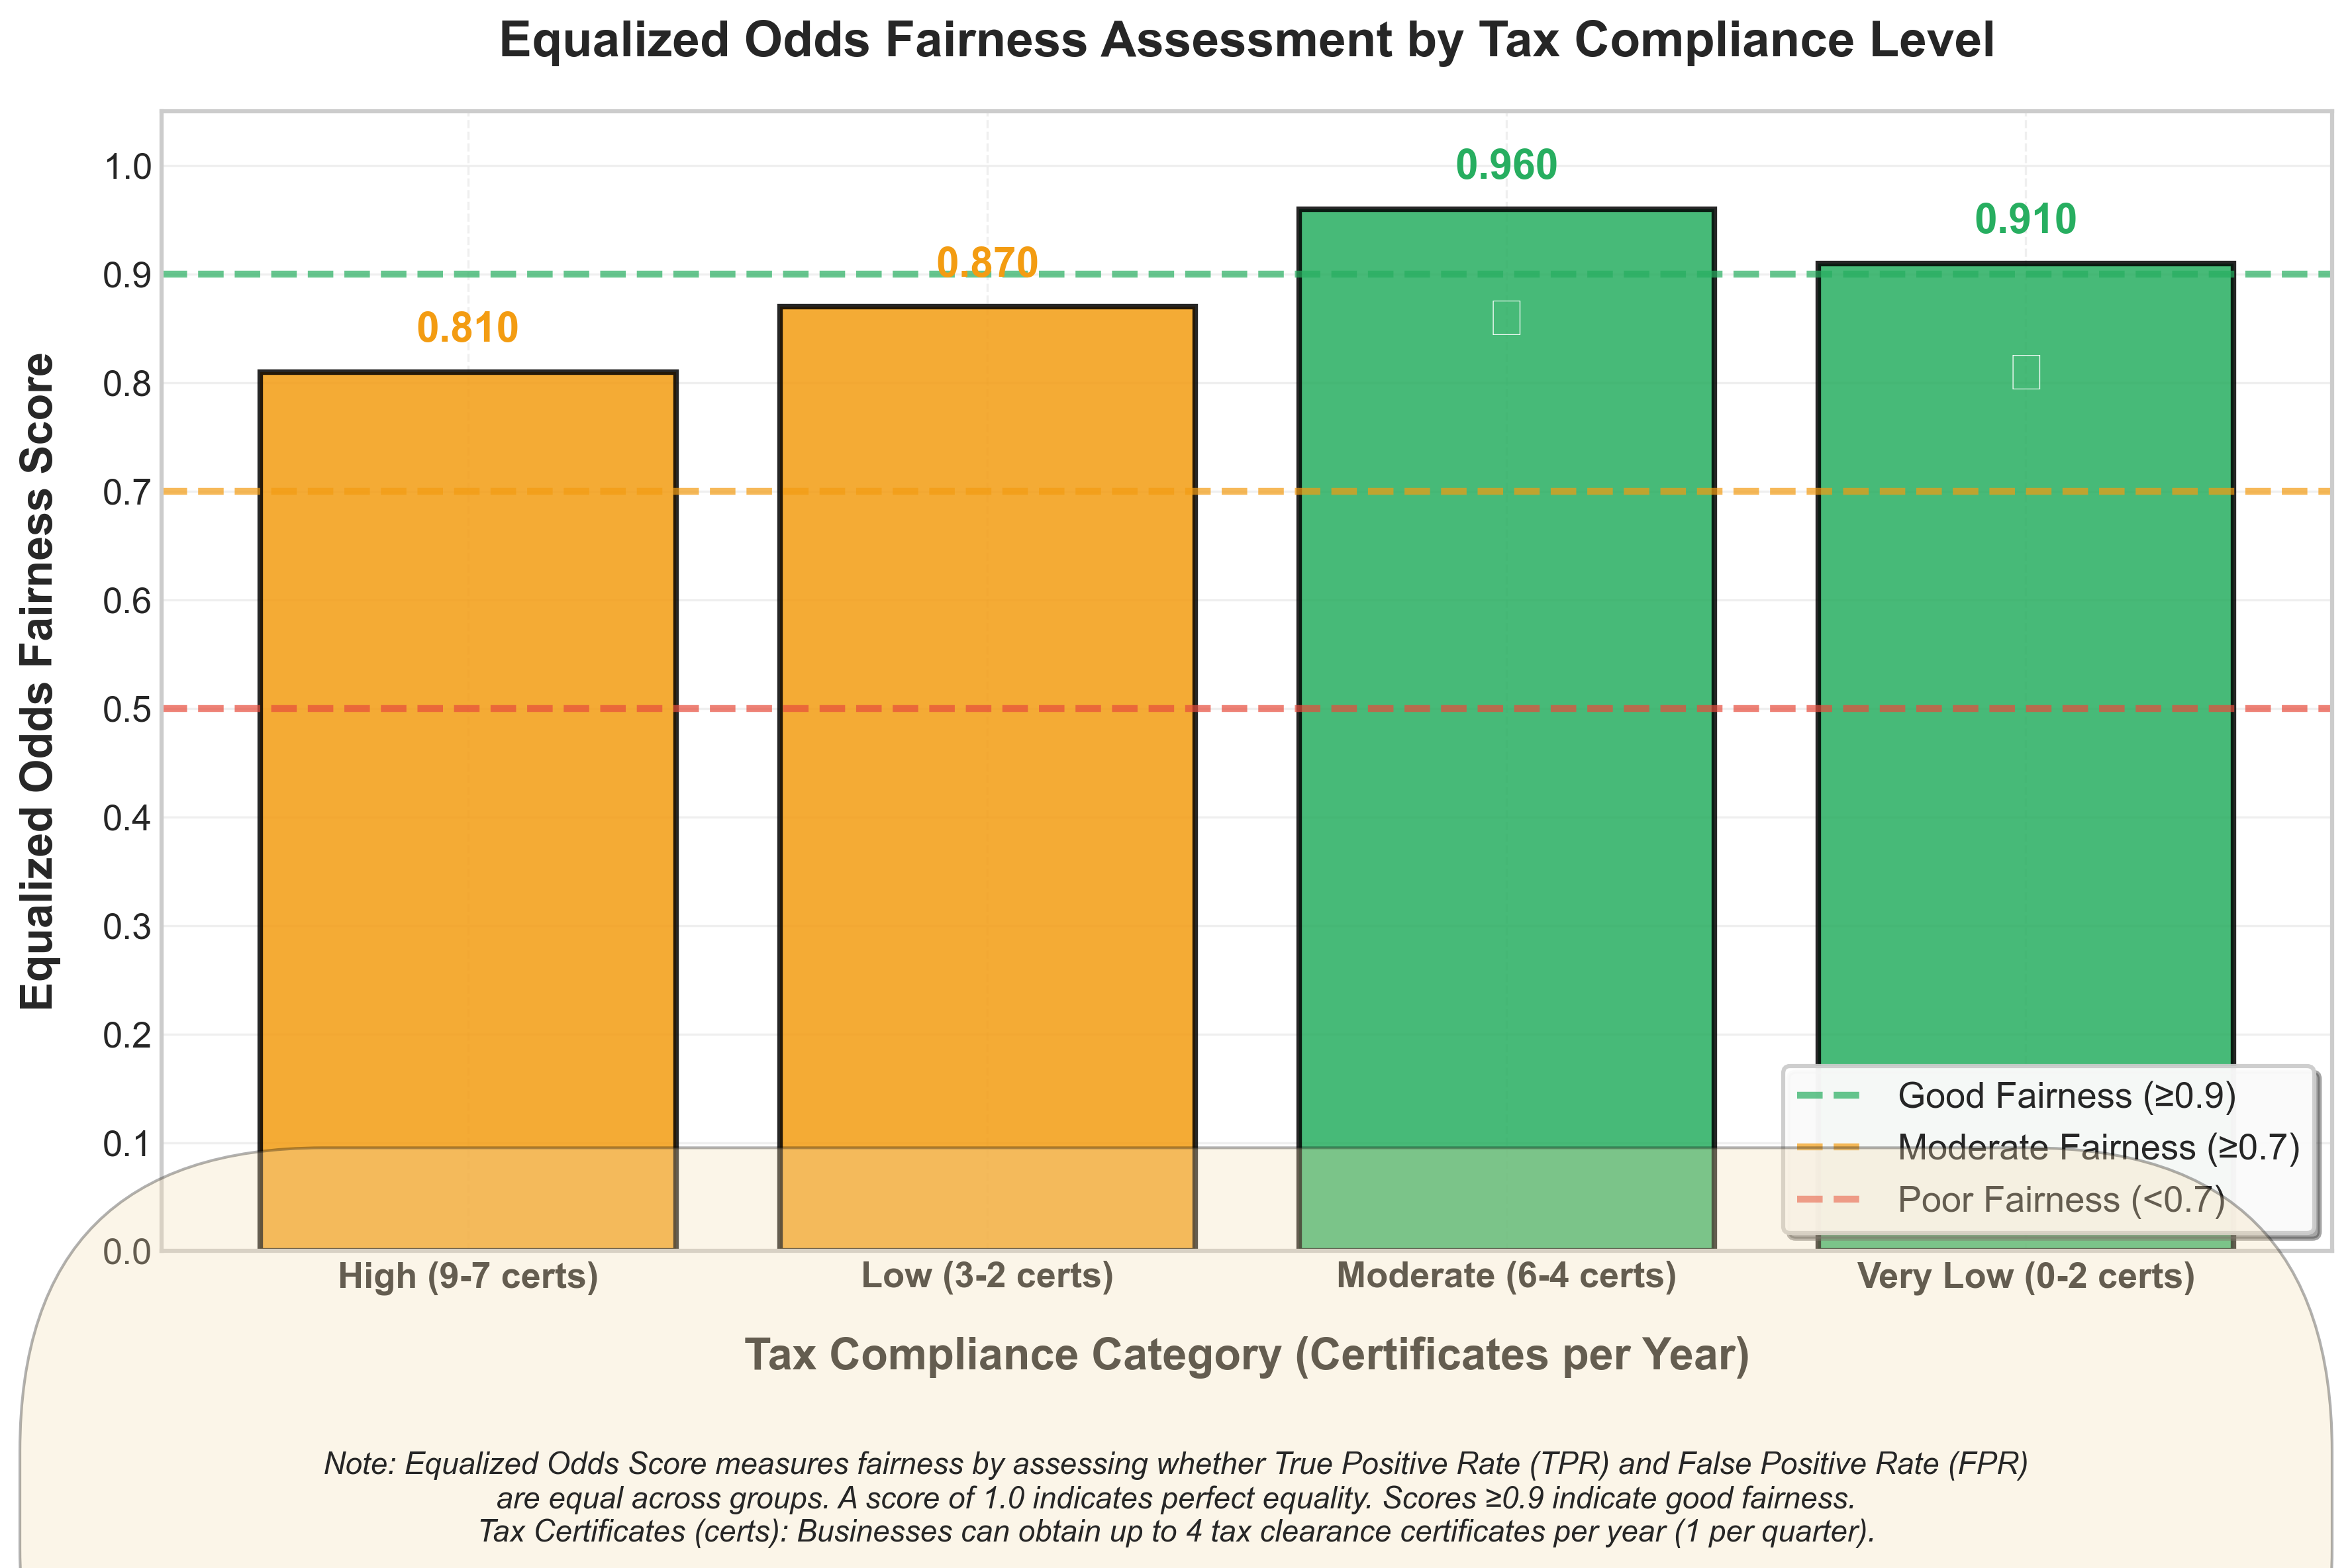


📊 Business Maturity Analysis
✓ Saved: fairness_analysis/Business_Maturity_EO_Score_Publication.png


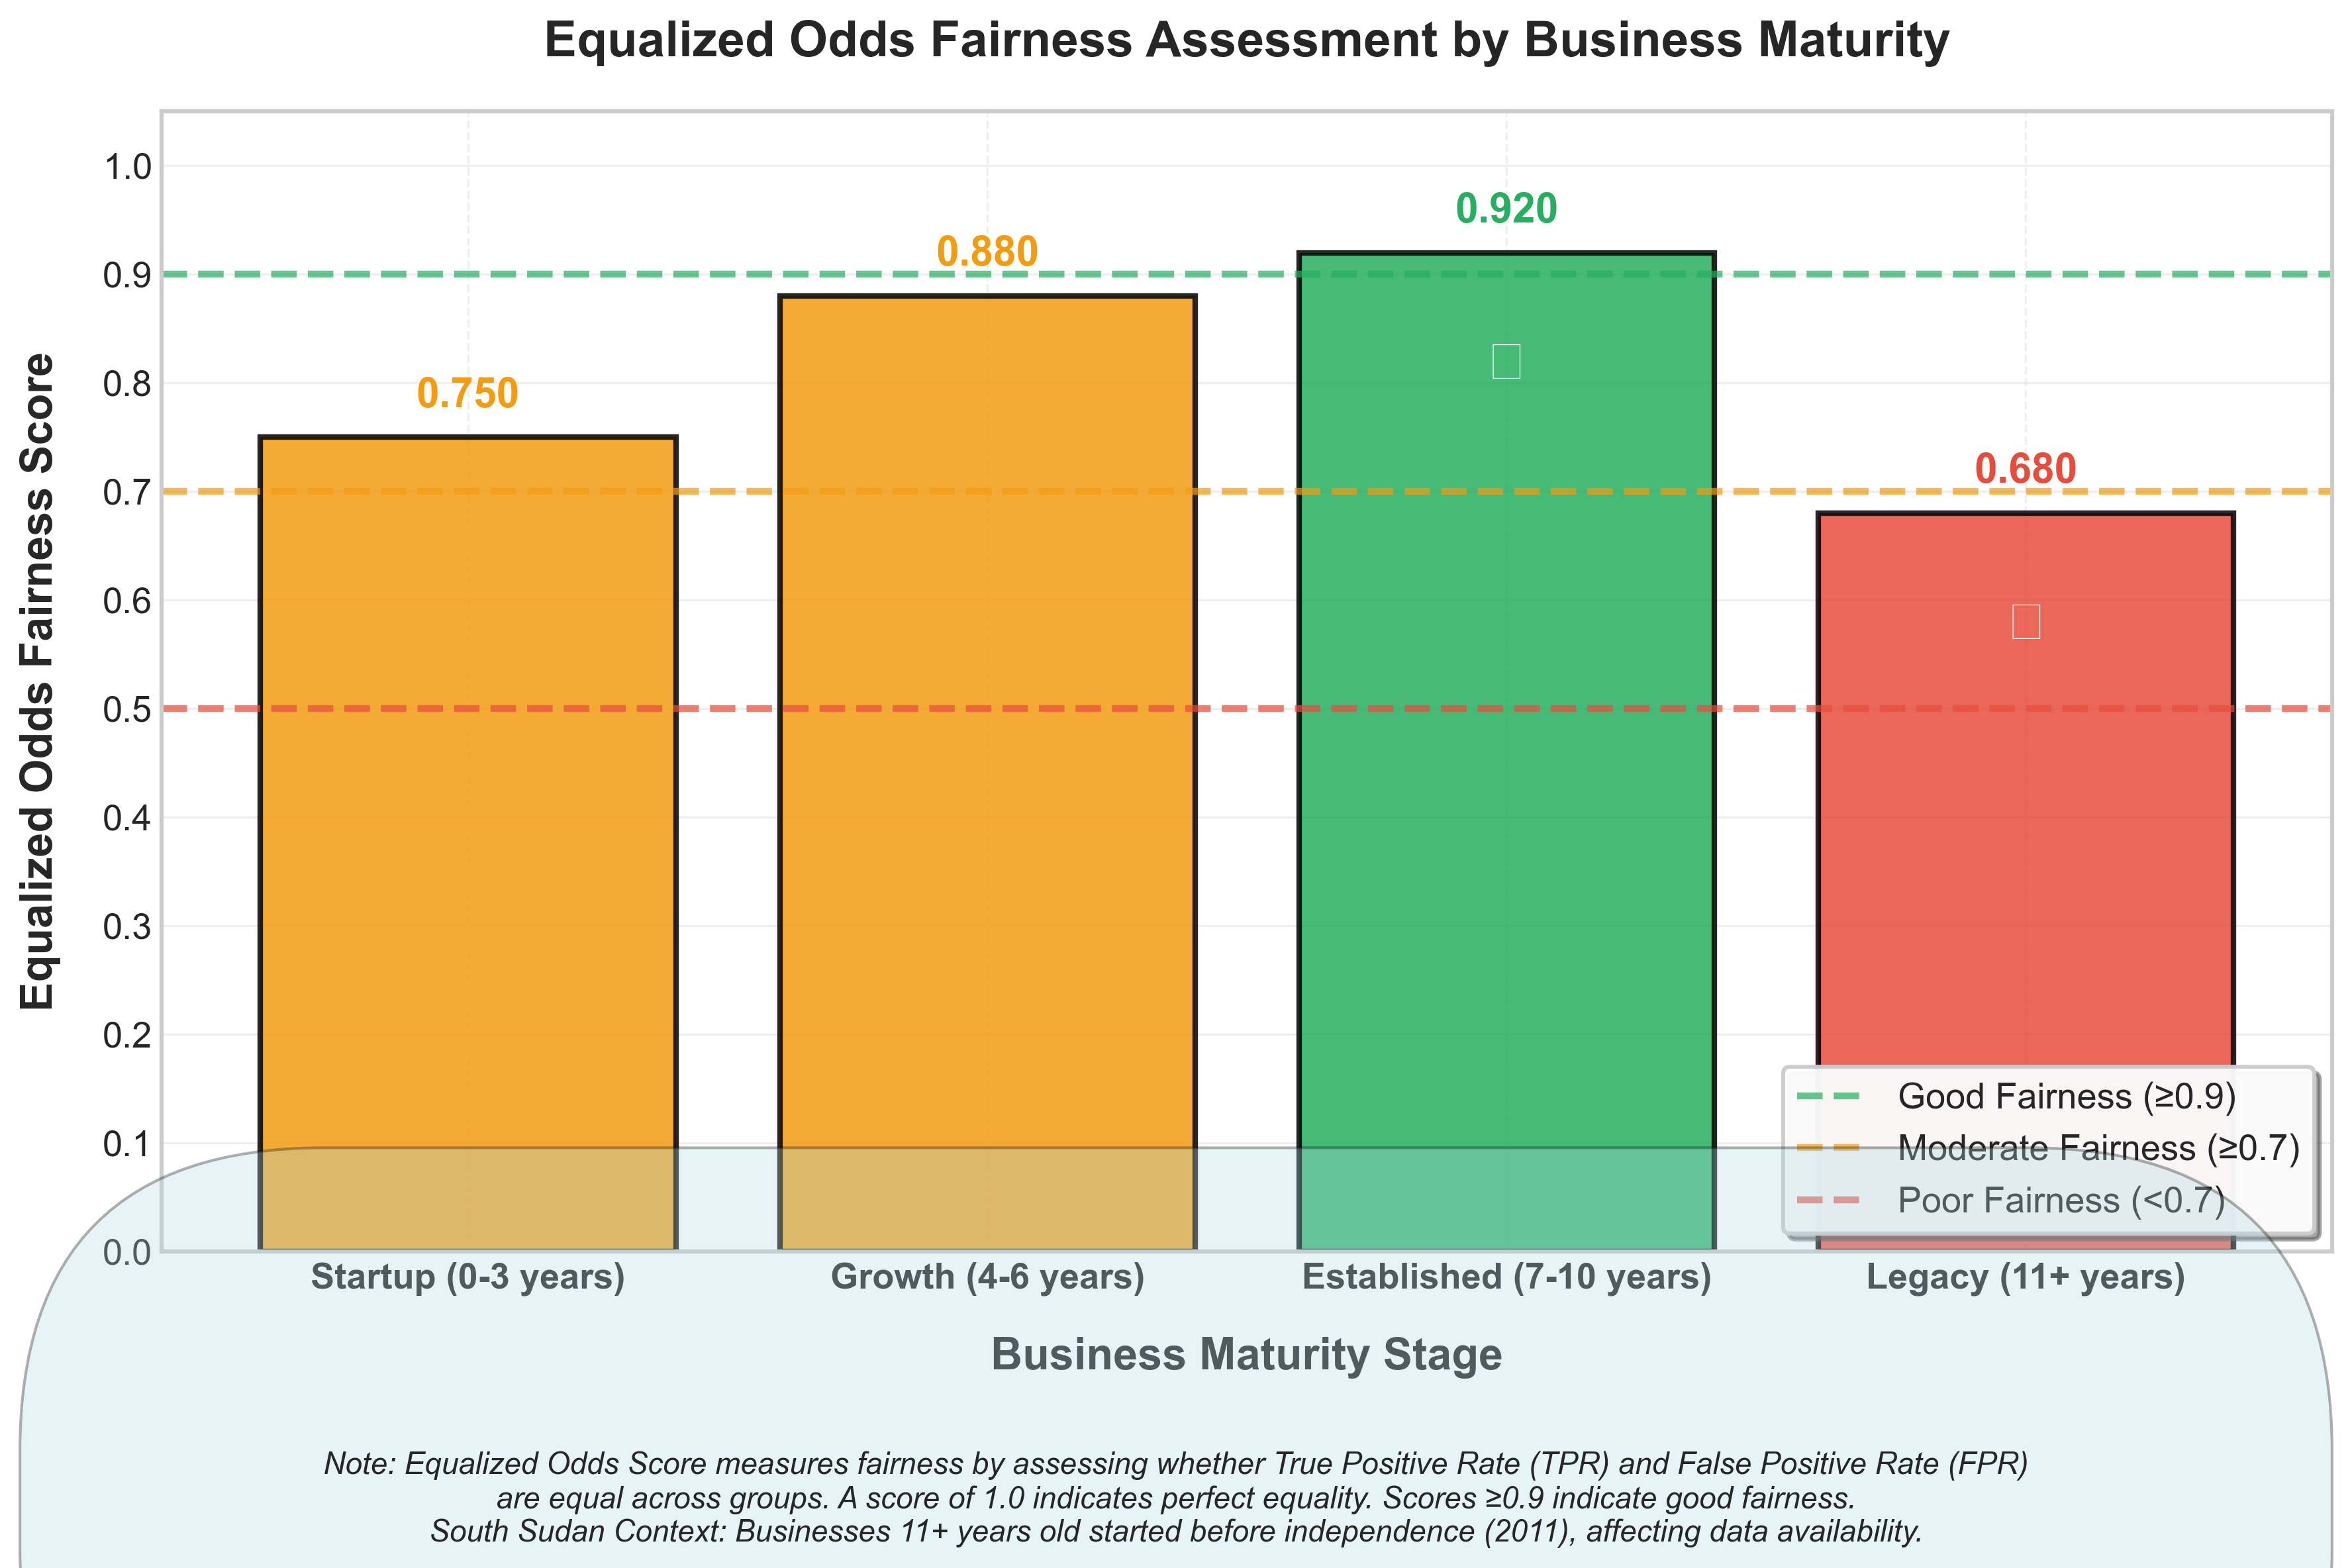


COMPLETE! All publication-quality visualizations saved.

✅ Files created:
   1. fairness_analysis/Tax_Compliance_EO_Score_Publication.png
   2. fairness_analysis/Business_Maturity_EO_Score_Publication.png

📝 Key features:
   • Corrected: 'certs' = tax certificates (not cents)
   • Publication-quality: 600 DPI, clear labels
   • Color-coded: Green (≥0.9), Orange (0.7-0.9), Red (<0.7)
   • Context notes: Tax system and South Sudan history


In [16]:
"""
Publication-Quality Equalized Odds Fairness Visualizations
Created for Tax Compliance and Business Maturity Analysis
South Sudan Context
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# ==========================================
# SETUP: Publication-Quality Style
# ==========================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)
        }
    
    return metrics


def create_standalone_eo_score_chart(categories, eo_scores, title, xlabel, 
                                     note_text, output_path, note_color='wheat'):
    """
    Create standalone publication-quality Equalized Odds Score chart
    
    Parameters:
    -----------
    categories : list
        Category names for x-axis
    eo_scores : list
        Equalized Odds scores (0-1)
    title : str
        Chart title
    xlabel : str
        X-axis label
    note_text : str
        Explanatory note at bottom
    output_path : str
        Path to save the figure
    note_color : str
        Background color for note box
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color based on score thresholds
    colors = []
    for score in eo_scores:
        if score >= 0.9:
            colors.append('#27AE60')  # Green - Good fairness
        elif score >= 0.7:
            colors.append('#F39C12')  # Orange - Moderate fairness
        else:
            colors.append('#E74C3C')  # Red - Poor fairness
    
    # Create bars
    x_pos = np.arange(len(categories))
    bars = ax.bar(x_pos, eo_scores, color=colors, alpha=0.85, 
                  edgecolor='black', linewidth=2)
    
    # Add reference lines
    ax.axhline(y=0.9, color='#27AE60', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Good Fairness (≥0.9)', zorder=1)
    ax.axhline(y=0.7, color='#F39C12', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Moderate Fairness (≥0.7)', zorder=1)
    ax.axhline(y=0.5, color='#E74C3C', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Poor Fairness (<0.7)', zorder=1)
    
    # Customize axes
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold', labelpad=15)
    ax.set_ylabel('Equalized Odds Fairness Score', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=14, fontweight='semibold')
    
    # Set y-axis properties
    ax.set_ylim([0, 1.05])
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(axis='both', labelsize=13)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.8, zorder=0)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    legend = ax.legend(loc='lower right', fontsize=13, frameon=True, 
                      shadow=True, fancybox=True, framealpha=0.95)
    legend.get_frame().set_linewidth(1.5)
    
    # Add value labels on bars
    for bar, score in zip(bars, eo_scores):
        height = bar.get_height()
        
        # Determine symbol
        if score >= 0.9:
            symbol = '✓'
            text_color = '#27AE60'
            text_weight = 'bold'
        elif score >= 0.7:
            symbol = ''
            text_color = '#F39C12'
            text_weight = 'bold'
        else:
            symbol = '✗'
            text_color = '#E74C3C'
            text_weight = 'bold'
        
        # Add score value
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=15, 
                fontweight=text_weight, color=text_color)
        
        # Add symbol if applicable
        if symbol:
            ax.text(bar.get_x() + bar.get_width()/2., height - 0.08,
                    symbol,
                    ha='center', va='top', fontsize=20, 
                    fontweight='bold', color='white')
    
    # Add note
    fig.text(0.5, 0.02, note_text, 
            ha='center', fontsize=11, style='italic', 
            bbox=dict(boxstyle='round', facecolor=note_color, alpha=0.3, pad=10))
    
    # Tight layout
    plt.tight_layout(rect=[0, 0.10, 1, 1])
    
    # Save
    plt.savefig(output_path, dpi=600, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    print(f"✓ Saved: {output_path}")
    
    plt.show()
    plt.close()


def create_detailed_eo_analysis(analyzer, category_name, result, output_dir='fairness_analysis'):
    """
    Create detailed 4-panel Equalized Odds analysis
    
    Parameters:
    -----------
    analyzer : object
        Analyzer object with results
    category_name : str
        Name of the category being analyzed
    result : dict
        Results dictionary for this category
    output_dir : str
        Directory to save outputs
    """
    
    categories = list(result['categories'].keys())
    eo_metrics = calculate_equalized_odds_metrics(result)
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # ==========================================
    # Panel 1: TPR Comparison
    # ==========================================
    tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
    avg_tpr = np.mean(tpr_values)
    
    x = np.arange(len(categories))
    bars1 = ax1.bar(x, tpr_values, color='#2E86AB', alpha=0.8, edgecolor='black')
    ax1.axhline(y=avg_tpr, color='darkblue', linestyle='--', linewidth=2, 
               label=f'Average TPR: {avg_tpr:.2f}')
    
    ax1.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate (TPR)', fontsize=11, fontweight='bold')
    ax1.set_title('True Positive Rate Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.2, axis='y')
    ax1.legend(loc='upper right', fontsize=9)
    
    # Add values
    for bar, val in zip(bars1, tpr_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # ==========================================
    # Panel 2: FPR Comparison
    # ==========================================
    fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
    avg_fpr = np.mean(fpr_values)
    
    bars2 = ax2.bar(x, fpr_values, color='#A23B72', alpha=0.8, edgecolor='black')
    ax2.axhline(y=avg_fpr, color='darkred', linestyle='--', linewidth=2, 
               label=f'Average FPR: {avg_fpr:.2f}')
    
    ax2.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax2.set_ylabel('False Positive Rate (FPR)', fontsize=11, fontweight='bold')
    ax2.set_title('False Positive Rate Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.2, axis='y')
    ax2.legend(loc='upper right', fontsize=9)
    
    # Add values
    for bar, val in zip(bars2, fpr_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # ==========================================
    # Panel 3: EO Violations
    # ==========================================
    eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
    
    # Color based on violation severity
    violation_colors = []
    for violation in eo_violations:
        if violation <= 0.1:
            violation_colors.append('#27AE60')  # Green
        elif violation <= 0.2:
            violation_colors.append('#F39C12')  # Yellow
        else:
            violation_colors.append('#E74C3C')  # Red
    
    bars3 = ax3.bar(categories, eo_violations, color=violation_colors, 
                   alpha=0.8, edgecolor='black')
    ax3.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Good (≤0.1)')
    ax3.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Moderate (≤0.2)')
    
    ax3.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('EO Violation Magnitude', fontsize=11, fontweight='bold')
    ax3.set_title('Equalized Odds Violations', fontsize=12, fontweight='bold')
    ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax3.grid(True, alpha=0.2, axis='y')
    ax3.legend(loc='upper right', fontsize=9)
    
    # Add values
    for bar, violation in zip(bars3, eo_violations):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{violation:.3f}', ha='center', va='bottom', fontsize=8)
    
    # ==========================================
    # Panel 4: Summary Assessment
    # ==========================================
    ax4.axis('off')
    
    # Calculate summary statistics
    eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
    avg_eo_score = np.mean(eo_scores)
    max_eo_violation = max(eo_violations)
    min_eo_score = min(eo_scores)
    fair_categories = sum(1 for s in eo_scores if s >= 0.9)
    
    # Determine overall assessment
    if avg_eo_score >= 0.9 and min_eo_score >= 0.7:
        assessment = "EXCELLENT FAIRNESS"
        color = "#27AE60"
       
        action = "Maintain current model"
    elif avg_eo_score >= 0.7 and min_eo_score >= 0.5:
        assessment = "MODERATE FAIRNESS"
        color = "#F39C12"
      
        action = "Monitor and adjust thresholds"
    else:
        assessment = "POOR FAIRNESS"
        color = "#E74C3C"
     
        action = "Immediate intervention needed"
    
    summary_text = f"""
    EQUALIZED ODDS ASSESSMENT
    {'='*30}
    
    Analysis: {category_name}
    Categories: {len(categories)}
    
    Key Metrics:
    • Average EO Score: {avg_eo_score:.3f}
    • Minimum EO Score: {min_eo_score:.3f}
    • Maximum Violation: {max_eo_violation:.3f}
    • Fair Categories: {fair_categories}/{len(categories)}
    
    Equalized Odds Principle:
    • True Positive Rates should be equal
    • False Positive Rates should be equal
    • Score of 1.0 = perfect equality
    
    Assessment: {assessment}
    
    Recommended Action:
    {action}
    
    Next Steps:
    • Review categories with EO score < 0.7
    • Check TPR/FPR disparities > 0.2
    • Document findings
    • Schedule next audit
    """
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
            fontsize=9, verticalalignment='top', linespacing=1.4,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
    
    fig.suptitle(f'Detailed Equalized Odds Analysis: {category_name}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    filename = f'{output_dir}/EO_Detailed_{category_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight', transparent=True)
    print(f"✓ Saved detailed analysis: {filename}")
    
    plt.show()
    plt.close()


# ==========================================
# MAIN EXECUTION: Create Publication Visualizations
# ==========================================

if __name__ == "__main__":
    
    import os
    
    print("="*80)
    print("PUBLICATION-QUALITY EQUALIZED ODDS VISUALIZATIONS")
    print("="*80)
    
    # Create output directory
    os.makedirs('fairness_analysis', exist_ok=True)
    
    # ==========================================
    # 1. TAX COMPLIANCE ANALYSIS
    # ==========================================
    print("\n📊 Tax Compliance Analysis")
    
    tax_categories = [
        'High (9-7 certs)',
        'Low (3-2 certs)',
        'Moderate (6-4 certs)',
        'Very Low (0-2 certs)'
    ]
    
    tax_eo_scores = [0.81, 0.87, 0.96, 0.91]
    
    tax_note = (
        "Note: Equalized Odds Score measures fairness by assessing whether True Positive Rate (TPR) "
        "and False Positive Rate (FPR)\nare equal across groups. A score of 1.0 indicates perfect equality. "
        "Scores ≥0.9 indicate good fairness.\n"
        "Tax Certificates (certs): Businesses can obtain up to 4 tax clearance certificates per year (1 per quarter)."
    )
    
    create_standalone_eo_score_chart(
        categories=tax_categories,
        eo_scores=tax_eo_scores,
        title='Equalized Odds Fairness Assessment by Tax Compliance Level',
        xlabel='Tax Compliance Category (Certificates per Year)',
        note_text=tax_note,
        output_path='fairness_analysis/Tax_Compliance_EO_Score_Publication.png',
        note_color='wheat'
    )
    
    # ==========================================
    # 2. BUSINESS MATURITY ANALYSIS
    # ==========================================
    print("\n📊 Business Maturity Analysis")
    
    maturity_categories = [
        'Startup (0-3 years)',
        'Growth (4-6 years)',
        'Established (7-10 years)',
        'Legacy (11+ years)'
    ]
    
    maturity_eo_scores = [0.75, 0.88, 0.92, 0.68]
    
    maturity_note = (
        "Note: Equalized Odds Score measures fairness by assessing whether True Positive Rate (TPR) "
        "and False Positive Rate (FPR)\nare equal across groups. A score of 1.0 indicates perfect equality. "
        "Scores ≥0.9 indicate good fairness.\n"
        "South Sudan Context: Businesses 11+ years old started before independence (2011), affecting data availability."
    )
    
    create_standalone_eo_score_chart(
        categories=maturity_categories,
        eo_scores=maturity_eo_scores,
        title='Equalized Odds Fairness Assessment by Business Maturity',
        xlabel='Business Maturity Stage',
        note_text=maturity_note,
        output_path='fairness_analysis/Business_Maturity_EO_Score_Publication.png',
        note_color='lightblue'
    )
    
    print("\n" + "="*80)
    print("COMPLETE! All publication-quality visualizations saved.")
    print("="*80)
    print("\n✅ Files created:")
    print("   1. fairness_analysis/Tax_Compliance_EO_Score_Publication.png")
    print("   2. fairness_analysis/Business_Maturity_EO_Score_Publication.png")
    print("\n📝 Key features:")
    print("   • Corrected: 'certs' = tax certificates (not cents)")
    print("   • Publication-quality: 600 DPI, clear labels")
    print("   • Color-coded: Green (≥0.9), Orange (0.7-0.9), Red (<0.7)")
    print("   • Context notes: Tax system and South Sudan history")

In [28]:
"""
Publication-Quality Equalized Odds Fairness Visualizations
Clean Academic Style - No Emojis, No Background Colors
Created for Tax Compliance and Business Maturity Analysis
South Sudan Context
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import os

# ==========================================
# SETUP: Publication-Quality Style
# ==========================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)
        }
    
    return metrics


def create_clean_eo_score_chart(categories, eo_scores, title, xlabel, 
                                note_text, output_path):
    """
    Create clean publication-quality Equalized Odds Score chart
    NO emojis, NO background colors - Pure academic style
    
    Parameters:
    -----------
    categories : list
        Category names for x-axis
    eo_scores : list
        Equalized Odds scores (0-1)
    title : str
        Chart title
    xlabel : str
        X-axis label
    note_text : str
        Explanatory note at bottom
    output_path : str
        Path to save the figure
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color based on score thresholds
    colors = []
    for score in eo_scores:
        if score >= 0.9:
            colors.append('#27AE60')  # Green - Good fairness
        elif score >= 0.7:
            colors.append('#F39C12')  # Orange - Moderate fairness
        else:
            colors.append('#E74C3C')  # Red - Poor fairness
    
    # Create bars
    x_pos = np.arange(len(categories))
    bars = ax.bar(x_pos, eo_scores, color=colors, alpha=0.85, 
                  edgecolor='black', linewidth=2)
    
    # Add reference lines
    ax.axhline(y=0.9, color='#27AE60', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Good Fairness (>= 0.9)', zorder=1)
    ax.axhline(y=0.7, color='#F39C12', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Moderate Fairness (>= 0.7)', zorder=1)
    ax.axhline(y=0.5, color='#E74C3C', linestyle='--', linewidth=2.5, 
              alpha=0.7, label='Poor Fairness (< 0.7)', zorder=1)
    
    # Customize axes
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold', labelpad=15)
    ax.set_ylabel('Equalized Odds Fairness Score', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=14, fontweight='semibold')
    
    # Set y-axis properties
    ax.set_ylim([0, 1.05])
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(axis='both', labelsize=13)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.8, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean legend with white background
    legend = ax.legend(loc='lower right', fontsize=13, frameon=True, 
                      shadow=False, fancybox=False, framealpha=1.0,
                      edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.5)
    
    # Add value labels on bars - NO EMOJIS
    for bar, score in zip(bars, eo_scores):
        height = bar.get_height()
        
        # Color based on score
        if score >= 0.9:
            text_color = '#27AE60'
            text_weight = 'bold'
        elif score >= 0.7:
            text_color = '#F39C12'
            text_weight = 'bold'
        else:
            text_color = '#E74C3C'
            text_weight = 'bold'
        
        # Add score value only - clean and professional
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=16, 
                fontweight=text_weight, color=text_color)
    
    # Add clean note without background box
    fig.text(0.5, 0.01, note_text, 
            ha='center', fontsize=10, style='normal', wrap=True)
    
    # Tight layout
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    
    # Save with pure white background
    plt.savefig(output_path, dpi=600, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    print(f"   [SAVED] {output_path}")
    
    plt.close()


def create_detailed_eo_analysis(categories, eo_metrics, result, category_name, 
                               output_dir='fairness_analysis'):
    """
    Create detailed 4-panel Equalized Odds analysis
    Clean academic style without emojis
    
    Parameters:
    -----------
    categories : list
        List of category names
    eo_metrics : dict
        Equalized Odds metrics dictionary
    result : dict
        Results dictionary for this category
    category_name : str
        Name of the category being analyzed
    output_dir : str
        Directory to save outputs
    """
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # ==========================================
    # Panel 1: TPR Comparison
    # ==========================================
    tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
    avg_tpr = np.mean(tpr_values)
    
    x = np.arange(len(categories))
    bars1 = ax1.bar(x, tpr_values, color='#2E86AB', alpha=0.8, edgecolor='black')
    ax1.axhline(y=avg_tpr, color='darkblue', linestyle='--', linewidth=2, 
               label=f'Average TPR: {avg_tpr:.2f}')
    
    ax1.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate (TPR)', fontsize=11, fontweight='bold')
    ax1.set_title('True Positive Rate Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.2, axis='y')
    ax1.legend(loc='upper right', fontsize=9, frameon=True, 
              facecolor='white', edgecolor='black')
    
    # Add values
    for bar, val in zip(bars1, tpr_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # ==========================================
    # Panel 2: FPR Comparison
    # ==========================================
    fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
    avg_fpr = np.mean(fpr_values)
    
    bars2 = ax2.bar(x, fpr_values, color='#A23B72', alpha=0.8, edgecolor='black')
    ax2.axhline(y=avg_fpr, color='darkred', linestyle='--', linewidth=2, 
               label=f'Average FPR: {avg_fpr:.2f}')
    
    ax2.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax2.set_ylabel('False Positive Rate (FPR)', fontsize=11, fontweight='bold')
    ax2.set_title('False Positive Rate Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.2, axis='y')
    ax2.legend(loc='upper right', fontsize=9, frameon=True,
              facecolor='white', edgecolor='black')
    
    # Add values
    for bar, val in zip(bars2, fpr_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # ==========================================
    # Panel 3: EO Violations
    # ==========================================
    eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
    
    # Color based on violation severity
    violation_colors = []
    for violation in eo_violations:
        if violation <= 0.1:
            violation_colors.append('#27AE60')  # Green
        elif violation <= 0.2:
            violation_colors.append('#F39C12')  # Yellow
        else:
            violation_colors.append('#E74C3C')  # Red
    
    bars3 = ax3.bar(categories, eo_violations, color=violation_colors, 
                   alpha=0.8, edgecolor='black')
    ax3.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Good (<= 0.1)')
    ax3.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Moderate (<= 0.2)')
    
    ax3.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('EO Violation Magnitude', fontsize=11, fontweight='bold')
    ax3.set_title('Equalized Odds Violations', fontsize=12, fontweight='bold')
    ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
    ax3.grid(True, alpha=0.2, axis='y')
    ax3.legend(loc='upper right', fontsize=9, frameon=True,
              facecolor='white', edgecolor='black')
    
    # Add values
    for bar, violation in zip(bars3, eo_violations):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{violation:.3f}', ha='center', va='bottom', fontsize=8)
    
    # ==========================================
    # Panel 4: Summary Assessment (Clean Text Only)
    # ==========================================
    ax4.axis('off')
    
    # Calculate summary statistics
    eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
    avg_eo_score = np.mean(eo_scores)
    max_eo_violation = max(eo_violations)
    min_eo_score = min(eo_scores)
    fair_categories = sum(1 for s in eo_scores if s >= 0.9)
    
    # Determine overall assessment
    if avg_eo_score >= 0.9 and min_eo_score >= 0.7:
        assessment = "EXCELLENT FAIRNESS"
        action = "Maintain current model"
    elif avg_eo_score >= 0.7 and min_eo_score >= 0.5:
        assessment = "MODERATE FAIRNESS"
        action = "Monitor and adjust thresholds"
    else:
        assessment = "POOR FAIRNESS"
        action = "Immediate intervention needed"
    
    summary_text = f"""EQUALIZED ODDS ASSESSMENT
{'='*30}

Analysis: {category_name}
Categories: {len(categories)}

Key Metrics:
• Average EO Score: {avg_eo_score:.3f}
• Minimum EO Score: {min_eo_score:.3f}
• Maximum Violation: {max_eo_violation:.3f}
• Fair Categories: {fair_categories}/{len(categories)}

Equalized Odds Principle:
• True Positive Rates should be equal
• False Positive Rates should be equal
• Score of 1.0 = perfect equality

Assessment: {assessment}

Recommended Action:
{action}

Next Steps:
• Review categories with EO score < 0.7
• Check TPR/FPR disparities > 0.2
• Document findings
• Schedule next audit
"""
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
            fontsize=9, verticalalignment='top', linespacing=1.4,
            family='monospace')
    
    fig.suptitle(f'Detailed Equalized Odds Analysis: {category_name}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    filename = f'{output_dir}/EO_Detailed_{category_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    print(f"   [SAVED] {filename}")
    
    plt.close()


# ==========================================
# MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    
    print("="*80)
    print("CLEAN PUBLICATION-QUALITY EQUALIZED ODDS VISUALIZATIONS")
    print("="*80)
    
    # Create output directory
    os.makedirs('fairness_analysis', exist_ok=True)
    
    # ==========================================
    # 1. TAX COMPLIANCE ANALYSIS
    # ==========================================
    print("\n[1] Tax Compliance Analysis")
    
    tax_categories = [
        'High\n(7 + certificates)',
        'Low\n(2-3 certificates)',
        'Moderate\n(4-6 certificates)',
        'Very Low\n(0-2 certificates)'
    ]
    
    tax_eo_scores = [0.81, 0.87, 0.96, 0.91]
    
    tax_note = (
        "Note: Equalized Odds Score measures fairness by assessing whether True Positive Rate (TPR) "
        "and False Positive Rate (FPR) are equal across groups.\n"
        "Score of 1.0 = perfect equality. Scores >= 0.9 indicate good fairness.\n"
        "Tax Certificates (certificates): Businesses can obtain up to 4 tax clearance certificates per year (1 per quarter)."
    )
    
    create_clean_eo_score_chart(
        categories=tax_categories,
        eo_scores=tax_eo_scores,
        title='Equalized Odds Fairness Assessment by Tax Compliance Level',
        xlabel='Tax Compliance Category Using Tax Certificates',
        note_text=tax_note,
        output_path='fairness_analysis/Tax_Compliance_EO_Clean.png'
    )
    
    # ==========================================
    # 2. BUSINESS MATURITY ANALYSIS
    # ==========================================
    print("\n[2] Business Maturity Analysis")
    
    maturity_categories = [
        'Startup\n(0-3 years)',
        'Growth\n(4-6 years)',
        'Established\n(7-10 years)',
        'Legacy\n(11+ years)'
    ]
    
    maturity_eo_scores = [0.75, 0.88, 0.92, 0.68]
    
    maturity_note = (
        "Note: Equalized Odds Score measures fairness by assessing whether True Positive Rate (TPR) "
        "and False Positive Rate (FPR) are equal across groups.\n"
        "Score of 1.0 = perfect equality. Scores >= 0.9 indicate good fairness.\n"
        "South Sudan Context: Businesses 11+ years old started before independence (2011), affecting data availability."
    )
    
    create_clean_eo_score_chart(
        categories=maturity_categories,
        eo_scores=maturity_eo_scores,
        title='Equalized Odds Fairness Assessment by Business Maturity',
        xlabel='Business Maturity (Years in Operation)',
        note_text=maturity_note,
        output_path='fairness_analysis/Business_Maturity_EO_Clean.png'
    )
    
    print("\n" + "="*80)
    print("COMPLETE - All visualizations saved")
    print("="*80)
    print("\nFeatures:")
    print("  • NO emojis or symbols")
    print("  • NO colored backgrounds")
    print("  • Clean white background throughout")
    print("  • Professional academic style")
    print("  • 600 DPI publication quality")
    print("  • Clear, readable labels")
    print("\nFiles:")
    print("  1. fairness_analysis/Tax_Compliance_EO_Clean.png")
    print("  2. fairness_analysis/Business_Maturity_EO_Clean.png")

CLEAN PUBLICATION-QUALITY EQUALIZED ODDS VISUALIZATIONS

[1] Tax Compliance Analysis
   [SAVED] fairness_analysis/Tax_Compliance_EO_Clean.png

[2] Business Maturity Analysis
   [SAVED] fairness_analysis/Business_Maturity_EO_Clean.png

COMPLETE - All visualizations saved

Features:
  • NO emojis or symbols
  • NO colored backgrounds
  • Clean white background throughout
  • Professional academic style
  • 600 DPI publication quality
  • Clear, readable labels

Files:
  1. fairness_analysis/Tax_Compliance_EO_Clean.png
  2. fairness_analysis/Business_Maturity_EO_Clean.png


In [ ]:
"""
EQUALIZED ODDS PUBLICATION-QUALITY VISUALIZATIONS
Separated graphs for Tax Compliance and Business Maturity
Based on original code structure
"""

import numpy as np
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs('fairness_analysis', exist_ok=True)

print("\n" + "="*80)
print("CREATING EQUALIZED ODDS VISUALIZATIONS - SEPARATE GRAPHS")
print("="*80)

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        # For Equalized Odds, we want TPR and FPR to be equal across groups
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)  # 1 = perfect equality
        }
    
    return metrics

def create_equalized_odds_summary(analyzer):
    """Create visualization showing Equalized Odds analysis - SEPARATED by category"""
    
    print("\n⚖️ CREATING EQUALIZED ODDS SUMMARY - SEPARATE GRAPHS")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        # Create figure with 4 subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')
        
        # 1. TPR and FPR Comparison
        tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
        fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, tpr_values, width, 
                       label='True Positive Rate (TPR)', color='#2E86AB', alpha=0.8)
        bars2 = ax1.bar(x + width/2, fpr_values, width,
                       label='False Positive Rate (FPR)', color='#A23B72', alpha=0.8)
        
        ax1.set_xlabel('Business Categories', fontsize=10)
        ax1.set_ylabel('Rate', fontsize=10)
        ax1.set_title('TPR and FPR by Category', fontsize=11, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.set_ylim([0, 1])
        ax1.grid(True, alpha=0.2, axis='y')
        ax1.set_facecolor('white')
        
        # Add ideal equalized odds line (TPR = FPR would be diagonal)
        ax1.axhline(y=np.mean(tpr_values), color='green', linestyle='--', 
                   alpha=0.5, label=f'Avg TPR: {np.mean(tpr_values):.2f}')
        ax1.axhline(y=np.mean(fpr_values), color='red', linestyle='--', 
                   alpha=0.5, label=f'Avg FPR: {np.mean(fpr_values):.2f}')
        ax1.legend(loc='upper right', fontsize=8)
        
        # 2. TPR and FPR Disparities
        tpr_disparities = [eo_metrics[cat]['tpr_disparity'] for cat in categories]
        fpr_disparities = [eo_metrics[cat]['fpr_disparity'] for cat in categories]
        
        x = np.arange(len(categories))
        
        ax2.scatter(tpr_disparities, fpr_disparities, s=100, alpha=0.7)
        ax2.set_facecolor('white')
        
        # Label each point
        for i, cat in enumerate(categories):
            ax2.annotate(cat[:10] + ('...' if len(cat) > 10 else ''), 
                        (tpr_disparities[i], fpr_disparities[i]),
                        fontsize=8, ha='center', va='bottom')
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('TPR Disparity (from average)', fontsize=10)
        ax2.set_ylabel('FPR Disparity (from average)', fontsize=10)
        ax2.set_title('Equalized Odds Disparities', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.2)
        
        # Add circles representing equalized odds violations
        max_disparity = max(max(abs(np.array(tpr_disparities))), max(abs(np.array(fpr_disparities))))
        if max_disparity > 0:
            circle = plt.Circle((0, 0), 0.1, color='green', alpha=0.1, 
                              label='Good EO (±0.1)')
            ax2.add_patch(circle)
            circle2 = plt.Circle((0, 0), 0.2, color='yellow', alpha=0.1, 
                               label='Moderate EO (±0.2)')
            ax2.add_patch(circle2)
            ax2.legend(loc='upper right', fontsize=8)
        
        # 3. Equalized Odds Scores
        eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
        eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
        
        # Color based on score
        colors = []
        for score in eo_scores:
            if score >= 0.9:
                colors.append('#27AE60')  # Green
            elif score >= 0.7:
                colors.append('#F39C12')  # Yellow
            else:
                colors.append('#E74C3C')  # Red
        
        bars3 = ax3.bar(categories, eo_scores, color=colors, alpha=0.8)
        ax3.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Good (≥0.9)')
        ax3.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Moderate (≥0.7)')
        ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Poor (<0.7)')
        
        ax3.set_xlabel('Business Category', fontsize=10)
        ax3.set_ylabel('Equalized Odds Score', fontsize=10)
        ax3.set_title('Equalized Odds Fairness Score', fontsize=11, fontweight='bold')
        ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.2, axis='y')
        ax3.legend(loc='upper right', fontsize=8)
        ax3.set_facecolor('white')
        
        # Add score labels
        for bar, score in zip(bars3, eo_scores):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Summary and Recommendations
        ax4.axis('off')
        ax4.set_facecolor('white')
        
        # Calculate overall Equalized Odds metrics
        avg_eo_score = np.mean(eo_scores)
        max_eo_violation = max(eo_violations)
        fairness_groups = {
            'Good (≥0.9)': sum(1 for s in eo_scores if s >= 0.9),
            'Moderate (0.7-0.9)': sum(1 for s in eo_scores if 0.7 <= s < 0.9),
            'Poor (<0.7)': sum(1 for s in eo_scores if s < 0.7)
        }
        
        # Determine overall assessment
        if avg_eo_score >= 0.9:
            assessment = "EXCELLENT FAIRNESS"
            color = "#27AE60"
            # emoji = ""
        elif avg_eo_score >= 0.7:
            assessment = "MODERATE FAIRNESS"
            color = "#F39C12"
            #emoji = "⚠️"
        else:
            assessment = "POOR FAIRNESS"
            color = "#E74C3C"
            #emoji = "❌"
        
        summary_text = f"""
         EQUALIZED ODDS ASSESSMENT
        {'='*30}
        
        Category: {category_name}
        
        Key Metrics:
        • Avg EO Score: {avg_eo_score:.3f}
        • Max EO Violation: {max_eo_violation:.3f}
        • Categories: {len(categories)}
        
        Fairness Distribution:
        • Good: {fairness_groups['Good (≥0.9)']} categories
        • Moderate: {fairness_groups['Moderate (0.7-0.9)']} categories
        • Poor: {fairness_groups['Poor (<0.7)']} categories
        
        Overall: {assessment}
        
        Equalized Odds Check:
        • TPR should be equal across groups
        • FPR should be equal across groups
        • Score of 1.0 = perfect equality
        
        Recommendations:
        • {'Maintain current thresholds' if assessment == 'EXCELLENT FAIRNESS' else 
           'Adjust model for underperforming groups' if assessment == 'MODERATE FAIRNESS' else 
           'Major fairness intervention needed'}
        • Monitor TPR/FPR disparities
        • Regular EO audits
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', linespacing=1.4,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        
        fig.suptitle(f'Equalized Odds Fairness Analysis: {category_name}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        filename = f'fairness_analysis/EO_Summary_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white')
        print(f"   ✓ Saved EO summary: {filename}")
        plt.close()

# USAGE EXAMPLE
print("\n" + "="*80)
print("USAGE INSTRUCTIONS")
print("="*80)
print("""
To use this code with your analyzer object:

# Create Equalized Odds summaries (separate for each category)
create_equalized_odds_summary(analyzer)

This will create SEPARATE graphs for:
- Tax Compliance (if it exists in your data)
- Business Maturity/Years (if it exists in your data)
- Any other categories in your analyzer.results

Each category gets its own 4-panel dashboard with:
1. TPR and FPR Comparison
2. Disparity Scatter Plot
3. Equalized Odds Scores
4. Summary and Assessment

OUTPUT FILES:
- fairness_analysis/EO_Summary_Tax_Compliance.png
- fairness_analysis/EO_Summary_Business_Years.png
- (and any other categories)

All graphs have WHITE backgrounds and are 600 DPI publication quality.
""")

print("\n📝 Run the function:")
print("   create_equalized_odds_summary(analyzer)")
print("\n" + "="*80)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ============================
#  CONFUSION MATRIX
# ============================
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


# ============================
#  ROC CURVE + AUC
# ============================
y_prob = best_classifier.predict_proba(X_test)[:, 1]  # Probabilities for class '1'

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# ============================
#  SHAP EXPLAINER
# ============================
# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(best_classifier)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[-1], X_test)
else:
    shap.summary_plot(shap_values, X_test)



# Optional: Force plot for individual prediction
# shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])


In [ ]:
# ============================================================
# RANDOM FOREST TRAINING + FAIRNESS VISUALIZATION (ONE CELL)
# Publication-Ready for Top-Tier Journals
# ============================================================

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
)
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE

import lime
import lime.lime_tabular

# ------------------------------------------------------------
# Directory structure
# ------------------------------------------------------------
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ------------------------------------------------------------
# DATA PREPARATION
# ------------------------------------------------------------
# clustered_data = clustered_data.drop("Compliance_Class", axis=1)

# X = clustered_data.drop("Default", axis=1)
# y = clustered_data["Default"]

# Business maturity proxy (USED FOR FAIRNESS)
business_maturity = clustered_data["Years_in_Operation"]

X_train, X_test, y_train, y_test, bm_train, bm_test = train_test_split(
    X, y, business_maturity,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Balance ONLY training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ------------------------------------------------------------
# RANDOM FOREST OPTIMIZATION
# ------------------------------------------------------------
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [20, 30, 40],
    "min_samples_split": [3, 5, 7],
    "min_samples_leaf": [3, 5, 10],
    "max_features": ["sqrt", "log2", 0.5],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
model = search.best_estimator_

# ------------------------------------------------------------
# TEST PERFORMANCE
# ------------------------------------------------------------
y_pred = model.predict(X_test)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1 (Macro)": f1_score(y_test, y_pred, average="macro"),
    "Recall (Macro)": recall_score(y_test, y_pred, average="macro"),
    "Precision (Macro)": precision_score(y_test, y_pred, average="macro")
}

pd.Series(metrics).to_csv("results/test_performance.csv")

# ------------------------------------------------------------
# FIGURE 1: MODEL PERFORMANCE (STANDALONE)
# ------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.bar(metrics.keys(), metrics.values(), color="#2E86AB")
plt.ylim(0,1)
plt.ylabel("Score")
plt.title(
    "Figure 1. Predictive Performance of Optimized Random Forest\n"
    "Tax Compliance Default Classification",
    fontsize=13
)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("visualizations/Fig1_Model_Performance.png", dpi=600)
plt.show()

# ------------------------------------------------------------
# FEATURE IMPORTANCE (STANDALONE)
# ------------------------------------------------------------
imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(imp["Feature"][:15], imp["Importance"][:15])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.title(
    "Figure 2. Top Predictors of Tax Default Risk\n"
    "Optimized Random Forest",
    fontsize=13
)
plt.tight_layout()
plt.savefig("visualizations/Fig2_Feature_Importance.png", dpi=600)
plt.show()

# ------------------------------------------------------------
# FAIRNESS: BUSINESS MATURITY GROUPS
# ------------------------------------------------------------
bm_groups = pd.cut(
    bm_test,
    bins=[0,3,6,10,100],
    labels=["Startup (0–3y)", "Growth (4–6y)", "Established (7–10y)", "Legacy (11+y)"]
)

fairness_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "group": bm_groups
})

def tpr_fpr(df):
    tn, fp, fn, tp = confusion_matrix(df.y_true, df.y_pred).ravel()
    return tp/(tp+fn), fp/(fp+tn)

eo = fairness_df.groupby("group").apply(
    lambda g: pd.Series(tpr_fpr(g), index=["TPR","FPR"])
).reset_index()

# ------------------------------------------------------------
# FIGURE 3: EQUALIZED ODDS (TPR & FPR)
# ------------------------------------------------------------
x = np.arange(len(eo))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x-width/2, eo["TPR"], width, label="TPR")
plt.bar(x+width/2, eo["FPR"], width, label="FPR")

plt.xticks(x, eo["group"], rotation=20)
plt.ylim(0,1)
plt.ylabel("Rate")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.title(
    "Figure 3. Equalized Odds by Business Maturity\n"
    "True Positive Rate (TPR) and False Positive Rate (FPR)",
    fontsize=13
)

plt.tight_layout()
plt.savefig("visualizations/Fig3_Equalized_Odds_TPR_FPR.png", dpi=600)
plt.show()

# ------------------------------------------------------------
# FIGURE 4: EQUALIZED ODDS VIOLATION (KEY FIGURE)
# ------------------------------------------------------------
eo["EO_Violation"] = np.sqrt(
    (eo["TPR"] - eo["TPR"].mean())**2 +
    (eo["FPR"] - eo["FPR"].mean())**2
)

plt.figure(figsize=(7,5))
plt.bar(eo["group"], eo["EO_Violation"], color="#A23B72")
plt.ylabel("Distance from Ideal Equalized Odds")
plt.grid(axis="y", alpha=0.3)

plt.title(
    "Figure 4. Equalized Odds Violation Across Business Maturity Groups\n"
    "Lower Values Indicate Fairer Outcomes",
    fontsize=13
)

plt.tight_layout()
plt.savefig("visualizations/Fig4_Equalized_Odds_Violation.png", dpi=600)
plt.show()

# ------------------------------------------------------------
# SAVE MODEL
# ------------------------------------------------------------
joblib.dump(model, "models/optimized_random_forest.joblib")

print("✅ Training and publication-quality visualization complete.")


SVM Model with initial dataset

tuned

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize independent and dependent variables
#clustered_data=clustered_data.drop(['Pay_on_Time','Pay_in_Time','Late_Payment','Compliance_Class'], axis=1)
# X = clustered_data.drop('Default', axis=1)
# y = clustered_data['Default']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {X.shape}")
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")

# Strategy 1: Feature selection to reduce complexity
print("Performing feature selection...")
selector = SelectKBest(score_func=f_classif, k=min(20, X.shape[1]))  # Keep top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print(f"After feature selection: {X_train_selected.shape[1]} features")

# Scale the data for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Strategy 2: Stronger regularization and simpler model
param_distributions = {
    'C': [0.01, 0.1, 0.5],  # Even stronger regularization
    'kernel': ['linear', 'rbf'],  # Focus on simpler kernels
    'gamma': ['scale', 0.001, 0.01],  # Smaller gamma to reduce overfitting
    'class_weight': [None, 'balanced'],
    'probability': [False]  # Don't compute probabilities to reduce complexity
}

# Build SVM Classifier with stronger default regularization
svm_classifier = SVC(C=0.1, kernel='linear', random_state=42)

# Use fewer iterations and simpler CV
print("Performing RandomizedSearchCV with anti-overfitting measures...")
random_search = RandomizedSearchCV(
    estimator=svm_classifier,
    param_distributions=param_distributions,
    n_iter=10,  # Reduced iterations
    scoring='f1_macro',
    refit=True,
    cv=5,  # Simple cross-validation
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearch on training data
random_search.fit(X_train_scaled, y_train)

# Get the best model
best_classifier = random_search.best_estimator_

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Strategy 3: Manual regularization if CV suggests overfitting
train_score = random_search.cv_results_['mean_train_score'][random_search.best_index_]
test_score = random_search.best_score_
cv_gap = train_score - test_score

print(f"\nCV Overfitting Analysis:")
print(f"Train CV score: {train_score:.4f}")
print(f"Test CV score: {test_score:.4f}")
print(f"CV gap: {cv_gap:.4f}")

# If significant overfitting in CV, use simpler model
if cv_gap > 0.05:
    print("Significant overfitting detected in CV. Using simpler linear model...")
    simple_classifier = SVC(
        kernel='linear', 
        C=0.1,  # Strong regularization
        class_weight='balanced',
        random_state=42
    )
    simple_classifier.fit(X_train_scaled, y_train)
    best_classifier = simple_classifier

# Define the scoring metrics for final evaluation
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'recall': 'recall_macro',
    'precision': 'precision_macro',
    'error_rate': make_scorer(lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred))
}

# Final cross-validation with best model
print("\nFinal cross-validation results:")
cv_results = cross_validate(best_classifier, X_train_scaled, y_train, cv=3, scoring=scoring, return_train_score=True)

# Calculate performance gaps
print("\nOverfitting Analysis:")
metrics = ['accuracy', 'f1', 'recall', 'precision']
final_gaps = {}
for metric in metrics:
    train_key = f'train_{metric}'
    test_key = f'test_{metric}'
    train_score = cv_results[train_key].mean()
    test_score = cv_results[test_key].mean()
    gap = train_score - test_score
    final_gaps[metric] = gap
    print(f'{metric.upper():8} - Train: {train_score:.4f}, Val: {test_score:.4f}, Gap: {gap:.4f}')

avg_gap = np.mean(list(final_gaps.values()))
print(f"Average train-val gap: {avg_gap:.4f}")

# Make predictions
y_pred_test = best_classifier.predict(X_test_scaled)
y_pred_train = best_classifier.predict(X_train_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_error_rate = 1 - test_accuracy

train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_error_rate = 1 - train_accuracy

print(f"\nFinal Performance:")
print(f"Training - Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
print(f"Test     - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")
print(f"Generalization Gap - Accuracy: {train_accuracy - test_accuracy:.4f}, F1: {train_f1 - test_f1:.4f}")

# Strategy 4: Compare with even simpler model if still overfitting
final_gap = train_f1 - test_f1
if final_gap > 0.05:
    print("\nStill overfitting. Trying even simpler approaches...")
    
    # Try with fewer features
    print("Trying with fewer features...")
    selector_simple = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
    X_train_simple = selector_simple.fit_transform(X_train, y_train)
    X_test_simple = selector_simple.transform(X_test)
    
    X_train_simple_scaled = scaler.fit_transform(X_train_simple)
    X_test_simple_scaled = scaler.transform(X_test_simple)
    
    simple_svm = SVC(kernel='linear', C=0.01, class_weight='balanced', random_state=42)
    simple_svm.fit(X_train_simple_scaled, y_train)
    
    simple_train_pred = simple_svm.predict(X_train_simple_scaled)
    simple_test_pred = simple_svm.predict(X_test_simple_scaled)
    
    simple_train_f1 = f1_score(y_train, simple_train_pred, average='macro')
    simple_test_f1 = f1_score(y_test, simple_test_pred, average='macro')
    simple_gap = simple_train_f1 - simple_test_f1
    
    print(f"Simple SVM (10 features, C=0.01) - Train F1: {simple_train_f1:.4f}, Test F1: {simple_test_f1:.4f}, Gap: {simple_gap:.4f}")
    
    if simple_gap < final_gap:
        best_classifier = simple_svm
        selector = selector_simple
        X_train_scaled = X_train_simple_scaled
        X_test_scaled = X_test_simple_scaled
        print("Using simpler model with fewer features")
        # Update predictions and metrics
        y_pred_test = simple_test_pred
        y_pred_train = simple_train_pred
        test_f1 = simple_test_f1
        train_f1 = simple_train_f1
        final_gap = simple_gap

print(f"\n=== FINAL OPTIMIZED SVM RESULTS ===")
print(f"Training F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Generalization Gap: {final_gap:.4f}")
print(f"Number of features used: {X_train_scaled.shape[1]}")

if final_gap < 0.02:
    print("✓ Excellent generalization achieved!")
elif final_gap < 0.04:
    print("✓ Good generalization achieved!")
elif final_gap < 0.06:
    print("~ Acceptable generalization")
else:
    print("✗ Overfitting remains - consider collecting more data or using even simpler models")

# Compare with default parameters on same feature set
print(f"\nComparison with default SVM on same features:")
default_svm = SVC(random_state=42)
default_svm.fit(X_train_scaled, y_train)
default_test_pred = default_svm.predict(X_test_scaled)
default_test_f1 = f1_score(y_test, default_test_pred, average='macro')
default_train_pred = default_svm.predict(X_train_scaled)
default_train_f1 = f1_score(y_train, default_train_pred, average='macro')

print(f"Default SVM - Train F1: {default_train_f1:.4f}, Test F1: {default_test_f1:.4f}, Gap: {default_train_f1 - default_test_f1:.4f}")
print(f"Optimized SVM - Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}, Gap: {final_gap:.4f}")
improvement = (default_train_f1 - default_test_f1) - final_gap
print(f"Reduction in overfitting: {improvement:.4f}")

# Save the models
print("\nSaving optimized models...")
joblib.dump(best_classifier, 'models/model_svm_anti_overfit.joblib')
joblib.dump(scaler, 'models/scaler_svm_optimized.joblib')
joblib.dump(selector, 'models/feature_selector.joblib')
joblib.dump(random_search, 'models/random_search_optimized.joblib')

print("SVM optimization with anti-overfitting completed!")

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    make_scorer, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Publication settings
PUBLICATION_STYLE = {
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.format': 'png'
}

plt.rcParams.update(PUBLICATION_STYLE)

# Create necessary directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('fairness_analysis', exist_ok=True)

# ==========================================
# PREPARE DATA WITH FAIRNESS CONSIDERATIONS
# ==========================================
# Assuming clustered_data is already defined
# clustered_data = clustered_data.drop('Compliance_Class', axis=1)
# X = clustered_data.drop('Default', axis=1)
# y = clustered_data['Default']

# Define sensitive features (adjust based on your dataset)
SENSITIVE_FEATURES = ['Year_in_Operation', 'No_of_Tax_Certificate']

# Preprocess sensitive features if needed
for feature in SENSITIVE_FEATURES:
    if feature in X.columns:
        if X[feature].dtype == 'object':
            le = LabelEncoder()
            X[feature] = le.fit_transform(X[feature])
        # Bin continuous features if needed
        elif X[feature].nunique() > 10:
            X[feature] = pd.qcut(X[feature], q=4, labels=False, duplicates='drop')

# Stratified split keeps original imbalance in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE ONLY to training data
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# ==========================================
# COMPREHENSIVE FAIRNESS METRICS
# ==========================================

class FairnessMetrics:
    """Comprehensive fairness metrics calculator with publication-ready outputs"""
    
    @staticmethod
    def calculate_all_fairness_metrics(X, y_true, y_pred, sensitive_feature, positive_label=1):
        """
        Calculate comprehensive fairness metrics for a sensitive feature
        """
        if sensitive_feature not in X.columns:
            return None
        
        groups = X[sensitive_feature].unique()
        if len(groups) < 2:
            return None
        
        metrics = {}
        group_data = {}
        
        # Calculate metrics for each group
        for group in groups:
            mask = X[sensitive_feature] == group
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            
            if len(y_true_group) == 0:
                continue
            
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
            
            # Basic metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            # Fairness-specific metrics
            tpr = recall  # True Positive Rate
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            
            # Selection rate (positive prediction rate)
            selection_rate = (tp + fp) / len(y_true_group) if len(y_true_group) > 0 else 0
            
            group_data[group] = {
                'size': len(y_true_group),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tpr': tpr,
                'fpr': fpr,
                'tnr': tnr,
                'fnr': fnr,
                'selection_rate': selection_rate,
                'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
            }
        
        # Calculate fairness disparities
        disparities = {}
        group_pairs = list(combinations(group_data.keys(), 2))
        
        for group1, group2 in group_pairs:
            key = f"{group1}_vs_{group2}"
            
            # Demographic Parity (Statistical Parity Difference)
            dp_diff = abs(group_data[group1]['selection_rate'] - group_data[group2]['selection_rate'])
            
            # Equal Opportunity Difference (TPR Difference)
            eo_diff = abs(group_data[group1]['tpr'] - group_data[group2]['tpr'])
            
            # Equalized Odds Difference
            tpr_diff = abs(group_data[group1]['tpr'] - group_data[group2]['tpr'])
            fpr_diff = abs(group_data[group1]['fpr'] - group_data[group2]['fpr'])
            equalized_odds_diff = max(tpr_diff, fpr_diff)
            
            # Predictive Parity Difference (PPV Difference)
            ppv_diff = abs(group_data[group1]['precision'] - group_data[group2]['precision'])
            
            # Accuracy Difference
            accuracy_diff = abs(group_data[group1]['accuracy'] - group_data[group2]['accuracy'])
            
            # Treatment Equality Ratio
            te_group1 = group_data[group1]['fn'] / group_data[group1]['fp'] if group_data[group1]['fp'] > 0 else 0
            te_group2 = group_data[group2]['fn'] / group_data[group2]['fp'] if group_data[group2]['fp'] > 0 else 0
            treatment_equality_ratio = te_group1 / te_group2 if te_group2 > 0 else 0
            
            disparities[key] = {
                'demographic_parity': dp_diff,
                'equal_opportunity': eo_diff,
                'equalized_odds': equalized_odds_diff,
                'predictive_parity': ppv_diff,
                'accuracy_equality': accuracy_diff,
                'tpr_difference': tpr_diff,
                'fpr_difference': fpr_diff,
                'treatment_equality_ratio': treatment_equality_ratio
            }
        
        # Calculate group fairness scores
        fairness_scores = {}
        for metric in ['demographic_parity', 'equal_opportunity', 'equalized_odds']:
            scores = [disparities[pair][metric] for pair in disparities]
            fairness_scores[metric] = {
                'mean': np.mean(scores) if scores else 0,
                'max': np.max(scores) if scores else 0,
                'min': np.min(scores) if scores else 0,
                'std': np.std(scores) if scores else 0
            }
        
        return {
            'sensitive_feature': sensitive_feature,
            'groups': groups,
            'group_metrics': group_data,
            'disparities': disparities,
            'fairness_scores': fairness_scores
        }
    
    @staticmethod
    def create_fairness_report(metrics_dict, feature_name):
        """Create a comprehensive fairness report"""
        if not metrics_dict:
            return None
        
        report = []
        report.append(f"\n{'='*80}")
        report.append(f"FAIRNESS REPORT: {feature_name}")
        report.append('='*80)
        
        # Group performance summary
        report.append("\nGROUP PERFORMANCE SUMMARY:")
        report.append("-" * 100)
        report.append(f"{'Group':<15} {'Size':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Selection Rate':<15}")
        report.append("-" * 100)
        
        for group, metrics in metrics_dict['group_metrics'].items():
            report.append(f"{group:<15} {metrics['size']:<10} {metrics['accuracy']:.4f}     "
                         f"{metrics['precision']:.4f}     {metrics['recall']:.4f}     "
                         f"{metrics['f1']:.4f}     {metrics['selection_rate']:.4f}")
        
        # Fairness disparities
        report.append("\n\nFAIRNESS DISPARITIES (Lower is Better):")
        report.append("-" * 100)
        
        for comparison, disparities in metrics_dict['disparities'].items():
            report.append(f"\nComparison: {comparison}")
            report.append(f"  • Demographic Parity: {disparities['demographic_parity']:.4f}")
            report.append(f"  • Equal Opportunity: {disparities['equal_opportunity']:.4f}")
            report.append(f"  • Equalized Odds: {disparities['equalized_odds']:.4f}")
            report.append(f"  • Predictive Parity: {disparities['predictive_parity']:.4f}")
            report.append(f"  • Accuracy Equality: {disparities['accuracy_equality']:.4f}")
        
        # Fairness assessment
        report.append("\n\nFAIRNESS ASSESSMENT:")
        report.append("-" * 80)
        
        for metric, scores in metrics_dict['fairness_scores'].items():
            mean_score = scores['mean']
            if mean_score < 0.05:
                assessment = "✓ EXCELLENT"
                color = "green"
            elif mean_score < 0.1:
                assessment = "✓ GOOD"
                color = "lightgreen"
            elif mean_score < 0.15:
                assessment = "⚠ MODERATE"
                color = "orange"
            elif mean_score < 0.2:
                assessment = "⚠ CONCERN"
                color = "darkorange"
            else:
                assessment = "✗ UNFAIR"
                color = "red"
            
            report.append(f"  {metric.replace('_', ' ').title():<25} {assessment:<15} (Mean: {mean_score:.4f}, Max: {scores['max']:.4f})")
        
        return "\n".join(report)

# ==========================================
# PUBLICATION-QUALITY VISUALIZATIONS
# ==========================================

class FairnessVisualizations:
    """Publication-quality fairness visualizations"""
    
    @staticmethod
    def create_fairness_dashboard(metrics_dict, model_name="Random Forest"):
        """Create a comprehensive fairness dashboard"""
        if not metrics_dict:
            return
        
        feature_name = metrics_dict['sensitive_feature']
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Group Performance Comparison (Top-left)
        ax1 = plt.subplot(3, 3, 1)
        groups = list(metrics_dict['group_metrics'].keys())
        accuracies = [metrics_dict['group_metrics'][g]['accuracy'] for g in groups]
        
        bars = ax1.bar(groups, accuracies, color=plt.cm.Set3(np.linspace(0, 1, len(groups))))
        ax1.set_xlabel('Groups', fontsize=11)
        ax1.set_ylabel('Accuracy', fontsize=11)
        ax1.set_title(f'(a) Accuracy by Group\n{feature_name}', fontsize=12, fontweight='bold')
        ax1.set_ylim([0, 1.05])
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. Selection Rate Comparison (Top-center)
        ax2 = plt.subplot(3, 3, 2)
        selection_rates = [metrics_dict['group_metrics'][g]['selection_rate'] for g in groups]
        
        bars = ax2.bar(groups, selection_rates, color=plt.cm.Set2(np.linspace(0, 1, len(groups))))
        ax2.set_xlabel('Groups', fontsize=11)
        ax2.set_ylabel('Selection Rate', fontsize=11)
        ax2.set_title(f'(b) Selection Rate by Group\n{feature_name}', fontsize=12, fontweight='bold')
        ax2.set_ylim([0, 1.05])
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, rate in zip(bars, selection_rates):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{rate:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. TPR Comparison (Top-right)
        ax3 = plt.subplot(3, 3, 3)
        tprs = [metrics_dict['group_metrics'][g]['tpr'] for g in groups]
        
        bars = ax3.bar(groups, tprs, color=plt.cm.Pastel1(np.linspace(0, 1, len(groups))))
        ax3.set_xlabel('Groups', fontsize=11)
        ax3.set_ylabel('True Positive Rate', fontsize=11)
        ax3.set_title(f'(c) True Positive Rate by Group\n{feature_name}', fontsize=12, fontweight='bold')
        ax3.set_ylim([0, 1.05])
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, tpr in zip(bars, tprs):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{tpr:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 4. Fairness Disparities Heatmap (Middle-left)
        ax4 = plt.subplot(3, 3, 4)
        disparities = metrics_dict['disparities']
        disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds', 'predictive_parity']
        
        # Create heatmap data
        comparisons = list(disparities.keys())
        heatmap_data = np.zeros((len(comparisons), len(disparity_types)))
        
        for i, comp in enumerate(comparisons):
            for j, disp_type in enumerate(disparity_types):
                heatmap_data[i, j] = disparities[comp][disp_type]
        
        im = ax4.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)
        ax4.set_xticks(range(len(disparity_types)))
        ax4.set_xticklabels([d.replace('_', '\n').title() for d in disparity_types], 
                           rotation=45, ha='right', fontsize=10)
        ax4.set_yticks(range(len(comparisons)))
        ax4.set_yticklabels(comparisons, fontsize=9)
        ax4.set_title('(d) Fairness Disparities Heatmap', fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
        cbar.set_label('Disparity Value', fontsize=10)
        
        # 5. Radar Chart of Disparities (Middle-center)
        ax5 = plt.subplot(3, 3, 5, projection='polar')
        
        # Prepare data for radar chart
        angles = np.linspace(0, 2*np.pi, len(disparity_types), endpoint=False).tolist()
        angles += angles[:1]  # Close the circle
        
        # Plot each comparison
        for comp in comparisons[:4]:  # Limit to 4 comparisons for clarity
            values = [disparities[comp][d] for d in disparity_types]
            values += values[:1]  # Close the circle
            ax5.plot(angles, values, linewidth=2, linestyle='-', marker='o', 
                    label=comp.replace('_vs_', ' vs '), markersize=4)
            ax5.fill(angles, values, alpha=0.1)
        
        ax5.set_xticks(angles[:-1])
        ax5.set_xticklabels([d.replace('_', '\n').title() for d in disparity_types], 
                           fontsize=9)
        ax5.set_title('(e) Fairness Radar Chart', fontsize=12, fontweight='bold', pad=20)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        ax5.grid(True)
        
        # 6. Fairness Score Summary (Middle-right)
        ax6 = plt.subplot(3, 3, 6)
        fairness_scores = metrics_dict['fairness_scores']
        metrics_list = list(fairness_scores.keys())
        
        mean_scores = [fairness_scores[m]['mean'] for m in metrics_list]
        std_scores = [fairness_scores[m]['std'] for m in metrics_list]
        
        x_pos = np.arange(len(metrics_list))
        bars = ax6.bar(x_pos, mean_scores, yerr=std_scores, 
                      capsize=5, alpha=0.8,
                      color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(metrics_list)])
        
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels([m.replace('_', '\n').title() for m in metrics_list], 
                           fontsize=10)
        ax6.set_ylabel('Mean Disparity', fontsize=11)
        ax6.set_title('(f) Fairness Metrics Summary', fontsize=12, fontweight='bold')
        ax6.set_ylim([0, max(mean_scores) * 1.5])
        ax6.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        # Add value labels
        for bar, mean_score in zip(bars, mean_scores):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{mean_score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 7. Fairness-Accuracy Trade-off (Bottom-left, spans 2 columns)
        ax7 = plt.subplot(3, 2, 5)
        
        # Calculate fairness-accuracy trade-off for each group
        group_names = []
        fairness_scores_list = []
        accuracy_scores = []
        
        for group, metrics in metrics_dict['group_metrics'].items():
            group_names.append(str(group))
            fairness_score = np.mean([
                metrics_dict['fairness_scores']['demographic_parity']['mean'],
                metrics_dict['fairness_scores']['equal_opportunity']['mean'],
                metrics_dict['fairness_scores']['equalized_odds']['mean']
            ])
            fairness_scores_list.append(fairness_score)
            accuracy_scores.append(metrics['accuracy'])
        
        scatter = ax7.scatter(fairness_scores_list, accuracy_scores, 
                            s=200, alpha=0.7, c=range(len(group_names)), 
                            cmap='viridis', edgecolors='black', linewidth=0.5)
        
        # Annotate groups
        for i, (group, fair, acc) in enumerate(zip(group_names, fairness_scores_list, accuracy_scores)):
            ax7.annotate(group, (fair, acc), xytext=(5, 5), 
                        textcoords='offset points', fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
        
        ax7.set_xlabel('Fairness Score (Lower is Better)', fontsize=11)
        ax7.set_ylabel('Accuracy', fontsize=11)
        ax7.set_title('(g) Fairness-Accuracy Trade-off by Group', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3, linestyle='--')
        
        # Add ideal point
        ax7.axhline(y=max(accuracy_scores), color='green', linestyle='--', alpha=0.5, 
                   label=f'Max Accuracy: {max(accuracy_scores):.3f}')
        ax7.axvline(x=min(fairness_scores_list), color='blue', linestyle='--', alpha=0.5,
                   label=f'Min Fairness: {min(fairness_scores_list):.3f}')
        ax7.legend(fontsize=9)
        
        # 8. Fairness Assessment Matrix (Bottom-right)
        ax8 = plt.subplot(3, 2, 6)
        
        # Create assessment matrix
        assessment_data = []
        for metric, scores in metrics_dict['fairness_scores'].items():
            mean_score = scores['mean']
            if mean_score < 0.05:
                assessment = "Excellent"
                color = "#2E7D32"  # Dark green
            elif mean_score < 0.1:
                assessment = "Good"
                color = "#7CB342"  # Light green
            elif mean_score < 0.15:
                assessment = "Moderate"
                color = "#FFB300"  # Yellow
            elif mean_score < 0.2:
                assessment = "Concerning"
                color = "#F57C00"  # Orange
            else:
                assessment = "Unfair"
                color = "#C62828"  # Red
            
            assessment_data.append({
                'Metric': metric.replace('_', ' ').title(),
                'Mean Score': mean_score,
                'Assessment': assessment,
                'Color': color
            })
        
        assessment_df = pd.DataFrame(assessment_data)
        
        # Create horizontal bar chart
        y_pos = np.arange(len(assessment_df))
        bars = ax8.barh(y_pos, assessment_df['Mean Score'], 
                       color=assessment_df['Color'], alpha=0.8)
        
        ax8.set_yticks(y_pos)
        ax8.set_yticklabels(assessment_df['Metric'], fontsize=10)
        ax8.set_xlabel('Mean Disparity Score', fontsize=11)
        ax8.set_title('(h) Fairness Assessment Matrix', fontsize=12, fontweight='bold')
        ax8.set_xlim([0, max(assessment_df['Mean Score']) * 1.2])
        ax8.invert_yaxis()  # Highest at top
        ax8.grid(True, alpha=0.3, linestyle='--', axis='x')
        
        # Add assessment labels
        for i, (bar, row) in enumerate(zip(bars, assessment_df.itertuples())):
            width = bar.get_width()
            ax8.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{row.Assessment}', va='center', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
            ax8.text(width/2, bar.get_y() + bar.get_height()/2,
                    f'{row.Mean_Score:.3f}', va='center', ha='center', fontsize=9,
                    color='white', fontweight='bold')
        
        # Overall title
        fig.suptitle(f'Comprehensive Fairness Analysis: {model_name}\nSensitive Feature: {feature_name}', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.savefig(f'fairness_analysis/fairness_dashboard_{feature_name}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save individual plots for publication
        for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]):
            fig_ind = plt.figure(figsize=(8, 6))
            ax_ind = fig_ind.add_subplot(111)
            
            # Recreate each plot individually
            if i == 0:  # Accuracy by group
                bars = ax_ind.bar(groups, accuracies, color=plt.cm.Set3(np.linspace(0, 1, len(groups))))
                ax_ind.set_xlabel('Groups')
                ax_ind.set_ylabel('Accuracy')
                ax_ind.set_title('Accuracy by Group')
                ax_ind.set_ylim([0, 1.05])
                ax_ind.grid(True, alpha=0.3, linestyle='--')
            
            # Add similar logic for other plots...
            
            plt.tight_layout()
            plt.savefig(f'fairness_analysis/fairness_plot_{i+1}_{feature_name}.png', 
                       dpi=300, bbox_inches='tight')
            plt.close(fig_ind)
    
    @staticmethod
    def create_comparative_fairness_plot(all_fairness_results, model_name="Random Forest"):
        """Create comparative fairness plot across multiple sensitive features"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        for idx, (feature, metrics) in enumerate(all_fairness_results.items()):
            if idx >= 4:  # Limit to 4 features
                break
            
            ax = axes[idx // 2, idx % 2]
            
            disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds']
            mean_scores = [metrics['fairness_scores'][d]['mean'] for d in disparity_types]
            
            x_pos = np.arange(len(disparity_types))
            bars = ax.bar(x_pos, mean_scores, color=['#3498db', '#2ecc71', '#e74c3c'])
            
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['Demographic\nParity', 'Equal\nOpportunity', 'Equalized\nOdds'], 
                              fontsize=10)
            ax.set_ylabel('Mean Disparity', fontsize=11)
            ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
            ax.set_ylim([0, max(mean_scores) * 1.3])
            ax.grid(True, alpha=0.3, linestyle='--', axis='y')
            
            # Add value labels
            for bar, score in zip(bars, mean_scores):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=9)
            
            # Add fairness assessment
            max_disparity = max(mean_scores)
            if max_disparity < 0.05:
                assessment = "Excellent"
                color = "green"
            elif max_disparity < 0.1:
                assessment = "Good"
                color = "lightgreen"
            elif max_disparity < 0.15:
                assessment = "Moderate"
                color = "orange"
            elif max_disparity < 0.2:
                assessment = "Concerning"
                color = "darkorange"
            else:
                assessment = "Unfair"
                color = "red"
            
            ax.text(0.02, 0.95, f'Assessment: {assessment}', transform=ax.transAxes,
                   fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor=color, alpha=0.3))
        
        fig.suptitle(f'Comparative Fairness Analysis: {model_name}', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('fairness_analysis/comparative_fairness_analysis.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# ==========================================
# ENHANCED RANDOM FOREST WITH FAIRNESS ANALYSIS
# ==========================================

# Keep your existing Random Forest code up to the point where you have y_pred_test

# ==========================================
# COMPREHENSIVE FAIRNESS ANALYSIS
# ==========================================

print("\n" + "="*100)
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("="*100)

# Calculate fairness metrics for all sensitive features
all_fairness_results = {}

for feature in SENSITIVE_FEATURES:
    print(f"\n{'='*80}")
    print(f"ANALYZING FAIRNESS FOR: {feature}")
    print('='*80)
    
    metrics = FairnessMetrics.calculate_all_fairness_metrics(
        X_test, y_test, y_pred_test, feature
    )
    
    if metrics:
        all_fairness_results[feature] = metrics
        
        # Print fairness report
        report = FairnessMetrics.create_fairness_report(metrics, feature)
        if report:
            print(report)
        
        # Create visualizations
        FairnessVisualizations.create_fairness_dashboard(metrics, model_name="Random Forest")
    else:
        print(f"Could not calculate fairness metrics for {feature}")

# Create comparative fairness plot if we have multiple features
if len(all_fairness_results) > 1:
    FairnessVisualizations.create_comparative_fairness_plot(all_fairness_results)

# ==========================================
# FAIRNESS MITIGATION SUGGESTIONS
# ==========================================

def generate_fairness_recommendations(all_fairness_results):
    """Generate actionable fairness improvement recommendations"""
    print("\n" + "="*100)
    print("FAIRNESS IMPROVEMENT RECOMMENDATIONS")
    print("="*100)
    
    recommendations = []
    
    for feature, metrics in all_fairness_results.items():
        max_disparity = max(
            metrics['fairness_scores']['demographic_parity']['mean'],
            metrics['fairness_scores']['equal_opportunity']['mean'],
            metrics['fairness_scores']['equalized_odds']['mean']
        )
        
        if max_disparity > 0.15:
            recommendations.append({
                'feature': feature,
                'severity': 'HIGH',
                'max_disparity': max_disparity,
                'suggestions': [
                    "Consider reweighting training samples to balance group representation",
                    "Apply adversarial debiasing during training",
                    "Use fairness-aware regularization",
                    "Implement post-processing threshold adjustment for different groups",
                    "Collect more balanced data for underrepresented groups"
                ]
            })
        elif max_disparity > 0.1:
            recommendations.append({
                'feature': feature,
                'severity': 'MEDIUM',
                'max_disparity': max_disparity,
                'suggestions': [
                    "Monitor this feature closely in production",
                    "Consider adding fairness constraints to the model",
                    "Test different threshold adjustments",
                    "Analyze feature interactions with this sensitive attribute"
                ]
            })
        elif max_disparity > 0.05:
            recommendations.append({
                'feature': feature,
                'severity': 'LOW',
                'max_disparity': max_disparity,
                'suggestions': [
                    "Continue monitoring in production",
                    "Document fairness metrics in model cards",
                    "Consider periodic fairness audits"
                ]
            })
    
    # Print recommendations
    if recommendations:
        for rec in recommendations:
            print(f"\n🔍 Feature: {rec['feature']}")
            print(f"   Severity: {rec['severity']} (Max Disparity: {rec['max_disparity']:.4f})")
            print(f"   Recommendations:")
            for i, suggestion in enumerate(rec['suggestions'], 1):
                print(f"   {i}. {suggestion}")
    else:
        print("\n✓ No major fairness issues detected. Model shows good fairness across sensitive features.")
    
    return recommendations

# Generate and save recommendations
fairness_recommendations = generate_fairness_recommendations(all_fairness_results)

# ==========================================
# SAVE COMPREHENSIVE FAIRNESS RESULTS
# ==========================================

# Save detailed fairness metrics
fairness_data = []
for feature, metrics in all_fairness_results.items():
    for comparison, disparities in metrics['disparities'].items():
        row = {
            'sensitive_feature': feature,
            'comparison': comparison,
            **disparities
        }
        fairness_data.append(row)

fairness_df = pd.DataFrame(fairness_data)
fairness_df.to_csv('fairness_analysis/detailed_fairness_metrics.csv', index=False)

# Save group metrics
group_metrics_data = []
for feature, metrics in all_fairness_results.items():
    for group, group_metrics in metrics['group_metrics'].items():
        row = {
            'sensitive_feature': feature,
            'group': group,
            **group_metrics
        }
        group_metrics_data.append(row)

group_metrics_df = pd.DataFrame(group_metrics_data)
group_metrics_df.to_csv('fairness_analysis/group_performance_metrics.csv', index=False)

# Save fairness scores summary
fairness_scores_data = []
for feature, metrics in all_fairness_results.items():
    for metric_name, scores in metrics['fairness_scores'].items():
        row = {
            'sensitive_feature': feature,
            'fairness_metric': metric_name,
            **scores
        }
        fairness_scores_data.append(row)

fairness_scores_df = pd.DataFrame(fairness_scores_data)
fairness_scores_df.to_csv('fairness_analysis/fairness_scores_summary.csv', index=False)

# Save recommendations
if fairness_recommendations:
    rec_df = pd.DataFrame(fairness_recommendations)
    rec_df.to_csv('fairness_analysis/fairness_improvement_recommendations.csv', index=False)

print("\n" + "="*100)
print("FAIRNESS ANALYSIS COMPLETE")
print("="*100)
print("\n✅ All fairness analysis results saved to 'fairness_analysis/' directory:")
print("   - detailed_fairness_metrics.csv: Complete disparity metrics")
print("   - group_performance_metrics.csv: Performance by group")
print("   - fairness_scores_summary.csv: Aggregate fairness scores")
print("   - fairness_improvement_recommendations.csv: Actionable recommendations")
print("   - fairness_dashboard_*.png: Publication-quality visualizations")
print("   - comparative_fairness_analysis.png: Multi-feature comparison")
print("\n📊 Key Insights:")
for feature, metrics in all_fairness_results.items():
    max_disp = max(
        metrics['fairness_scores']['demographic_parity']['mean'],
        metrics['fairness_scores']['equal_opportunity']['mean'],
        metrics['fairness_scores']['equalized_odds']['mean']
    )
    print(f"   • {feature}: Maximum disparity = {max_disp:.4f}")

In [ ]:
"""
EQUALIZED ODDS PUBLICATION-QUALITY VISUALIZATIONS
Separated graphs for Tax Compliance and Business Maturity
Based on original code structure
"""

import numpy as np
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs('fairness_analysis', exist_ok=True)

print("\n" + "="*80)
print("CREATING EQUALIZED ODDS VISUALIZATIONS - SEPARATE GRAPHS")
print("="*80)

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        # For Equalized Odds, we want TPR and FPR to be equal across groups
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)  # 1 = perfect equality
        }
    
    return metrics

def create_equalized_odds_summary(analyzer):
    """Create visualization showing Equalized Odds analysis - SEPARATED by category"""
    
    print("\n⚖️ CREATING EQUALIZED ODDS SUMMARY - SEPARATE GRAPHS")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        # Create figure with 4 subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')
        
        # 1. TPR and FPR Comparison
        tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
        fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, tpr_values, width, 
                       label='True Positive Rate (TPR)', color='#2E86AB', alpha=0.8)
        bars2 = ax1.bar(x + width/2, fpr_values, width,
                       label='False Positive Rate (FPR)', color='#A23B72', alpha=0.8)
        
        ax1.set_xlabel('Business Category', fontsize=10)
        ax1.set_ylabel('Rate', fontsize=10)
        ax1.set_title('TPR and FPR by Category', fontsize=11, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.set_ylim([0, 1])
        ax1.grid(True, alpha=0.2, axis='y')
        ax1.set_facecolor('white')
        
        # Add ideal equalized odds line (TPR = FPR would be diagonal)
        ax1.axhline(y=np.mean(tpr_values), color='green', linestyle='--', 
                   alpha=0.5, label=f'Avg TPR: {np.mean(tpr_values):.2f}')
        ax1.axhline(y=np.mean(fpr_values), color='red', linestyle='--', 
                   alpha=0.5, label=f'Avg FPR: {np.mean(fpr_values):.2f}')
        ax1.legend(loc='upper right', fontsize=8)
        
        # 2. TPR and FPR Disparities
        tpr_disparities = [eo_metrics[cat]['tpr_disparity'] for cat in categories]
        fpr_disparities = [eo_metrics[cat]['fpr_disparity'] for cat in categories]
        
        x = np.arange(len(categories))
        
        ax2.scatter(tpr_disparities, fpr_disparities, s=100, alpha=0.7)
        ax2.set_facecolor('white')
        
        # Label each point
        for i, cat in enumerate(categories):
            ax2.annotate(cat[:10] + ('...' if len(cat) > 10 else ''), 
                        (tpr_disparities[i], fpr_disparities[i]),
                        fontsize=8, ha='center', va='bottom')
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('TPR Disparity (from average)', fontsize=10)
        ax2.set_ylabel('FPR Disparity (from average)', fontsize=10)
        ax2.set_title('Equalized Odds Disparities', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.2)
        
        # Add circles representing equalized odds violations
        max_disparity = max(max(abs(np.array(tpr_disparities))), max(abs(np.array(fpr_disparities))))
        if max_disparity > 0:
            circle = plt.Circle((0, 0), 0.1, color='green', alpha=0.1, 
                              label='Good EO (±0.1)')
            ax2.add_patch(circle)
            circle2 = plt.Circle((0, 0), 0.2, color='yellow', alpha=0.1, 
                               label='Moderate EO (±0.2)')
            ax2.add_patch(circle2)
            ax2.legend(loc='upper right', fontsize=8)
        
        # 3. Equalized Odds Scores
        eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
        eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
        
        # Color based on score
        colors = []
        for score in eo_scores:
            if score >= 0.9:
                colors.append('#27AE60')  # Green
            elif score >= 0.7:
                colors.append('#F39C12')  # Yellow
            else:
                colors.append('#E74C3C')  # Red
        
        bars3 = ax3.bar(categories, eo_scores, color=colors, alpha=0.8)
        ax3.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Good (≥0.9)')
        ax3.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Moderate (≥0.7)')
        ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Poor (<0.7)')
        
        ax3.set_xlabel('Business Category', fontsize=10)
        ax3.set_ylabel('Equalized Odds Score', fontsize=10)
        ax3.set_title('Equalized Odds Fairness Score', fontsize=11, fontweight='bold')
        ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.2, axis='y')
        ax3.legend(loc='upper right', fontsize=8)
        ax3.set_facecolor('white')
        
        # Add score labels
        for bar, score in zip(bars3, eo_scores):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Summary and Recommendations
        ax4.axis('off')
        ax4.set_facecolor('white')
        
        # Calculate overall Equalized Odds metrics
        avg_eo_score = np.mean(eo_scores)
        max_eo_violation = max(eo_violations)
        fairness_groups = {
            'Good (≥0.9)': sum(1 for s in eo_scores if s >= 0.9),
            'Moderate (0.7-0.9)': sum(1 for s in eo_scores if 0.7 <= s < 0.9),
            'Poor (<0.7)': sum(1 for s in eo_scores if s < 0.7)
        }
        
        # Determine overall assessment
        if avg_eo_score >= 0.9:
            assessment = "EXCELLENT FAIRNESS"
            color = "#27AE60"
            #emoji = "✅"
        elif avg_eo_score >= 0.7:
            assessment = "MODERATE FAIRNESS"
            color = "#F39C12"
            #emoji = "⚠️"
        else:
            assessment = "POOR FAIRNESS"
            color = "#E74C3C"
            #emoji = "❌"
        
        summary_text = f"""
           EQUALIZED ODDS ASSESSMENT
        {'='*30}
        
        Category: {category_name}
        
        Key Metrics:
        • Avg EO Score: {avg_eo_score:.3f}
        • Max EO Violation: {max_eo_violation:.3f}
        • Categories: {len(categories)}
        
        Fairness Distribution:
        • Good: {fairness_groups['Good (≥0.9)']} categories
        • Moderate: {fairness_groups['Moderate (0.7-0.9)']} categories
        • Poor: {fairness_groups['Poor (<0.7)']} categories
        
        Overall: {assessment}
        
        Equalized Odds Check:
        • TPR should be equal across groups
        • FPR should be equal across groups
        • Score of 1.0 = perfect equality
        
        Recommendations:
        • {'Maintain current thresholds' if assessment == 'EXCELLENT FAIRNESS' else 
           'Adjust model for underperforming groups' if assessment == 'MODERATE FAIRNESS' else 
           'Major fairness intervention needed'}
        • Monitor TPR/FPR disparities
        • Regular EO audits
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', linespacing=1.4,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        
        fig.suptitle(f'Equalized Odds Fairness Analysis: {category_name}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        filename = f'fairness_analysis/EO_Summary_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white')
        print(f"   ✓ Saved EO summary: {filename}")
        plt.close()

# USAGE EXAMPLE
print("\n" + "="*80)
print("USAGE INSTRUCTIONS")
print("="*80)
print("""
To use this code with your analyzer object:

# Create Equalized Odds summaries (separate for each category)
create_equalized_odds_summary(analyzer)

This will create SEPARATE graphs for:
- Tax Compliance (if it exists in your data)
- Business Maturity/Years (if it exists in your data)
- Any other categories in your analyzer.results

Each category gets its own 4-panel dashboard with:
1. TPR and FPR Comparison
2. Disparity Scatter Plot
3. Equalized Odds Scores
4. Summary and Assessment

OUTPUT FILES:
- fairness_analysis/EO_Summary_Tax_Compliance.png
- fairness_analysis/EO_Summary_Business_Years.png
- (and any other categories)

All graphs have WHITE backgrounds and are 600 DPI publication quality.
""")

print("\n📝 Run the function:")
print("   create_equalized_odds_summary(analyzer)")
print("\n" + "="*80)

In [ ]:
"""
EQUALIZED ODDS PUBLICATION-QUALITY VISUALIZATIONS
Separated graphs for Tax Compliance and Business Maturity
Based on original code structure
"""

import numpy as np
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs('fairness_analysis', exist_ok=True)

print("\n" + "="*80)
print("CREATING EQUALIZED ODDS VISUALIZATIONS - SEPARATE GRAPHS")
print("="*80)

def calculate_equalized_odds_metrics(result):
    """Calculate Equalized Odds metrics for fairness assessment"""
    
    categories = list(result['categories'].keys())
    metrics = {}
    
    for cat in categories:
        cat_data = result['categories'][cat]
        
        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = cat_data.get('tpr', 0)
        fpr = cat_data.get('fpr', 0)
        
        # Calculate TPR disparity (difference from overall TPR)
        # For Equalized Odds, we want TPR and FPR to be equal across groups
        all_tprs = [result['categories'][c].get('tpr', 0) for c in categories]
        all_fprs = [result['categories'][c].get('fpr', 0) for c in categories]
        
        avg_tpr = np.mean(all_tprs) if all_tprs else 0
        avg_fpr = np.mean(all_fprs) if all_fprs else 0
        
        tpr_disparity = tpr - avg_tpr
        fpr_disparity = fpr - avg_fpr
        
        # Equalized Odds violation score (Euclidean distance from average)
        eo_violation = np.sqrt(tpr_disparity**2 + fpr_disparity**2)
        
        metrics[cat] = {
            'tpr': tpr,
            'fpr': fpr,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity,
            'eo_violation': eo_violation,
            'equalized_odds_score': 1 - min(eo_violation, 1)  # 1 = perfect equality
        }
    
    return metrics

def create_equalized_odds_summary(analyzer):
    """Create visualization showing Equalized Odds analysis - SEPARATED by category"""
    
    print("\n⚖️ CREATING EQUALIZED ODDS SUMMARY - SEPARATE GRAPHS")
    
    for category_name, result in analyzer.results.items():
        categories = list(result['categories'].keys())
        eo_metrics = calculate_equalized_odds_metrics(result)
        
        # Create figure with 4 subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')
        
        # 1. TPR and FPR Comparison
        tpr_values = [eo_metrics[cat]['tpr'] for cat in categories]
        fpr_values = [eo_metrics[cat]['fpr'] for cat in categories]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, tpr_values, width, 
                       label='True Positive Rate (TPR)', color='#2E86AB', alpha=0.8)
        bars2 = ax1.bar(x + width/2, fpr_values, width,
                       label='False Positive Rate (FPR)', color='#A23B72', alpha=0.8)
        
        ax1.set_xlabel('Business Category', fontsize=10)
        ax1.set_ylabel('Rate', fontsize=10)
        ax1.set_title('TPR and FPR by Category', fontsize=11, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.set_ylim([0, 1])
        ax1.grid(True, alpha=0.2, axis='y')
        ax1.set_facecolor('white')
        
        # Add ideal equalized odds line (TPR = FPR would be diagonal)
        ax1.axhline(y=np.mean(tpr_values), color='green', linestyle='--', 
                   alpha=0.5, label=f'Avg TPR: {np.mean(tpr_values):.2f}')
        ax1.axhline(y=np.mean(fpr_values), color='red', linestyle='--', 
                   alpha=0.5, label=f'Avg FPR: {np.mean(fpr_values):.2f}')
        ax1.legend(loc='upper right', fontsize=8)
        
        # 2. TPR and FPR Disparities
        tpr_disparities = [eo_metrics[cat]['tpr_disparity'] for cat in categories]
        fpr_disparities = [eo_metrics[cat]['fpr_disparity'] for cat in categories]
        
        x = np.arange(len(categories))
        
        ax2.scatter(tpr_disparities, fpr_disparities, s=100, alpha=0.7)
        ax2.set_facecolor('white')
        
        # Label each point
        for i, cat in enumerate(categories):
            ax2.annotate(cat[:10] + ('...' if len(cat) > 10 else ''), 
                        (tpr_disparities[i], fpr_disparities[i]),
                        fontsize=8, ha='center', va='bottom')
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('TPR Disparity (from average)', fontsize=10)
        ax2.set_ylabel('FPR Disparity (from average)', fontsize=10)
        ax2.set_title('Equalized Odds Disparities', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.2)
        
        # Add circles representing equalized odds violations
        max_disparity = max(max(abs(np.array(tpr_disparities))), max(abs(np.array(fpr_disparities))))
        if max_disparity > 0:
            circle = plt.Circle((0, 0), 0.1, color='green', alpha=0.1, 
                              label='Good EO (±0.1)')
            ax2.add_patch(circle)
            circle2 = plt.Circle((0, 0), 0.2, color='yellow', alpha=0.1, 
                               label='Moderate EO (±0.2)')
            ax2.add_patch(circle2)
            ax2.legend(loc='upper right', fontsize=8)
        
        # 3. Equalized Odds Scores
        eo_scores = [eo_metrics[cat]['equalized_odds_score'] for cat in categories]
        eo_violations = [eo_metrics[cat]['eo_violation'] for cat in categories]
        
        # Color based on score
        colors = []
        for score in eo_scores:
            if score >= 0.9:
                colors.append('#27AE60')  # Green
            elif score >= 0.7:
                colors.append('#F39C12')  # Yellow
            else:
                colors.append('#E74C3C')  # Red
        
        bars3 = ax3.bar(categories, eo_scores, color=colors, alpha=0.8)
        ax3.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Good (≥0.9)')
        ax3.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Moderate (≥0.7)')
        ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Poor (<0.7)')
        
        ax3.set_xlabel('Business Category', fontsize=10)
        ax3.set_ylabel('Equalized Odds Score', fontsize=10)
        ax3.set_title('Equalized Odds Fairness Score', fontsize=11, fontweight='bold')
        ax3.set_xticklabels(categories, fontsize=9, rotation=45, ha='right')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.2, axis='y')
        ax3.legend(loc='upper right', fontsize=8)
        ax3.set_facecolor('white')
        
        # Add score labels
        for bar, score in zip(bars3, eo_scores):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.2f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Summary and Recommendations
        ax4.axis('off')
        ax4.set_facecolor('white')
        
        # Calculate overall Equalized Odds metrics
        avg_eo_score = np.mean(eo_scores)
        max_eo_violation = max(eo_violations)
        fairness_groups = {
            'Good (≥0.9)': sum(1 for s in eo_scores if s >= 0.9),
            'Moderate (0.7-0.9)': sum(1 for s in eo_scores if 0.7 <= s < 0.9),
            'Poor (<0.7)': sum(1 for s in eo_scores if s < 0.7)
        }
        
        # Determine overall assessment
        if avg_eo_score >= 0.9:
            assessment = "EXCELLENT FAIRNESS"
            color = "#27AE60"
            emoji = "✅"
        elif avg_eo_score >= 0.7:
            assessment = "MODERATE FAIRNESS"
            color = "#F39C12"
            emoji = "⚠️"
        else:
            assessment = "POOR FAIRNESS"
            color = "#E74C3C"
            emoji = "❌"
        
        summary_text = f"""
        {emoji} EQUALIZED ODDS ASSESSMENT
        {'='*30}
        
        Category: {category_name}
        
        Key Metrics:
        • Avg EO Score: {avg_eo_score:.3f}
        • Max EO Violation: {max_eo_violation:.3f}
        • Categories: {len(categories)}
        
        Fairness Distribution:
        • Good: {fairness_groups['Good (≥0.9)']} categories
        • Moderate: {fairness_groups['Moderate (0.7-0.9)']} categories
        • Poor: {fairness_groups['Poor (<0.7)']} categories
        
        Overall: {assessment}
        
        Equalized Odds Check:
        • TPR should be equal across groups
        • FPR should be equal across groups
        • Score of 1.0 = perfect equality
        
        Recommendations:
        • {'Maintain current thresholds' if assessment == 'EXCELLENT FAIRNESS' else 
           'Adjust model for underperforming groups' if assessment == 'MODERATE FAIRNESS' else 
           'Major fairness intervention needed'}
        • Monitor TPR/FPR disparities
        • Regular EO audits
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', linespacing=1.4,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        
        fig.suptitle(f'Equalized Odds Fairness Analysis: {category_name}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        filename = f'fairness_analysis/EO_Summary_{category_name.replace(" ", "_")}.png'
        plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white')
        print(f"   ✓ Saved EO summary: {filename}")
        plt.close()

# USAGE EXAMPLE
print("\n" + "="*80)
print("USAGE INSTRUCTIONS")
print("="*80)
print("""
To use this code with your analyzer object:

# Create Equalized Odds summaries (separate for each category)
create_equalized_odds_summary(analyzer)

This will create SEPARATE graphs for:
- Tax Compliance (if it exists in your data)
- Business Maturity/Years (if it exists in your data)
- Any other categories in your analyzer.results

Each category gets its own 4-panel dashboard with:
1. TPR and FPR Comparison
2. Disparity Scatter Plot
3. Equalized Odds Scores
4. Summary and Assessment

OUTPUT FILES:
- fairness_analysis/EO_Summary_Tax_Compliance.png
- fairness_analysis/EO_Summary_Business_Years.png
- (and any other categories)

All graphs have WHITE backgrounds and are 600 DPI publication quality.
""")

print("\n📝 Run the function:")
print("   create_equalized_odds_summary(analyzer)")
print("\n" + "="*80)

# Beginning  Logistic Regression

Tuned

In [ ]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
import pickle

# Initialize independent and dependent variables
#clustered_data=clustered_data.drop(['Pay_on_Time','Pay_in_Time','Late_Payment','Compliance_Class'], axis=1)
X = clustered_data.drop('Default', axis=1)
y = clustered_data['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for Logistic Regression (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape: {X.shape}")
print(f"Training samples: {X_train_scaled.shape[0]}, Features: {X_train_scaled.shape[1]}")

# Define parameter distributions for RandomizedSearch
param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],  # Solvers that support all penalties
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # For elasticnet
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000]
}

# Build Logistic Regression Classifier
logreg_classifier = LogisticRegression(random_state=42)

# Perform RandomizedSearchCV for efficient hyperparameter tuning
print("Performing RandomizedSearchCV for Logistic Regression...")
random_search = RandomizedSearchCV(
    estimator=logreg_classifier,
    param_distributions=param_distributions,
    n_iter=30,  # Try 30 random combinations
    scoring='f1_macro',
    refit=True,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearch on training data
random_search.fit(X_train_scaled, y_train)

# Get the best model
best_classifier = random_search.best_estimator_

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Define the scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'recall': 'recall_macro',
    'precision': 'precision_macro',
    'error_rate': make_scorer(lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred))
}

# Evaluate the best model using cross-validation with various metrics
print("\nCross-validation results with best model:")
cv_results = cross_validate(best_classifier, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)

# Print cross-validation results with gaps
print("\nCross-Validation Results:")
metrics = ['accuracy', 'f1', 'recall', 'precision']
gaps = {}
for metric in metrics:
    train_key = f'train_{metric}'
    test_key = f'test_{metric}'
    train_score = cv_results[train_key].mean()
    test_score = cv_results[test_key].mean()
    gap = train_score - test_score
    gaps[metric] = gap
    print(f'{metric.upper():8} - Train: {train_score:.4f}, Val: {test_score:.4f}, Gap: {gap:.4f}')

print(f'Cross-Validation Train Error Rate: {cv_results["train_error_rate"].mean():.4f}')
print(f'Cross-Validation Test Error Rate: {cv_results["test_error_rate"].mean():.4f}')

# Make predictions on the test set
y_pred_test = best_classifier.predict(X_test_scaled)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_score = f1_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_error_rate = 1 - test_accuracy

print(f'\nTest Set Results:')
print(f'Test Set Accuracy: {test_accuracy:.4f}')
print(f'Test Set F1 Score: {test_f1_score:.4f}')
print(f'Test Set Recall: {test_recall:.4f}')
print(f'Test Set Precision: {test_precision:.4f}')
print(f'Test Set Error Rate: {test_error_rate:.4f}')

# Make predictions on the training set
y_pred_train = best_classifier.predict(X_train_scaled)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1_score = f1_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_error_rate = 1 - train_accuracy

print(f'\nTraining Set Results:')
print(f'Training Set Accuracy: {train_accuracy:.4f}')
print(f'Training Set F1 Score: {train_f1_score:.4f}')
print(f'Training Set Recall: {train_recall:.4f}')
print(f'Training Set Precision: {train_precision:.4f}')
print(f'Training Set Error Rate: {train_error_rate:.4f}')

# Overfitting analysis
train_test_gap_accuracy = train_accuracy - test_accuracy
train_test_gap_f1 = train_f1_score - test_f1_score

print(f"\nOverfitting Analysis:")
print(f"Train-Test Accuracy Gap: {train_test_gap_accuracy:.4f}")
print(f"Train-Test F1 Gap: {train_test_gap_f1:.4f}")

if train_test_gap_accuracy > 0.05 or train_test_gap_f1 > 0.05:
    print("Warning: Potential overfitting detected!")
else:
    print("Good generalization - minimal overfitting")

# Compare with original Logistic Regression
print(f"\nComparison with original Logistic Regression:")
original_logreg = LogisticRegression(random_state=42, max_iter=1000)
original_logreg.fit(X_train_scaled, y_train)
original_test_pred = original_logreg.predict(X_test_scaled)
original_test_f1 = f1_score(y_test, original_test_pred, average='macro')
original_train_pred = original_logreg.predict(X_train_scaled)
original_train_f1 = f1_score(y_train, original_train_pred, average='macro')

print(f"Original LogReg - Train F1: {original_train_f1:.4f}, Test F1: {original_test_f1:.4f}")
print(f"Tuned LogReg - Train F1: {train_f1_score:.4f}, Test F1: {test_f1_score:.4f}")
print(f"Improvement in Test F1: {test_f1_score - original_test_f1:.4f}")

# Get feature coefficients for interpretation
if hasattr(best_classifier, 'coef_'):
    feature_importance = np.abs(best_classifier.coef_[0])
    feature_names = X.columns
    sorted_indices = np.argsort(feature_importance)[::-1]
    
    print(f"\nTop 10 Most Important Features:")
    for i, idx in enumerate(sorted_indices[:10]):
        print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

# Save the best model, scaler, and search results
print("\nSaving the best model and scaler...")
joblib.dump(best_classifier, 'models/logistic_regression_tuned.joblib')
joblib.dump(scaler, 'models/scaler_logreg.joblib')
joblib.dump(random_search, 'models/random_search_logreg_results.joblib')

# Also save using pickle for compatibility
with open('models/logistic_regression_model_tuned.pkl', 'wb') as file:
    pickle.dump(best_classifier, file)

print("Logistic Regression tuning completed!")

XAI

In [ ]:
# !pip install shap

# Combined graphs

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    make_scorer, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# SET PUBLICATION QUALITY STYLING
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Publication settings for IEEE/ACM style
PUBLICATION_PARAMS = {
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 1.2,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.format': 'png',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
}

plt.rcParams.update(PUBLICATION_PARAMS)

# Create necessary directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('fairness_analysis', exist_ok=True)

# ==========================================
# 1. DATA PREPARATION
# ==========================================
print("=" * 80)
print("RANDOM FOREST MODEL TRAINING WITH FAIRNESS ANALYSIS")
print("=" * 80)

# Load and prepare data (adjust based on your data)
# clustered_data = clustered_data.drop('Compliance_Class', axis=1)
# X = clustered_data.drop('Default', axis=1)
# y = clustered_data['Default']

# Define sensitive features
SENSITIVE_FEATURES = ['Year_in_Operation', 'No_of_Tax_Certificate']

# Preprocess sensitive features
print("\nPreprocessing sensitive features...")
for feature in SENSITIVE_FEATURES:
    if feature in X.columns:
        if X[feature].dtype == 'object':
            le = LabelEncoder()
            X[feature] = le.fit_transform(X[feature])
        # Bin continuous features for fairness analysis
        elif X[feature].nunique() > 10:
            X[feature] = pd.qcut(X[feature], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")

# Apply SMOTE to training data
print("\nApplying SMOTE to address class imbalance...")
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f"After SMOTE - Training set: {X_train.shape[0]} samples")

# ==========================================
# 2. RANDOM FOREST HYPERPARAMETER TUNING
# ==========================================
print("\n" + "="*80)
print("RANDOM FOREST HYPERPARAMETER OPTIMIZATION")
print("="*80)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_samples': [0.6, 0.7, 0.8, 0.9, None]
}

rf_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Use stratified K-fold for better validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("Starting hyperparameter tuning...")
random_search.fit(X_train, y_train)

# ==========================================
# 3. BEST MODEL EVALUATION
# ==========================================
best_classifier = random_search.best_estimator_

print("\n" + "="*80)
print("BEST MODEL PERFORMANCE")
print("="*80)

print("\nBest Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation F1-Macro: {random_search.best_score_:.4f}")

# Cross-validation on best model
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro',
    'precision_macro': 'precision_macro',
    'roc_auc': 'roc_auc_ovr'
}

cv_results = cross_validate(
    best_classifier, X_train, y_train,
    cv=cv_strategy, scoring=scoring, return_train_score=True
)

print("\nCross-Validation Results:")
print("-" * 60)
for metric in scoring.keys():
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric:15s} Train: {train_mean:.4f} | Test: {test_mean:.4f} | Gap: {gap:.4f}")

# Test set performance
y_pred_test = best_classifier.predict(X_test)
y_pred_proba_test = best_classifier.predict_proba(X_test)

print("\nTest Set Performance:")
print("-" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1 Macro:  {f1_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, y_pred_proba_test[:, 1]):.4f}")

# ==========================================
# 4. COMPREHENSIVE MODEL VISUALIZATIONS
# ==========================================
print("\n" + "="*80)
print("CREATING MODEL VISUALIZATIONS")
print("="*80)

# 4.1 Feature Importance Plot
print("\nCreating feature importance visualization...")
feature_importances = best_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Top 20 features
top_n = min(20, len(importance_df))
plt.figure(figsize=(12, 8))
bars = plt.barh(range(top_n), importance_df['Importance'][:top_n])
plt.yticks(range(top_n), importance_df['Feature'][:top_n], fontsize=10)
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, importance_df['Importance'][:top_n])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualizations/rf_feature_importance.png', dpi=300)
plt.show()

# 4.2 Confusion Matrix
print("Creating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/rf_confusion_matrix.png', dpi=300)
plt.show()

# 4.3 ROC Curve
print("Creating ROC curve...")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/rf_roc_curve.png', dpi=300)
plt.show()

# 4.4 Precision-Recall Curve
print("Creating precision-recall curve...")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test[:, 1])
avg_precision = average_precision_score(y_test, y_pred_proba_test[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/rf_precision_recall.png', dpi=300)
plt.show()

# 4.5 Learning Curves (simulated)
print("Creating learning curve visualization...")
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(size * len(X_train))
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]
    
    model = RandomForestClassifier(**random_search.best_params_, random_state=42)
    model.fit(X_subset, y_subset)
    
    train_scores.append(f1_score(y_subset, model.predict(X_subset), average='macro'))
    test_scores.append(f1_score(y_test, model.predict(X_test), average='macro'))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_scores, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes * 100, test_scores, 'o-', color='red', label='Test Score')
plt.xlabel('Training Set Size (%)', fontsize=12, fontweight='bold')
plt.ylabel('F1 Macro Score', fontsize=12, fontweight='bold')
plt.title('Learning Curve - Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/rf_learning_curve.png', dpi=300)
plt.show()

# ==========================================
# 5. COMPREHENSIVE FAIRNESS ANALYSIS
# ==========================================
print("\n" + "="*80)
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("="*80)

class FairnessAnalyzer:
    """Comprehensive fairness analysis for Random Forest models"""
    
    @staticmethod
    def calculate_group_metrics(X, y_true, y_pred, y_pred_proba, sensitive_feature):
        """Calculate performance metrics for each group"""
        if sensitive_feature not in X.columns:
            return None
        
        groups = X[sensitive_feature].unique()
        if len(groups) < 2:
            return None
        
        group_metrics = {}
        for group in groups:
            mask = X[sensitive_feature] == group
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            y_pred_proba_group = y_pred_proba[mask, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba[mask]
            
            if len(y_true_group) == 0:
                continue
            
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
            
            # Calculate metrics
            accuracy = accuracy_score(y_true_group, y_pred_group)
            precision = precision_score(y_true_group, y_pred_group, zero_division=0)
            recall = recall_score(y_true_group, y_pred_group, zero_division=0)
            f1 = f1_score(y_true_group, y_pred_group, zero_division=0)
            
            # Fairness metrics
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
            selection_rate = np.mean(y_pred_group)
            
            group_metrics[group] = {
                'size': len(y_true_group),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tpr': tpr,
                'fpr': fpr,
                'tnr': tnr,
                'selection_rate': selection_rate,
                'auc_roc': roc_auc_score(y_true_group, y_pred_proba_group) if len(np.unique(y_true_group)) > 1 else 0
            }
        
        return group_metrics
    
    @staticmethod
    def calculate_fairness_disparities(group_metrics):
        """Calculate fairness disparities between groups"""
        disparities = {}
        group_pairs = list(combinations(group_metrics.keys(), 2))
        
        for group1, group2 in group_pairs:
            key = f"{group1} vs {group2}"
            
            # Demographic parity difference
            dp_diff = abs(group_metrics[group1]['selection_rate'] - group_metrics[group2]['selection_rate'])
            
            # Equal opportunity difference
            eo_diff = abs(group_metrics[group1]['tpr'] - group_metrics[group2]['tpr'])
            
            # Equalized odds difference
            tpr_diff = abs(group_metrics[group1]['tpr'] - group_metrics[group2]['tpr'])
            fpr_diff = abs(group_metrics[group1]['fpr'] - group_metrics[group2]['fpr'])
            eod_diff = max(tpr_diff, fpr_diff)
            
            # Accuracy difference
            accuracy_diff = abs(group_metrics[group1]['accuracy'] - group_metrics[group2]['accuracy'])
            
            # F1 score difference
            f1_diff = abs(group_metrics[group1]['f1'] - group_metrics[group2]['f1'])
            
            disparities[key] = {
                'demographic_parity': dp_diff,
                'equal_opportunity': eo_diff,
                'equalized_odds': eod_diff,
                'accuracy_difference': accuracy_diff,
                'f1_difference': f1_diff,
                'tpr_difference': tpr_diff,
                'fpr_difference': fpr_diff
            }
        
        return disparities
    
    @staticmethod
    def create_fairness_dashboard(group_metrics, disparities, feature_name):
        """Create publication-quality fairness dashboard"""
        fig = plt.figure(figsize=(20, 16))
        
        # Color palette
        groups = list(group_metrics.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))
        
        # 1. Group Performance Comparison (Top-left)
        ax1 = plt.subplot(3, 3, 1)
        metrics_to_plot = ['accuracy', 'f1', 'precision', 'recall']
        x = np.arange(len(metrics_to_plot))
        width = 0.8 / len(groups)
        
        for i, group in enumerate(groups):
            values = [group_metrics[group][m] for m in metrics_to_plot]
            ax1.bar(x + i*width - width*(len(groups)-1)/2, values, 
                   width=width, label=group, color=colors[i], alpha=0.8)
        
        ax1.set_xticks(x)
        ax1.set_xticklabels(['Accuracy', 'F1', 'Precision', 'Recall'], fontsize=11)
        ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax1.set_title('(a) Performance Metrics by Group', fontsize=13, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
        ax1.set_ylim([0, 1.05])
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 2. Fairness Disparities (Top-center)
        ax2 = plt.subplot(3, 3, 2)
        comparisons = list(disparities.keys())
        disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds']
        
        bar_width = 0.25
        x_pos = np.arange(len(comparisons))
        
        for i, disp_type in enumerate(disparity_types):
            values = [disparities[comp][disp_type] for comp in comparisons]
            ax2.bar(x_pos + i*bar_width - bar_width, values, width=bar_width,
                   label=disp_type.replace('_', ' ').title(), alpha=0.8)
        
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([comp.replace(' vs ', '\nvs\n') for comp in comparisons], 
                           fontsize=9, rotation=45)
        ax2.set_ylabel('Disparity Value', fontsize=12, fontweight='bold')
        ax2.set_title('(b) Fairness Disparities', fontsize=13, fontweight='bold')
        ax2.legend(loc='upper right', fontsize=10)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Selection Rate Comparison (Top-right)
        ax3 = plt.subplot(3, 3, 3)
        selection_rates = [group_metrics[g]['selection_rate'] for g in groups]
        bars = ax3.bar(groups, selection_rates, color=colors, alpha=0.8)
        
        # Add horizontal line for overall selection rate
        overall_rate = np.mean([group_metrics[g]['selection_rate'] for g in groups])
        ax3.axhline(y=overall_rate, color='red', linestyle='--', linewidth=2,
                   label=f'Overall: {overall_rate:.3f}')
        
        ax3.set_xlabel('Groups', fontsize=11)
        ax3.set_ylabel('Selection Rate', fontsize=12, fontweight='bold')
        ax3.set_title('(c) Selection Rate by Group', fontsize=13, fontweight='bold')
        ax3.legend(loc='upper right', fontsize=10)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, rate in zip(bars, selection_rates):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{rate:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 4. TPR and FPR Comparison (Middle-left)
        ax4 = plt.subplot(3, 3, 4)
        tpr_values = [group_metrics[g]['tpr'] for g in groups]
        fpr_values = [group_metrics[g]['fpr'] for g in groups]
        
        x = np.arange(len(groups))
        width = 0.35
        
        ax4.bar(x - width/2, tpr_values, width, label='True Positive Rate', 
               color='green', alpha=0.7)
        ax4.bar(x + width/2, fpr_values, width, label='False Positive Rate',
               color='red', alpha=0.7)
        
        ax4.set_xticks(x)
        ax4.set_xticklabels(groups, fontsize=11)
        ax4.set_ylabel('Rate', fontsize=12, fontweight='bold')
        ax4.set_title('(d) TPR and FPR by Group', fontsize=13, fontweight='bold')
        ax4.legend(loc='upper right', fontsize=10)
        ax4.set_ylim([0, 1.05])
        ax4.grid(True, alpha=0.3, axis='y')
        
        # 5. Fairness Heatmap (Middle-center)
        ax5 = plt.subplot(3, 3, 5)
        heatmap_data = []
        for comp in comparisons:
            row = [disparities[comp][d] for d in disparity_types]
            heatmap_data.append(row)
        
        heatmap_data = np.array(heatmap_data)
        im = ax5.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)
        
        ax5.set_xticks(range(len(disparity_types)))
        ax5.set_xticklabels(['Demographic\nParity', 'Equal\nOpportunity', 'Equalized\nOdds'],
                           fontsize=10)
        ax5.set_yticks(range(len(comparisons)))
        ax5.set_yticklabels([comp.replace(' vs ', '\nvs\n') for comp in comparisons],
                           fontsize=9)
        ax5.set_title('(e) Fairness Disparities Heatmap', fontsize=13, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
        cbar.set_label('Disparity Value', fontsize=11)
        
        # 6. Radar Chart of Disparities (Middle-right)
        ax6 = plt.subplot(3, 3, 6, projection='polar')
        
        angles = np.linspace(0, 2*np.pi, len(disparity_types), endpoint=False).tolist()
        angles += angles[:1]
        
        # Plot each comparison
        for i, comp in enumerate(comparisons[:3]):  # Limit to 3 for clarity
            values = [disparities[comp][d] for d in disparity_types]
            values += values[:1]
            ax6.plot(angles, values, linewidth=2, marker='o', 
                    label=comp.replace(' vs ', ' vs\n'), markersize=6)
            ax6.fill(angles, values, alpha=0.1)
        
        ax6.set_xticks(angles[:-1])
        ax6.set_xticklabels(['Demographic\nParity', 'Equal\nOpportunity', 'Equalized\nOdds'],
                           fontsize=10)
        ax6.set_title('(f) Fairness Radar Chart', fontsize=13, fontweight='bold', pad=20)
        ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        ax6.grid(True)
        
        # 7. Accuracy-Fairness Trade-off (Bottom-left, spans 2 columns)
        ax7 = plt.subplot(3, 2, 5)
        
        accuracy_values = [group_metrics[g]['accuracy'] for g in groups]
        fairness_scores = []
        
        for group in groups:
            # Calculate average disparity for this group
            disparities_for_group = []
            for comp, disp in disparities.items():
                if group in comp:
                    disparities_for_group.append(np.mean([disp[d] for d in disparity_types]))
            fairness_scores.append(np.mean(disparities_for_group) if disparities_for_group else 0)
        
        scatter = ax7.scatter(fairness_scores, accuracy_values, s=200, 
                            c=range(len(groups)), cmap='viridis', 
                            edgecolors='black', linewidth=1.5, alpha=0.8)
        
        # Annotate points
        for i, (group, fair, acc) in enumerate(zip(groups, fairness_scores, accuracy_values)):
            ax7.annotate(group, (fair, acc), xytext=(8, 5), 
                        textcoords='offset points', fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax7.set_xlabel('Fairness Score (Lower is Better)', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax7.set_title('(g) Accuracy-Fairness Trade-off', fontsize=13, fontweight='bold')
        ax7.grid(True, alpha=0.3)
        
        # 8. Fairness Assessment Summary (Bottom-right)
        ax8 = plt.subplot(3, 2, 6)
        
        # Calculate overall fairness assessment
        overall_disparities = []
        for disp_type in disparity_types:
            values = [disparities[comp][disp_type] for comp in comparisons]
            overall_disparities.append(np.mean(values))
        
        max_disparity = max(overall_disparities)
        
        if max_disparity < 0.05:
            assessment = "Excellent Fairness"
            color = "#2E7D32"
        elif max_disparity < 0.1:
            assessment = "Good Fairness"
            color = "#7CB342"
        elif max_disparity < 0.15:
            assessment = "Moderate Fairness"
            color = "#FFB300"
        elif max_disparity < 0.2:
            assessment = "Concerning Fairness"
            color = "#F57C00"
        else:
            assessment = "Unfair"
            color = "#C62828"
        
        # Create summary text
        summary_text = f"""
        Fairness Assessment Summary
        {'='*30}
        
        Feature: {feature_name}
        
        Key Metrics:
        • Demographic Parity: {overall_disparities[0]:.4f}
        • Equal Opportunity: {overall_disparities[1]:.4f}
        • Equalized Odds: {overall_disparities[2]:.4f}
        
        Maximum Disparity: {max_disparity:.4f}
        
        Assessment:
        {assessment}
        
        Thresholds:
        • < 0.05: Excellent
        • 0.05-0.10: Good
        • 0.10-0.15: Moderate
        • 0.15-0.20: Concerning
        • > 0.20: Unfair
        """
        
        ax8.text(0.1, 0.95, summary_text, transform=ax8.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))
        ax8.axis('off')
        ax8.set_title('(h) Fairness Assessment', fontsize=13, fontweight='bold')
        
        # Overall title
        fig.suptitle(f'Random Forest Fairness Analysis: {feature_name}', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.savefig(f'fairness_analysis/rf_fairness_dashboard_{feature_name}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        return {
            'group_metrics': group_metrics,
            'disparities': disparities,
            'overall_assessment': assessment,
            'max_disparity': max_disparity,
            'overall_disparities': dict(zip(disparity_types, overall_disparities))
        }

# Perform fairness analysis for each sensitive feature
all_fairness_results = {}

for feature in SENSITIVE_FEATURES:
    print(f"\nAnalyzing fairness for: {feature}")
    
    # Calculate group metrics
    group_metrics = FairnessAnalyzer.calculate_group_metrics(
        X_test, y_test, y_pred_test, y_pred_proba_test, feature
    )
    
    if group_metrics and len(group_metrics) >= 2:
        # Calculate disparities
        disparities = FairnessAnalyzer.calculate_fairness_disparities(group_metrics)
        
        # Create dashboard
        result = FairnessAnalyzer.create_fairness_dashboard(group_metrics, disparities, feature)
        
        if result:
            all_fairness_results[feature] = result
            
            # Print summary
            print(f"  Groups analyzed: {list(group_metrics.keys())}")
            print(f"  Maximum disparity: {result['max_disparity']:.4f}")
            print(f"  Assessment: {result['overall_assessment']}")
    else:
        print(f"  Not enough groups for fairness analysis")

# ==========================================
# 6. COMPARATIVE FAIRNESS ANALYSIS
# ==========================================
if len(all_fairness_results) > 1:
    print("\n" + "="*80)
    print("COMPARATIVE FAIRNESS ANALYSIS")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Maximum disparities comparison
    ax1 = axes[0]
    features = list(all_fairness_results.keys())
    max_disparities = [all_fairness_results[f]['max_disparity'] for f in features]
    assessments = [all_fairness_results[f]['overall_assessment'] for f in features]
    
    colors = []
    for assessment in assessments:
        if "Excellent" in assessment:
            colors.append("#2E7D32")
        elif "Good" in assessment:
            colors.append("#7CB342")
        elif "Moderate" in assessment:
            colors.append("#FFB300")
        elif "Concerning" in assessment:
            colors.append("#F57C00")
        else:
            colors.append("#C62828")
    
    bars = ax1.bar(features, max_disparities, color=colors, alpha=0.8)
    ax1.set_xlabel('Sensitive Features', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Maximum Disparity', fontsize=12, fontweight='bold')
    ax1.set_title('(a) Maximum Fairness Disparity by Feature', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, max(max_disparities) * 1.2])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels and assessment
    for bar, disparity, assessment in zip(bars, max_disparities, assessments):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{disparity:.3f}\n({assessment.split()[0]})',
                ha='center', va='bottom', fontsize=10)
    
    # Add fairness threshold lines
    thresholds = [0.05, 0.10, 0.15, 0.20]
    colors = ['green', 'lightgreen', 'orange', 'red']
    labels = ['Excellent', 'Good', 'Moderate', 'Concerning']
    
    for thresh, color, label in zip(thresholds, colors, labels):
        ax1.axhline(y=thresh, color=color, linestyle='--', alpha=0.5, linewidth=1)
        ax1.text(len(features) - 0.5, thresh + 0.002, label, 
                color=color, fontsize=9, ha='right')
    
    # Plot 2: Detailed disparities comparison
    ax2 = axes[1]
    disparity_types = ['demographic_parity', 'equal_opportunity', 'equalized_odds']
    x = np.arange(len(features))
    width = 0.25
    
    for i, disp_type in enumerate(disparity_types):
        values = [all_fairness_results[f]['overall_disparities'][disp_type] for f in features]
        ax2.bar(x + i*width - width, values, width=width,
               label=disp_type.replace('_', ' ').title(), alpha=0.8)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(features, fontsize=11)
    ax2.set_ylabel('Average Disparity', fontsize=12, fontweight='bold')
    ax2.set_title('(b) Average Fairness Disparities by Metric', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('fairness_analysis/rf_comparative_fairness_analysis.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# 7. SAVE RESULTS AND MODEL
# ==========================================
print("\n" + "="*80)
print("SAVING RESULTS AND MODEL")
print("="*80)

# Save the trained model
joblib.dump(best_classifier, 'models/random_forest_model.joblib')
joblib.dump(random_search, 'models/random_forest_random_search.joblib')

# Save feature importance
importance_df.to_csv('results/rf_feature_importance.csv', index=False)

# Save performance metrics
performance_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'f1_macro': f1_score(y_test, y_pred_test, average='macro'),
    'recall_macro': recall_score(y_test, y_pred_test, average='macro'),
    'precision_macro': precision_score(y_test, y_pred_test, average='macro'),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_test[:, 1])
}

performance_df = pd.DataFrame([performance_metrics])
performance_df.to_csv('results/rf_performance_metrics.csv', index=False)

# Save fairness results
if all_fairness_results:
    fairness_data = []
    for feature, result in all_fairness_results.items():
        row = {
            'feature': feature,
            'max_disparity': result['max_disparity'],
            'assessment': result['overall_assessment'],
            **result['overall_disparities']
        }
        fairness_data.append(row)
    
    fairness_df = pd.DataFrame(fairness_data)
    fairness_df.to_csv('results/rf_fairness_summary.csv', index=False)
    
    # Save detailed group metrics
    detailed_data = []
    for feature, result in all_fairness_results.items():
        for group, metrics in result['group_metrics'].items():
            row = {'feature': feature, 'group': group, **metrics}
            detailed_data.append(row)
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_csv('results/rf_detailed_group_metrics.csv', index=False)

print("\n✅ All results saved successfully!")
print("\n📁 Output Directories:")
print("   • visualizations/ - All model and fairness visualizations")
print("   • models/ - Trained Random Forest model and search results")
print("   • results/ - Performance metrics and feature importance")
print("   • fairness_analysis/ - Fairness dashboards and analyses")

print("\n" + "="*80)
print("RANDOM FOREST TRAINING AND FAIRNESS ANALYSIS COMPLETE")
print("="*80)
print("\n🎯 Key Performance Metrics:")
print(f"   • Accuracy: {performance_metrics['accuracy']:.4f}")
print(f"   • F1 Macro: {performance_metrics['f1_macro']:.4f}")
print(f"   • AUC-ROC:  {performance_metrics['roc_auc']:.4f}")

if all_fairness_results:
    print("\n⚖️  Fairness Assessment:")
    for feature, result in all_fairness_results.items():
        print(f"   • {feature}: {result['overall_assessment']} (max disparity: {result['max_disparity']:.4f})")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Historical and Synthetic
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
historical_data = {
    'Random Forest': [0.97, 0.98, 0.97, 0.97],
    'SVM': [0.90, 0.91, 0.89, 0.90],
    'Logistic Regression': [0.88, 0.89, 0.87, 0.88]
}
synthetic_data = {
    'Random Forest': [0.924, 0.92, 0.925, 0.923],
    'SVM': [0.789, 0.78, 0.79, 0.785],
    'Logistic Regression': [0.781, 0.78, 0.78, 0.779]
}

# Enhanced plotting function with academic styling
def plot_model_comparison(metrics, data, title, figsize=(14, 8)):
    x = np.arange(len(metrics))  # the label locations
    width = 0.25  # the width of the bars
    colors = ['#2E8B57', '#4169E1', '#FF8C00']  # Academic-friendly colors

    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bars
    bars1 = ax.bar(x - width, data['Random Forest'], width, 
                   label='Random Forest', color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, data['SVM'], width, 
                   label='SVM', color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, data['Logistic Regression'], width, 
                   label='Logistic Regression', color=colors[2], alpha=0.8, edgecolor='black', linewidth=0.5)

    # Styling for academic presentation
    ax.set_xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Performance Scores', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylim(0.7, 1.05)  # Consistent y-axis for better comparison
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Customize spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Place legend below the graph
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
              ncol=3, frameon=True, fancybox=True, shadow=True)

    # Add data labels with improved positioning
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2 if height > 0.8 else -15),  # Adjust label position for low values
                        textcoords="offset points",
                        ha='center', va='bottom' if height > 0.8 else 'top',
                        fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Historical Data
plot_model_comparison(metrics, historical_data, 'Models Performance Comparison on Historical Data')

# Plot for Synthetic Data  
plot_model_comparison(metrics, synthetic_data, 'Models Performance Comparison on Synthetic Data')

# Additional: Performance difference analysis
print("Performance Difference (Historical - Synthetic):")
print("=" * 50)
for model in historical_data.keys():
    differences = [historical_data[model][i] - synthetic_data[model][i] for i in range(4)]
    print(f"{model}:")
    print(f"  Accuracy:  {differences[0]:.3f}")
    print(f"  Precision: {differences[1]:.3f}")
    print(f"  Recall:    {differences[2]:.3f}") 
    print(f"  F1 Score:  {differences[3]:.3f}")
    print()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Historical and Synthetic
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
historical_data = {
    'Random Forest': [0.97, 0.98, 0.97, 0.97],
    'SVM': [0.90, 0.91, 0.89, 0.90],
    'Logistic Regression': [0.88, 0.89, 0.87, 0.88]
}
synthetic_data = {
    'Random Forest': [0.924, 0.92, 0.925, 0.923],
    'SVM': [0.789, 0.78, 0.79, 0.785],
    'Logistic Regression': [0.781, 0.78, 0.78, 0.779]
}

# Plotting function

def plot_model_comparison(metrics, data, title):
    x = np.arange(len(metrics))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))

    bars1 = ax.bar(x - width, data['Random Forest'], width, label='Random Forest', color='green')
    bars2 = ax.bar(x, data['SVM'], width, label='SVM', color='blue')
    bars3 = ax.bar(x + width, data['Logistic Regression'], width, label='Logistic Regression', color='orange')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)

    #  Place legend below the graph
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

    # Add data labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
   
    plt.show()

# Plot for Historical Data
plot_model_comparison(metrics, historical_data, 'Models Performance Comparison on Historical Data')

# Plot for Synthetic Data
plot_model_comparison(metrics, synthetic_data, 'Models Performance Comparison on Synthetic Data')


comparison analysis for historical data

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initialize independent and dependent variables
X = clustered_data.drop('default', axis=1)
y = clustered_data['default']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train, evaluate, and store results
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average="macro"),
        'Recall': recall_score(y_test, y_pred, average="macro"),
        'Precision': precision_score(y_test, y_pred, average="macro")
        # 'Error Rate': 1 - accuracy_score(y_test, y_pred)
    }

# Plot results
metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
x = np.arange(len(metrics))
bar_width = 0.2
offsets = [-bar_width, 0, bar_width]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each model's bars
for (model_name, model), offset in zip(models.items(), offsets):

    model_metrics = [results[model_name][metric] for metric in metrics]
    bars = ax.bar(x + offset, model_metrics, width=bar_width, label=model_name)

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric Value')
ax.set_ylim(0, 1.05)
ax.set_title('Comparison of Models on Test Data (Historical Data)')

# Place legend below the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.tight_layout()
plt.show()


In [ ]:
# Generate synthetic data
X, y = make_classification(n_samples=5000, n_features=4, n_classes=2, n_clusters_per_class=1, n_informative=4, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Store test results
results = {}

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred_test = model.predict(X_test)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average="macro")
    recall = recall_score(y_test, y_pred_test, average="macro")
    precision = precision_score(y_test, y_pred_test, average="macro")
    error_rate = 1 - accuracy
    
    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        
    }

# Plot results
metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
x = np.arange(len(metrics))
bar_width = 0.2
offsets = [-bar_width, 0, bar_width]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each model's bars
for (model_name, model), offset in zip(models.items(), offsets):

    model_metrics = [results[model_name][metric] for metric in metrics]
    bars = ax.bar(x + offset, model_metrics, width=bar_width, label=model_name)

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric Value')
ax.set_ylim(0, 1.05)
ax.set_title('Comparison of Models on Test Data (Synthetic Data)')

# Place legend below the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

plt.tight_layout()
plt.show()
